In [8]:
import os
import shutil
import numpy as np
from PIL import Image, ImageStat
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch.nn.init as init
import pandas as pd
from torch.optim import lr_scheduler
from itertools import cycle
import warnings

Data Cleaning

In [3]:
DATASET_DIR = os.path.join(os.path.expanduser("~"), "Documents", "animals")
TARGET_SIZE = (224, 224)

BAD_IMG_DIR = os.path.join(os.path.expanduser("~"), "Documents", "bad_animal_images")
os.makedirs(BAD_IMG_DIR, exist_ok=True)

# Function to get all image file paths recursively
def get_all_image_files(root_dir):
    image_files = []
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_files.append(os.path.join(subdir, file))
    return image_files

image_files = get_all_image_files(DATASET_DIR)
print(f"Total images found recursively: {len(image_files)}")
print("First few images:", image_files[:5])

# Check for corrupted images, moving them to bad_images
def check_and_move_corrupted_images(image_paths):
    corrupted = []
    for file_path in image_paths:
        try:
            with Image.open(file_path) as img:
                img.verify()
        except Exception:
            corrupted.append(file_path)
            # Move to bad_images folder; preserve folder structure or rename to avoid collisions
            dest_path = os.path.join(BAD_IMG_DIR, os.path.basename(file_path))
            shutil.move(file_path, dest_path)
            print(f"Moved corrupted image: {file_path}")
    print(f"Total corrupted images moved: {len(corrupted)}")
    return corrupted

corrupted_images = check_and_move_corrupted_images(image_files)

# After removing corrupted images, update image list again
image_files = [f for f in image_files if f not in corrupted_images]

# Low quality detection
def is_low_quality(image, brightness_thresh=20, contrast_thresh=15):
    stat = ImageStat.Stat(image.convert('L'))
    brightness = stat.mean[0]
    contrast = stat.stddev[0]
    return brightness < brightness_thresh or contrast < contrast_thresh

def move_low_quality_images(image_paths):
    low_quality = []
    for file_path in image_paths:
        try:
            with Image.open(file_path) as img:
                if is_low_quality(img):
                    low_quality.append(file_path)
                    dest_path = os.path.join(BAD_IMG_DIR, os.path.basename(file_path))
                    shutil.move(file_path, dest_path)
                    print(f"Moved low-quality image: {file_path}")
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    print(f"Total low-quality images moved: {len(low_quality)}")
    return low_quality

low_quality_images = move_low_quality_images(image_files)

# Update image list after moving low-quality images
image_files = [f for f in image_files if f not in low_quality_images]

# Resize images
def resize_images(image_paths, target_size=TARGET_SIZE):
    resized_count = 0
    for file_path in image_paths:
        try:
            with Image.open(file_path) as img:
                if img.size != target_size:
                    img = img.resize(target_size)
                    img.save(file_path)
                    resized_count += 1
                    print(f"Resized image: {file_path}")
        except Exception as e:
            print(f"Error resizing {file_path}: {e}")
    print(f"Total images resized: {resized_count}")

resize_images(image_files)

# Label folder check (for immediate subfolders only)
def check_label_folders(base_folder):
    for label in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label)
        if os.path.isdir(label_path):
            images = get_all_image_files(label_path)
            if len(images) == 0:
                print(f"Warning: Label folder '{label}' contains no images.")
        else:
            # Handle files directly inside base folder if any
            pass

check_label_folders(DATASET_DIR)

Total images found recursively: 5400
First few images: ['C:\\Users\\adren\\Documents\\animals\\antelope\\02f4b3be2d.jpg', 'C:\\Users\\adren\\Documents\\animals\\antelope\\03d7fc0888.jpg', 'C:\\Users\\adren\\Documents\\animals\\antelope\\058fa9a60f.jpg', 'C:\\Users\\adren\\Documents\\animals\\antelope\\0a37838e99.jpg', 'C:\\Users\\adren\\Documents\\animals\\antelope\\0b1a3af197.jpg']
Total corrupted images moved: 0
Moved low-quality image: C:\Users\adren\Documents\animals\bat\0315a4b6b7.jpg
Moved low-quality image: C:\Users\adren\Documents\animals\bat\3d1dda7723.jpg
Moved low-quality image: C:\Users\adren\Documents\animals\bat\4c23df5b08.jpg
Moved low-quality image: C:\Users\adren\Documents\animals\bat\557b9d9df6.jpg
Moved low-quality image: C:\Users\adren\Documents\animals\bat\68b39cc449.jpg
Moved low-quality image: C:\Users\adren\Documents\animals\bat\74d55d6d41.jpg
Moved low-quality image: C:\Users\adren\Documents\animals\bat\82a9875c4a.jpg
Moved low-quality image: C:\Users\adren\Doc

Data Segmentation and Augmentation

In [9]:
# Augmentation pipeline for training
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


# Transformation pipeline for validation and test
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

inception_train_transform = transforms.Compose([
    transforms.Resize((342, 342)),  # Resize slightly larger before crop
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

inception_val_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Dataset class
class AnimalDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, label_to_idx=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

        # Use externally provided label-to-index mapping
        if label_to_idx is None:
            self.label_to_idx = {label: idx for idx, label in enumerate(sorted(set(labels)))}
        else:
            self.label_to_idx = label_to_idx

        self.targets = [self.label_to_idx[label] for label in labels]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.targets[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Constants
DATASET_DIR = os.path.join(os.path.expanduser("~"), "Documents", "animals")
K_FOLDS = 5

# Gather image paths and labels
image_paths, labels = [], []

for label in sorted(os.listdir(DATASET_DIR)):
    class_dir = os.path.join(DATASET_DIR, label)
    if os.path.isdir(class_dir):
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_paths.append(os.path.join(class_dir, fname))
                labels.append(label)

image_paths = np.array(image_paths)
labels = np.array(labels)

print(f"Total images: {len(image_paths)}, Total classes: {len(set(labels))}")

# Consistent label mapping
unique_labels = sorted(set(labels))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

# Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(image_paths, labels), 1):
    train_images, val_images = image_paths[train_idx], image_paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    train_dataset = AnimalDataset(train_images, train_labels, transform=train_transform, label_to_idx=label_to_idx)
    val_dataset = AnimalDataset(val_images, val_labels, transform=val_test_transform, label_to_idx=label_to_idx)

    print(f"\nFold {fold}")
    print(f"  Train size: {len(train_images)}, Test size: {len(val_images)}")
    print(f"  Train class distribution: {dict(zip(*np.unique(train_labels, return_counts=True)))}")
    print(f"  Test class distribution: {dict(zip(*np.unique(val_labels, return_counts=True)))}")


Total images: 5359, Total classes: 90

Fold 1
  Train size: 4287, Test size: 1072
  Train class distribution: {np.str_('antelope'): np.int64(48), np.str_('badger'): np.int64(48), np.str_('bat'): np.int64(40), np.str_('bear'): np.int64(48), np.str_('bee'): np.int64(48), np.str_('beetle'): np.int64(47), np.str_('bison'): np.int64(48), np.str_('boar'): np.int64(48), np.str_('butterfly'): np.int64(48), np.str_('cat'): np.int64(48), np.str_('caterpillar'): np.int64(47), np.str_('chimpanzee'): np.int64(48), np.str_('cockroach'): np.int64(48), np.str_('cow'): np.int64(48), np.str_('coyote'): np.int64(48), np.str_('crab'): np.int64(48), np.str_('crow'): np.int64(48), np.str_('deer'): np.int64(48), np.str_('dog'): np.int64(48), np.str_('dolphin'): np.int64(48), np.str_('donkey'): np.int64(48), np.str_('dragonfly'): np.int64(47), np.str_('duck'): np.int64(48), np.str_('eagle'): np.int64(48), np.str_('elephant'): np.int64(48), np.str_('flamingo'): np.int64(48), np.str_('fly'): np.int64(48), np.st

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [6]:
NUM_WORKERS = 0
NUM_CLASSES = len(set(labels))

# Define hyperparameter search space
hyperparameter_grid = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.003],  
    'optimizer': ['adam', 'sgd', 'rmsprop'],            
    'weight_decay': [0, 1e-4, 1e-3],                  
    'batch_size': [32],                                
    'scheduler_patience': [3],                         
    'scheduler_factor': [0.5],                        
    'epochs': [10]                                    
}

param_combinations = list(ParameterGrid(hyperparameter_grid))
print(f"Total hyperparameter combinations to test: {len(param_combinations)}")

# Store results for all hyperparameter combinations
hyperparameter_results = []

def get_optimizer(optimizer_name, model_params, lr, weight_decay):
    """Get optimizer based on name"""
    if optimizer_name == 'adam':
        return optim.Adam(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'sgd':
        return optim.SGD(model_params, lr=lr, weight_decay=weight_decay, momentum=0.9)
    elif optimizer_name == 'rmsprop':
        return optim.RMSprop(model_params, lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

def train_resnet_with_hyperparams(params, fold, train_images, train_labels, val_images, val_labels):
    """Train ResNet-50 with specific hyperparameters"""
    
    print(f"\n--- Testing Hyperparameters ---")
    print(f"LR: {params['learning_rate']}, Batch: {params['batch_size']}, "
          f"Optimizer: {params['optimizer']}, Weight Decay: {params['weight_decay']}, "
          f"Epochs: {params['epochs']}")
    
    # Dataset & Dataloaders with dynamic batch size
    train_dataset = AnimalDataset(train_images, train_labels, transform=train_transform, label_to_idx=label_to_idx)
    val_dataset = AnimalDataset(val_images, val_labels, transform=val_test_transform, label_to_idx=label_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=NUM_WORKERS)

    # Model - ResNet50
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    
    # Freeze initial layers
    for param in model.conv1.parameters():
        param.requires_grad = False
    for param in model.bn1.parameters():
        param.requires_grad = False
    for param in model.layer1.parameters():
        param.requires_grad = False
    for param in model.layer2.parameters():
        param.requires_grad = False
    for param in model.layer3.parameters():
        param.requires_grad = False
    
    # Fine-tune layer4
    for param in model.layer4.parameters():
        param.requires_grad = True
    
    # Replace fully connected layer
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    model = model.to(device)

    # Loss and Optimizer with hyperparameters
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(
        params['optimizer'], 
        filter(lambda p: p.requires_grad, model.parameters()), 
        params['learning_rate'], 
        params['weight_decay']
    )
    
    scheduler = lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max', 
        factor=params['scheduler_factor'], 
        patience=params['scheduler_patience'], 
        min_lr=1e-7
    )

    # Training metrics
    best_val_accuracy = 0
    train_losses, train_accuracies, val_accuracies = [], [], []
    
    for epoch in range(params['epochs']):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{params['epochs']} - Training", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_losses.append(running_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct, total = 0, 0
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
        
        scheduler.step(val_accuracy)
        
        # Early stopping if learning rate becomes too small
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr < 1e-6:
            print(f"Early stopping: Learning rate too small ({current_lr})")
            break

    print(f"Best Val Accuracy: {best_val_accuracy:.2f}%")
    
    return {
        'best_val_accuracy': best_val_accuracy,
        'final_val_accuracy': val_accuracies[-1] if val_accuracies else 0,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'hyperparameters': params.copy()
    }

# Perform hyperparameter tuning using the first fold for speed
print("Starting hyperparameter tuning using Fold 1...")

# Get first fold data
first_fold_data = list(enumerate(skf.split(image_paths, labels), 1))[0]
fold_num, (train_idx, val_idx) = first_fold_data
train_images, val_images = image_paths[train_idx], image_paths[val_idx]
train_labels, val_labels = labels[train_idx], labels[val_idx]

print(f"Using Fold {fold_num} for hyperparameter tuning")
print(f"Train samples: {len(train_images)}, Validation samples: {len(val_images)}")

# Test each hyperparameter combination
for i, params in enumerate(param_combinations):
    print(f"\n========== Combination {i+1}/{len(param_combinations)} ==========")
    
    try:
        result = train_resnet_with_hyperparams(params, fold_num, train_images, train_labels, val_images, val_labels)
        hyperparameter_results.append(result)
        
        # Save intermediate results
        with open(f"hyperparameter_results_temp.pkl", "wb") as f:
            pickle.dump(hyperparameter_results, f)
            
    except Exception as e:
        print(f"Error with hyperparameters {params}: {e}")
        continue

# Analyze results
if hyperparameter_results:
    # Sort by best validation accuracy
    hyperparameter_results.sort(key=lambda x: x['best_val_accuracy'], reverse=True)
    
    print("\n" + "="*60)
    print("HYPERPARAMETER TUNING RESULTS")
    print("="*60)
    
    print("\nTop 5 Hyperparameter Combinations:")
    for i, result in enumerate(hyperparameter_results[:5]):
        print(f"\nRank {i+1}: Val Accuracy = {result['best_val_accuracy']:.2f}%")
        print(f"  Hyperparameters: {result['hyperparameters']}")
    
    # Best hyperparameters
    best_params = hyperparameter_results[0]['hyperparameters']
    best_accuracy = hyperparameter_results[0]['best_val_accuracy']
    
    print(f"\n{'='*40}")
    print("BEST HYPERPARAMETERS FOUND:")
    print(f"{'='*40}")
    print(f"Validation Accuracy: {best_accuracy:.2f}%")
    print(f"Learning Rate: {best_params['learning_rate']}")
    print(f"Batch Size: {best_params['batch_size']}")
    print(f"Optimizer: {best_params['optimizer']}")
    print(f"Weight Decay: {best_params['weight_decay']}")
    print(f"Scheduler Patience: {best_params['scheduler_patience']}")
    print(f"Scheduler Factor: {best_params['scheduler_factor']}")
    print(f"Epochs: {best_params['epochs']}")
    
    # Save all results
    with open("resnet_hyperparameter_tuning_results.pkl", "wb") as f:
        pickle.dump(hyperparameter_results, f)
    print(f"\nSaved all hyperparameter results to resnet_hyperparameter_tuning_results.pkl")
    
    # Save best hyperparameters separately
    with open("resnet_best_hyperparameters.pkl", "wb") as f:
        pickle.dump(best_params, f)
    print(f"Saved best hyperparameters to resnet_best_hyperparameters.pkl")
    
else:
    print("No successful hyperparameter combinations found!")


Total hyperparameter combinations to test: 36
Starting hyperparameter tuning using Fold 1...
Using Fold 1 for hyperparameter tuning
Train samples: 4287, Validation samples: 1072

========== Combination 1/36 ==========

--- Testing Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: adam, Weight Decay: 0, Epochs: 10


Best Val Accuracy: 93.47%

========== Combination 2/36 ==========

--- Testing Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: adam, Weight Decay: 0.0001, Epochs: 10


Best Val Accuracy: 92.63%

========== Combination 3/36 ==========

--- Testing Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: adam, Weight Decay: 0.001, Epochs: 10


Best Val Accuracy: 93.56%

========== Combination 4/36 ==========

--- Testing Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: sgd, Weight Decay: 0, Epochs: 10


Best Val Accuracy: 46.83%

========== Combination 5/36 ==========

--- Testing Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: sgd, Weight Decay: 0.0001, Epochs: 10


Best Val Accuracy: 44.12%

========== Combination 6/36 ==========

--- Testing Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: sgd, Weight Decay: 0.001, Epochs: 10


Best Val Accuracy: 51.03%

========== Combination 7/36 ==========

--- Testing Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: rmsprop, Weight Decay: 0, Epochs: 10


Best Val Accuracy: 92.82%

========== Combination 8/36 ==========

--- Testing Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.0001, Epochs: 10


Best Val Accuracy: 92.54%

========== Combination 9/36 ==========

--- Testing Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.001, Epochs: 10


Best Val Accuracy: 92.91%

========== Combination 10/36 ==========

--- Testing Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: adam, Weight Decay: 0, Epochs: 10


Best Val Accuracy: 88.81%

========== Combination 11/36 ==========

--- Testing Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: adam, Weight Decay: 0.0001, Epochs: 10


Best Val Accuracy: 89.83%

========== Combination 12/36 ==========

--- Testing Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: adam, Weight Decay: 0.001, Epochs: 10


Best Val Accuracy: 86.85%

========== Combination 13/36 ==========

--- Testing Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: sgd, Weight Decay: 0, Epochs: 10


Best Val Accuracy: 84.24%

========== Combination 14/36 ==========

--- Testing Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: sgd, Weight Decay: 0.0001, Epochs: 10


Best Val Accuracy: 84.05%

========== Combination 15/36 ==========

--- Testing Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: sgd, Weight Decay: 0.001, Epochs: 10


Best Val Accuracy: 85.07%

========== Combination 16/36 ==========

--- Testing Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: rmsprop, Weight Decay: 0, Epochs: 10


Best Val Accuracy: 88.25%

========== Combination 17/36 ==========

--- Testing Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.0001, Epochs: 10


Best Val Accuracy: 87.50%

========== Combination 18/36 ==========

--- Testing Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.001, Epochs: 10


Best Val Accuracy: 84.79%

========== Combination 19/36 ==========

--- Testing Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: adam, Weight Decay: 0, Epochs: 10


Best Val Accuracy: 86.57%

========== Combination 20/36 ==========

--- Testing Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: adam, Weight Decay: 0.0001, Epochs: 10


Best Val Accuracy: 86.66%

========== Combination 21/36 ==========

--- Testing Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: adam, Weight Decay: 0.001, Epochs: 10


Best Val Accuracy: 83.49%

========== Combination 22/36 ==========

--- Testing Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: sgd, Weight Decay: 0, Epochs: 10


Best Val Accuracy: 88.62%

========== Combination 23/36 ==========

--- Testing Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: sgd, Weight Decay: 0.0001, Epochs: 10


Best Val Accuracy: 89.93%

========== Combination 24/36 ==========

--- Testing Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: sgd, Weight Decay: 0.001, Epochs: 10


Best Val Accuracy: 89.09%

========== Combination 25/36 ==========

--- Testing Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: rmsprop, Weight Decay: 0, Epochs: 10


Best Val Accuracy: 86.47%

========== Combination 26/36 ==========

--- Testing Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.0001, Epochs: 10


Best Val Accuracy: 86.10%

========== Combination 27/36 ==========

--- Testing Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.001, Epochs: 10


Best Val Accuracy: 82.74%

========== Combination 28/36 ==========

--- Testing Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: adam, Weight Decay: 0, Epochs: 10


Best Val Accuracy: 85.17%

========== Combination 29/36 ==========

--- Testing Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: adam, Weight Decay: 0.0001, Epochs: 10


Best Val Accuracy: 82.65%

========== Combination 30/36 ==========

--- Testing Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: adam, Weight Decay: 0.001, Epochs: 10


Best Val Accuracy: 73.79%

========== Combination 31/36 ==========

--- Testing Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: sgd, Weight Decay: 0, Epochs: 10


Best Val Accuracy: 92.44%

========== Combination 32/36 ==========

--- Testing Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: sgd, Weight Decay: 0.0001, Epochs: 10


Best Val Accuracy: 92.16%

========== Combination 33/36 ==========

--- Testing Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: sgd, Weight Decay: 0.001, Epochs: 10


Best Val Accuracy: 92.82%

========== Combination 34/36 ==========

--- Testing Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: rmsprop, Weight Decay: 0, Epochs: 10


Best Val Accuracy: 83.49%

========== Combination 35/36 ==========

--- Testing Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.0001, Epochs: 10


Best Val Accuracy: 83.21%

========== Combination 36/36 ==========

--- Testing Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.001, Epochs: 10


Best Val Accuracy: 72.11%

HYPERPARAMETER TUNING RESULTS

Top 5 Hyperparameter Combinations:

Rank 1: Val Accuracy = 93.56%
  Hyperparameters: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001, 'optimizer': 'adam', 'scheduler_factor': 0.5, 'scheduler_patience': 3, 'weight_decay': 0.001}

Rank 2: Val Accuracy = 93.47%
  Hyperparameters: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001, 'optimizer': 'adam', 'scheduler_factor': 0.5, 'scheduler_patience': 3, 'weight_decay': 0}

Rank 3: Val Accuracy = 92.91%
  Hyperparameters: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001, 'optimizer': 'rmsprop', 'scheduler_factor': 0.5, 'scheduler_patience': 3, 'weight_decay': 0.001}

Rank 4: Val Accuracy = 92.82%
  Hyperparameters: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001, 'optimizer': 'rmsprop', 'scheduler_factor': 0.5, 'scheduler_patience': 3, 'weight_decay': 0}

Rank 5: Val Accuracy = 92.82%
  Hyperparameters: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0

Model Training (ResNet50)

In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 32
NUM_WORKERS = 0
NUM_CLASSES = len(set(labels))

# Store metrics per fold
resnet_fold_metrics = {}

def train_one_fold_resnet(fold, train_images, train_labels, val_images, val_labels):
    # Dataset & Dataloaders
    train_dataset = AnimalDataset(train_images, train_labels, transform=train_transform, label_to_idx=label_to_idx)
    val_dataset = AnimalDataset(val_images, val_labels, transform=val_test_transform, label_to_idx=label_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    # Model - ResNet50 with Transfer Learning
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    
    # Step 1: Freeze initial layers (conv1, bn1, relu, maxpool, layer1, layer2, layer3)
    # These early layers contain low-level features (edges, textures) that are general across domains
    for param in model.conv1.parameters():
        param.requires_grad = False
    for param in model.bn1.parameters():
        param.requires_grad = False
    for param in model.layer1.parameters():
        param.requires_grad = False
    for param in model.layer2.parameters():
        param.requires_grad = False
    for param in model.layer3.parameters():
        param.requires_grad = False
    
    # Step 2: Fine-tune selected layers (layer4 - the deepest convolutional layer)
    # Layer4 contains high-level features that can be adapted to our animal classification task
    for param in model.layer4.parameters():
        param.requires_grad = True
    
    # Step 3: Replace fully connected layer with project-specific classifier
    # Replace the original 1000-class ImageNet classifier with our animal classifier
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    
    model = model.to(device)

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    # Only optimize parameters that require gradients (layer4 + fc)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=0.001)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-7)
    
    # Print trainable parameters for verification
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"[Fold {fold}] Trainable parameters: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.1f}%)")

    # Metric Tracking
    train_losses, train_accuracies, val_accuracies = [], [], []
    # Track best epoch performance
    best_val_accuracy = 0
    best_epoch = 0
    best_val_preds = []
    best_val_targets = []

    for epoch in range(NUM_EPOCHS):
        # ----- Training -----
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"[Fold {fold}] Epoch {epoch+1}/{NUM_EPOCHS} - Training"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_losses.append(running_loss)
        train_accuracies.append(train_accuracy)
        print(f"[Fold {fold}] Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

        # ----- Validation -----
        model.eval()
        correct, total = 0, 0
        current_val_preds = []
        current_val_targets = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"[Fold {fold}] Epoch {epoch+1} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                current_val_preds.extend(predicted.cpu().numpy())
                current_val_targets.extend(labels.cpu().numpy())

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        print(f"[Fold {fold}] Epoch {epoch+1}, Val Accuracy: {val_accuracy:.2f}%")

        # Check if this is the best epoch so far
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch + 1
            best_val_preds = current_val_preds.copy()
            best_val_targets = current_val_targets.copy()
            # Save model state from best epoch
            torch.save(model.state_dict(), f"resnet50_fold{fold}.pth")
            print(f"[Fold {fold}] New best epoch {best_epoch} with accuracy {best_val_accuracy:.2f}% - model saved!")

        scheduler.step(val_accuracy)

    print(f"[Fold {fold}] Best validation accuracy: {best_val_accuracy:.2f}% (Epoch {best_epoch})")

    return {
        "model": model,
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "val_preds": best_val_preds,
        "val_targets": best_val_targets,
        "best_epoch": best_epoch,
        "best_val_accuracy": best_val_accuracy,
    }

# Begin Training Across All Folds
for fold, (train_idx, val_idx) in enumerate(skf.split(image_paths, labels), 1):
    train_images, val_images = image_paths[train_idx], image_paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    print(f"\n========== Training Fold {fold} ==========")
    result = train_one_fold_resnet(fold, train_images, train_labels, val_images, val_labels)

    resnet_fold_metrics[fold] = {
        "train_losses": result["train_losses"],
        "train_accuracies": result["train_accuracies"],
        "val_accuracies": result["val_accuracies"],
        "val_preds": result["val_preds"],
        "val_targets": result["val_targets"],
        "best_epoch": result["best_epoch"],
        "best_val_accuracy": result["best_val_accuracy"],
    }

# Save metrics for each fold
    with open(f"resnet_metrics_fold{fold}.pkl", "wb") as f:
        pickle.dump(resnet_fold_metrics[fold], f)
        print(f"Saved Fold {fold} metrics to resnet_metrics_fold{fold}.pkl")

# Identify Best Fold
best_fold = max(resnet_fold_metrics.items(), key=lambda x: x[1]['best_val_accuracy'])[0]
print(f"Best fold: Fold {best_fold}")
print(f"Highest Val Accuracy: {resnet_fold_metrics[best_fold]['best_val_accuracy']:.2f}%")

# Average accuracy over all folds
mean_test_accuracy = np.mean([resnet_fold_metrics[f]['best_val_accuracy'] for f in resnet_fold_metrics])
print(f"Mean Test Accuracy across all folds: {mean_test_accuracy:.2f}%")

# Save all fold metrics to a single file
with open("resnet_all_fold_metrics.pkl", "wb") as f:
    pickle.dump(resnet_fold_metrics, f)
    print("Saved all fold metrics to resnet_all_fold_metrics.pkl")



========== Training Fold 1 ==========
[Fold 1] Trainable parameters: 15,149,146 / 23,692,442 (63.9%)


[Fold 1] Epoch 1/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.54it/s]


[Fold 1] Epoch 1, Loss: 498.1599, Accuracy: 26.62%


[Fold 1] Epoch 1 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.65it/s]


[Fold 1] Epoch 1, Val Accuracy: 72.85%
[Fold 1] New best epoch 1 with accuracy 72.85% - model saved!


[Fold 1] Epoch 2/10 - Training: 100%|██████████| 134/134 [00:23<00:00,  5.79it/s]


[Fold 1] Epoch 2, Loss: 235.6041, Accuracy: 64.29%


[Fold 1] Epoch 2 - Validation: 100%|██████████| 34/34 [00:02<00:00, 13.86it/s]


[Fold 1] Epoch 2, Val Accuracy: 84.14%
[Fold 1] New best epoch 2 with accuracy 84.14% - model saved!


[Fold 1] Epoch 3/10 - Training: 100%|██████████| 134/134 [00:23<00:00,  5.70it/s]


[Fold 1] Epoch 3, Loss: 159.2866, Accuracy: 72.33%


[Fold 1] Epoch 3 - Validation: 100%|██████████| 34/34 [00:02<00:00, 13.43it/s]


[Fold 1] Epoch 3, Val Accuracy: 87.41%
[Fold 1] New best epoch 3 with accuracy 87.41% - model saved!


[Fold 1] Epoch 4/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.86it/s]


[Fold 1] Epoch 4, Loss: 128.9408, Accuracy: 77.28%


[Fold 1] Epoch 4 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.25it/s]


[Fold 1] Epoch 4, Val Accuracy: 89.65%
[Fold 1] New best epoch 4 with accuracy 89.65% - model saved!


[Fold 1] Epoch 5/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.98it/s]


[Fold 1] Epoch 5, Loss: 111.9155, Accuracy: 79.75%


[Fold 1] Epoch 5 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.25it/s]


[Fold 1] Epoch 5, Val Accuracy: 91.23%
[Fold 1] New best epoch 5 with accuracy 91.23% - model saved!


[Fold 1] Epoch 6/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.93it/s]


[Fold 1] Epoch 6, Loss: 99.7805, Accuracy: 81.71%


[Fold 1] Epoch 6 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.32it/s]


[Fold 1] Epoch 6, Val Accuracy: 91.60%
[Fold 1] New best epoch 6 with accuracy 91.60% - model saved!


[Fold 1] Epoch 7/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.98it/s]


[Fold 1] Epoch 7, Loss: 89.0350, Accuracy: 83.30%


[Fold 1] Epoch 7 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.27it/s]


[Fold 1] Epoch 7, Val Accuracy: 91.23%


[Fold 1] Epoch 8/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  6.06it/s]


[Fold 1] Epoch 8, Loss: 86.7707, Accuracy: 84.09%


[Fold 1] Epoch 8 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.28it/s]


[Fold 1] Epoch 8, Val Accuracy: 90.67%


[Fold 1] Epoch 9/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.95it/s]


[Fold 1] Epoch 9, Loss: 82.7492, Accuracy: 84.70%


[Fold 1] Epoch 9 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.20it/s]


[Fold 1] Epoch 9, Val Accuracy: 91.32%


[Fold 1] Epoch 10/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  6.01it/s]


[Fold 1] Epoch 10, Loss: 73.6090, Accuracy: 86.00%


[Fold 1] Epoch 10 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.22it/s]


[Fold 1] Epoch 10, Val Accuracy: 91.32%
[Fold 1] Best validation accuracy: 91.60% (Epoch 6)
Saved Fold 1 metrics to resnet_metrics_fold1.pkl

========== Training Fold 2 ==========
[Fold 2] Trainable parameters: 15,149,146 / 23,692,442 (63.9%)


[Fold 2] Epoch 1/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.99it/s]


[Fold 2] Epoch 1, Loss: 491.3319, Accuracy: 27.29%


[Fold 2] Epoch 1 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.39it/s]


[Fold 2] Epoch 1, Val Accuracy: 73.23%
[Fold 2] New best epoch 1 with accuracy 73.23% - model saved!


[Fold 2] Epoch 2/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.97it/s]


[Fold 2] Epoch 2, Loss: 234.5487, Accuracy: 64.22%


[Fold 2] Epoch 2 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.27it/s]


[Fold 2] Epoch 2, Val Accuracy: 84.79%
[Fold 2] New best epoch 2 with accuracy 84.79% - model saved!


[Fold 2] Epoch 3/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.92it/s]


[Fold 2] Epoch 3, Loss: 157.6035, Accuracy: 73.50%


[Fold 2] Epoch 3 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.24it/s]


[Fold 2] Epoch 3, Val Accuracy: 86.47%
[Fold 2] New best epoch 3 with accuracy 86.47% - model saved!


[Fold 2] Epoch 4/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.91it/s]


[Fold 2] Epoch 4, Loss: 125.9475, Accuracy: 77.86%


[Fold 2] Epoch 4 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.35it/s]


[Fold 2] Epoch 4, Val Accuracy: 88.25%
[Fold 2] New best epoch 4 with accuracy 88.25% - model saved!


[Fold 2] Epoch 5/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.95it/s]


[Fold 2] Epoch 5, Loss: 106.8883, Accuracy: 81.01%


[Fold 2] Epoch 5 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.15it/s]


[Fold 2] Epoch 5, Val Accuracy: 89.09%
[Fold 2] New best epoch 5 with accuracy 89.09% - model saved!


[Fold 2] Epoch 6/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.98it/s]


[Fold 2] Epoch 6, Loss: 90.7391, Accuracy: 83.34%


[Fold 2] Epoch 6 - Validation: 100%|██████████| 34/34 [00:02<00:00, 13.56it/s]


[Fold 2] Epoch 6, Val Accuracy: 89.74%
[Fold 2] New best epoch 6 with accuracy 89.74% - model saved!


[Fold 2] Epoch 7/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.94it/s]


[Fold 2] Epoch 7, Loss: 87.0972, Accuracy: 83.55%


[Fold 2] Epoch 7 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.25it/s]


[Fold 2] Epoch 7, Val Accuracy: 91.79%
[Fold 2] New best epoch 7 with accuracy 91.79% - model saved!


[Fold 2] Epoch 8/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.93it/s]


[Fold 2] Epoch 8, Loss: 84.7869, Accuracy: 83.86%


[Fold 2] Epoch 8 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.20it/s]


[Fold 2] Epoch 8, Val Accuracy: 90.58%


[Fold 2] Epoch 9/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.89it/s]


[Fold 2] Epoch 9, Loss: 76.3475, Accuracy: 85.72%


[Fold 2] Epoch 9 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.27it/s]


[Fold 2] Epoch 9, Val Accuracy: 91.04%


[Fold 2] Epoch 10/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  6.00it/s]


[Fold 2] Epoch 10, Loss: 73.8671, Accuracy: 86.40%


[Fold 2] Epoch 10 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.34it/s]


[Fold 2] Epoch 10, Val Accuracy: 90.21%
[Fold 2] Best validation accuracy: 91.79% (Epoch 7)
Saved Fold 2 metrics to resnet_metrics_fold2.pkl

========== Training Fold 3 ==========
[Fold 3] Trainable parameters: 15,149,146 / 23,692,442 (63.9%)


[Fold 3] Epoch 1/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  6.01it/s]


[Fold 3] Epoch 1, Loss: 494.7680, Accuracy: 26.97%


[Fold 3] Epoch 1 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.23it/s]


[Fold 3] Epoch 1, Val Accuracy: 72.76%
[Fold 3] New best epoch 1 with accuracy 72.76% - model saved!


[Fold 3] Epoch 2/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.98it/s]


[Fold 3] Epoch 2, Loss: 236.0327, Accuracy: 64.01%


[Fold 3] Epoch 2 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.15it/s]


[Fold 3] Epoch 2, Val Accuracy: 84.14%
[Fold 3] New best epoch 2 with accuracy 84.14% - model saved!


[Fold 3] Epoch 3/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.97it/s]


[Fold 3] Epoch 3, Loss: 159.2395, Accuracy: 72.71%


[Fold 3] Epoch 3 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.35it/s]


[Fold 3] Epoch 3, Val Accuracy: 87.41%
[Fold 3] New best epoch 3 with accuracy 87.41% - model saved!


[Fold 3] Epoch 4/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  6.00it/s]


[Fold 3] Epoch 4, Loss: 128.1169, Accuracy: 77.35%


[Fold 3] Epoch 4 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.23it/s]


[Fold 3] Epoch 4, Val Accuracy: 90.49%
[Fold 3] New best epoch 4 with accuracy 90.49% - model saved!


[Fold 3] Epoch 5/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.97it/s]


[Fold 3] Epoch 5, Loss: 112.2106, Accuracy: 79.82%


[Fold 3] Epoch 5 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.26it/s]


[Fold 3] Epoch 5, Val Accuracy: 90.76%
[Fold 3] New best epoch 5 with accuracy 90.76% - model saved!


[Fold 3] Epoch 6/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.98it/s]


[Fold 3] Epoch 6, Loss: 99.6936, Accuracy: 81.81%


[Fold 3] Epoch 6 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.27it/s]


[Fold 3] Epoch 6, Val Accuracy: 90.39%


[Fold 3] Epoch 7/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  6.04it/s]


[Fold 3] Epoch 7, Loss: 92.1547, Accuracy: 82.90%


[Fold 3] Epoch 7 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.34it/s]


[Fold 3] Epoch 7, Val Accuracy: 92.72%
[Fold 3] New best epoch 7 with accuracy 92.72% - model saved!


[Fold 3] Epoch 8/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  6.00it/s]


[Fold 3] Epoch 8, Loss: 86.5502, Accuracy: 84.07%


[Fold 3] Epoch 8 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.30it/s]


[Fold 3] Epoch 8, Val Accuracy: 92.07%


[Fold 3] Epoch 9/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  6.04it/s]


[Fold 3] Epoch 9, Loss: 81.2744, Accuracy: 84.67%


[Fold 3] Epoch 9 - Validation: 100%|██████████| 34/34 [00:02<00:00, 13.79it/s]


[Fold 3] Epoch 9, Val Accuracy: 92.35%


[Fold 3] Epoch 10/10 - Training: 100%|██████████| 134/134 [00:23<00:00,  5.74it/s]


[Fold 3] Epoch 10, Loss: 74.3397, Accuracy: 86.75%


[Fold 3] Epoch 10 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.02it/s]


[Fold 3] Epoch 10, Val Accuracy: 92.82%
[Fold 3] New best epoch 10 with accuracy 92.82% - model saved!
[Fold 3] Best validation accuracy: 92.82% (Epoch 10)
Saved Fold 3 metrics to resnet_metrics_fold3.pkl

========== Training Fold 4 ==========
[Fold 4] Trainable parameters: 15,149,146 / 23,692,442 (63.9%)


[Fold 4] Epoch 1/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.87it/s]


[Fold 4] Epoch 1, Loss: 491.2275, Accuracy: 27.90%


[Fold 4] Epoch 1 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.23it/s]


[Fold 4] Epoch 1, Val Accuracy: 76.21%
[Fold 4] New best epoch 1 with accuracy 76.21% - model saved!


[Fold 4] Epoch 2/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.91it/s]


[Fold 4] Epoch 2, Loss: 235.0963, Accuracy: 64.68%


[Fold 4] Epoch 2 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.20it/s]


[Fold 4] Epoch 2, Val Accuracy: 86.75%
[Fold 4] New best epoch 2 with accuracy 86.75% - model saved!


[Fold 4] Epoch 3/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  6.02it/s]


[Fold 4] Epoch 3, Loss: 158.0439, Accuracy: 74.04%


[Fold 4] Epoch 3 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.23it/s]


[Fold 4] Epoch 3, Val Accuracy: 88.25%
[Fold 4] New best epoch 3 with accuracy 88.25% - model saved!


[Fold 4] Epoch 4/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.97it/s]


[Fold 4] Epoch 4, Loss: 133.5924, Accuracy: 76.21%


[Fold 4] Epoch 4 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.11it/s]


[Fold 4] Epoch 4, Val Accuracy: 89.74%
[Fold 4] New best epoch 4 with accuracy 89.74% - model saved!


[Fold 4] Epoch 5/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  6.03it/s]


[Fold 4] Epoch 5, Loss: 110.2514, Accuracy: 80.43%


[Fold 4] Epoch 5 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.26it/s]


[Fold 4] Epoch 5, Val Accuracy: 89.55%


[Fold 4] Epoch 6/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.86it/s]


[Fold 4] Epoch 6, Loss: 94.5323, Accuracy: 82.62%


[Fold 4] Epoch 6 - Validation: 100%|██████████| 34/34 [00:02<00:00, 13.63it/s]


[Fold 4] Epoch 6, Val Accuracy: 90.49%
[Fold 4] New best epoch 6 with accuracy 90.49% - model saved!


[Fold 4] Epoch 7/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.95it/s]


[Fold 4] Epoch 7, Loss: 94.0672, Accuracy: 82.65%


[Fold 4] Epoch 7 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.10it/s]


[Fold 4] Epoch 7, Val Accuracy: 91.79%
[Fold 4] New best epoch 7 with accuracy 91.79% - model saved!


[Fold 4] Epoch 8/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.97it/s]


[Fold 4] Epoch 8, Loss: 87.1002, Accuracy: 83.90%


[Fold 4] Epoch 8 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.26it/s]


[Fold 4] Epoch 8, Val Accuracy: 93.19%
[Fold 4] New best epoch 8 with accuracy 93.19% - model saved!


[Fold 4] Epoch 9/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.97it/s]


[Fold 4] Epoch 9, Loss: 78.5257, Accuracy: 85.37%


[Fold 4] Epoch 9 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.11it/s]


[Fold 4] Epoch 9, Val Accuracy: 93.00%


[Fold 4] Epoch 10/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  6.04it/s]


[Fold 4] Epoch 10, Loss: 71.2370, Accuracy: 86.56%


[Fold 4] Epoch 10 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.19it/s]


[Fold 4] Epoch 10, Val Accuracy: 91.88%
[Fold 4] Best validation accuracy: 93.19% (Epoch 8)
Saved Fold 4 metrics to resnet_metrics_fold4.pkl

========== Training Fold 5 ==========
[Fold 5] Trainable parameters: 15,149,146 / 23,692,442 (63.9%)


[Fold 5] Epoch 1/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.98it/s]


[Fold 5] Epoch 1, Loss: 495.7561, Accuracy: 27.10%


[Fold 5] Epoch 1 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.07it/s]


[Fold 5] Epoch 1, Val Accuracy: 73.11%
[Fold 5] New best epoch 1 with accuracy 73.11% - model saved!


[Fold 5] Epoch 2/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.88it/s]


[Fold 5] Epoch 2, Loss: 239.7574, Accuracy: 63.88%


[Fold 5] Epoch 2 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.16it/s]


[Fold 5] Epoch 2, Val Accuracy: 82.82%
[Fold 5] New best epoch 2 with accuracy 82.82% - model saved!


[Fold 5] Epoch 3/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.98it/s]


[Fold 5] Epoch 3, Loss: 161.4080, Accuracy: 73.02%


[Fold 5] Epoch 3 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.25it/s]


[Fold 5] Epoch 3, Val Accuracy: 87.21%
[Fold 5] New best epoch 3 with accuracy 87.21% - model saved!


[Fold 5] Epoch 4/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.95it/s]


[Fold 5] Epoch 4, Loss: 126.9250, Accuracy: 77.22%


[Fold 5] Epoch 4 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.12it/s]


[Fold 5] Epoch 4, Val Accuracy: 88.70%
[Fold 5] New best epoch 4 with accuracy 88.70% - model saved!


[Fold 5] Epoch 5/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.97it/s]


[Fold 5] Epoch 5, Loss: 108.5757, Accuracy: 79.94%


[Fold 5] Epoch 5 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.28it/s]


[Fold 5] Epoch 5, Val Accuracy: 88.14%


[Fold 5] Epoch 6/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  6.07it/s]


[Fold 5] Epoch 6, Loss: 94.6730, Accuracy: 82.93%


[Fold 5] Epoch 6 - Validation: 100%|██████████| 34/34 [00:02<00:00, 13.71it/s]


[Fold 5] Epoch 6, Val Accuracy: 90.01%
[Fold 5] New best epoch 6 with accuracy 90.01% - model saved!


[Fold 5] Epoch 7/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  6.00it/s]


[Fold 5] Epoch 7, Loss: 93.5279, Accuracy: 82.67%


[Fold 5] Epoch 7 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.24it/s]


[Fold 5] Epoch 7, Val Accuracy: 90.76%
[Fold 5] New best epoch 7 with accuracy 90.76% - model saved!


[Fold 5] Epoch 8/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.90it/s]


[Fold 5] Epoch 8, Loss: 83.7825, Accuracy: 84.68%


[Fold 5] Epoch 8 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.17it/s]


[Fold 5] Epoch 8, Val Accuracy: 91.22%
[Fold 5] New best epoch 8 with accuracy 91.22% - model saved!


[Fold 5] Epoch 9/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.89it/s]


[Fold 5] Epoch 9, Loss: 82.0747, Accuracy: 84.68%


[Fold 5] Epoch 9 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.23it/s]


[Fold 5] Epoch 9, Val Accuracy: 90.94%


[Fold 5] Epoch 10/10 - Training: 100%|██████████| 134/134 [00:22<00:00,  5.91it/s]


[Fold 5] Epoch 10, Loss: 79.0759, Accuracy: 85.21%


[Fold 5] Epoch 10 - Validation: 100%|██████████| 34/34 [00:02<00:00, 14.16it/s]


[Fold 5] Epoch 10, Val Accuracy: 91.32%
[Fold 5] New best epoch 10 with accuracy 91.32% - model saved!
[Fold 5] Best validation accuracy: 91.32% (Epoch 10)
Saved Fold 5 metrics to resnet_metrics_fold5.pkl
Best fold: Fold 4
Highest Val Accuracy: 93.19%
Mean Test Accuracy across all folds: 92.14%
Saved all fold metrics to resnet_all_fold_metrics.pkl


In [ ]:
NUM_WORKERS = 0
NUM_CLASSES = len(set(labels))

# Define hyperparameter search space for VGG16
vgg_hyperparameter_grid = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.003],  
    'optimizer': ['adam', 'sgd', 'rmsprop'],            
    'weight_decay': [0, 1e-4, 1e-3],                  
    'batch_size': [32],                                
    'scheduler_patience': [3],                         
    'scheduler_factor': [0.5],                        
    'epochs': [10]                                    
}

vgg_param_combinations = list(ParameterGrid(vgg_hyperparameter_grid))
print(f"Total VGG16 hyperparameter combinations to test: {len(vgg_param_combinations)}")

# Store results for all VGG16 hyperparameter combinations
vgg_hyperparameter_results = []

def get_optimizer(optimizer_name, model_params, lr, weight_decay):
    """Get optimizer based on name"""
    if optimizer_name == 'adam':
        return optim.Adam(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'sgd':
        return optim.SGD(model_params, lr=lr, weight_decay=weight_decay, momentum=0.9)
    elif optimizer_name == 'rmsprop':
        return optim.RMSprop(model_params, lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

def train_vgg_with_hyperparams(params, fold, train_images, train_labels, val_images, val_labels):
    """Train VGG16 with specific hyperparameters"""
    
    print(f"\n--- Testing VGG16 Hyperparameters ---")
    print(f"LR: {params['learning_rate']}, Batch: {params['batch_size']}, "
          f"Optimizer: {params['optimizer']}, Weight Decay: {params['weight_decay']}, "
          f"Epochs: {params['epochs']}")
    
    # Dataset & Dataloaders with dynamic batch size
    train_dataset = AnimalDataset(train_images, train_labels, transform=train_transform, label_to_idx=label_to_idx)
    val_dataset = AnimalDataset(val_images, val_labels, transform=val_test_transform, label_to_idx=label_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=NUM_WORKERS)

    # Model - VGG16
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    
    # Freeze early VGG16 layers, fine-tune later ones
    for i, layer in enumerate(model.features.children()):
        if i < 20:  # Freeze first 20 layers (early and middle features)
            for param in layer.parameters():
                param.requires_grad = False
    
    # Enable training for later layers
    for i, layer in enumerate(model.features.children()):
        if i >= 20:  # Fine-tune last layers
            for param in layer.parameters():
                param.requires_grad = True
    
    # Replace classifier
    model.classifier[6] = nn.Linear(int(model.classifier[6].in_features), NUM_CLASSES)
    
    model = model.to(device)

    # Loss and Optimizer with hyperparameters
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(
        params['optimizer'], 
        filter(lambda p: p.requires_grad, model.parameters()), 
        params['learning_rate'], 
        params['weight_decay']
    )
    
    scheduler = lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max', 
        factor=params['scheduler_factor'], 
        patience=params['scheduler_patience'], 
        min_lr=1e-7
    )

    # Training metrics
    best_val_accuracy = 0
    train_losses, train_accuracies, val_accuracies = [], [], []
    
    for epoch in range(params['epochs']):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{params['epochs']} - Training", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_losses.append(running_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct, total = 0, 0
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
        
        scheduler.step(val_accuracy)
        
        # Early stopping if learning rate becomes too small
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr < 1e-6:
            print(f"Early stopping: Learning rate too small ({current_lr})")
            break

    print(f"Best VGG16 Val Accuracy: {best_val_accuracy:.2f}%")
    
    return {
        'best_val_accuracy': best_val_accuracy,
        'final_val_accuracy': val_accuracies[-1] if val_accuracies else 0,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'hyperparameters': params.copy()
    }

# Perform VGG16 hyperparameter tuning using the first fold for speed
print("Starting VGG16 hyperparameter tuning using Fold 1...")

# Get first fold data
first_fold_data = list(enumerate(skf.split(image_paths, labels), 1))[0]
fold_num, (train_idx, val_idx) = first_fold_data
train_images, val_images = image_paths[train_idx], image_paths[val_idx]
train_labels, val_labels = labels[train_idx], labels[val_idx]

print(f"Using Fold {fold_num} for VGG16 hyperparameter tuning")
print(f"Train samples: {len(train_images)}, Validation samples: {len(val_images)}")

# Test each VGG16 hyperparameter combination
for i, params in enumerate(vgg_param_combinations):
    print(f"\n========== VGG16 Combination {i+1}/{len(vgg_param_combinations)} ==========")
    
    try:
        result = train_vgg_with_hyperparams(params, fold_num, train_images, train_labels, val_images, val_labels)
        vgg_hyperparameter_results.append(result)
        
        # Save intermediate results
        with open(f"vgg_hyperparameter_results_temp.pkl", "wb") as f:
            pickle.dump(vgg_hyperparameter_results, f)
            
    except Exception as e:
        print(f"Error with VGG16 hyperparameters {params}: {e}")
        continue

# Analyze VGG16 results
if vgg_hyperparameter_results:
    # Sort by best validation accuracy
    vgg_hyperparameter_results.sort(key=lambda x: x['best_val_accuracy'], reverse=True)
    
    print("\n" + "="*60)
    print("VGG16 HYPERPARAMETER TUNING RESULTS")
    print("="*60)
    
    print("\nTop 5 VGG16 Hyperparameter Combinations:")
    for i, result in enumerate(vgg_hyperparameter_results[:5]):
        print(f"\nRank {i+1}: Val Accuracy = {result['best_val_accuracy']:.2f}%")
        print(f"  Hyperparameters: {result['hyperparameters']}")
    
    # Best VGG16 hyperparameters
    best_vgg_params = vgg_hyperparameter_results[0]['hyperparameters']
    best_vgg_accuracy = vgg_hyperparameter_results[0]['best_val_accuracy']
    
    print(f"\n{'='*40}")
    print("BEST VGG16 HYPERPARAMETERS FOUND:")
    print(f"{'='*40}")
    print(f"Validation Accuracy: {best_vgg_accuracy:.2f}%")
    print(f"Learning Rate: {best_vgg_params['learning_rate']}")
    print(f"Batch Size: {best_vgg_params['batch_size']}")
    print(f"Optimizer: {best_vgg_params['optimizer']}")
    print(f"Weight Decay: {best_vgg_params['weight_decay']}")
    print(f"Scheduler Patience: {best_vgg_params['scheduler_patience']}")
    print(f"Scheduler Factor: {best_vgg_params['scheduler_factor']}")
    print(f"Epochs: {best_vgg_params['epochs']}")
    
    # Save all VGG16 results
    with open("vgg_hyperparameter_tuning_results.pkl", "wb") as f:
        pickle.dump(vgg_hyperparameter_results, f)
    print(f"\nSaved all VGG16 hyperparameter results to vgg_hyperparameter_tuning_results.pkl")
    
    # Save best VGG16 hyperparameters separately
    with open("vgg_best_hyperparameters.pkl", "wb") as f:
        pickle.dump(best_vgg_params, f)
    print(f"Saved best VGG16 hyperparameters to vgg_best_hyperparameters.pkl")
    
else:
    print("No successful VGG16 hyperparameter combinations found!")


Total VGG16 hyperparameter combinations to test: 36
Starting VGG16 hyperparameter tuning using Fold 1...
Using Fold 1 for VGG16 hyperparameter tuning
Train samples: 4287, Validation samples: 1072

========== VGG16 Combination 1/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: adam, Weight Decay: 0, Epochs: 10


Best VGG16 Val Accuracy: 84.05%

========== VGG16 Combination 2/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: adam, Weight Decay: 0.0001, Epochs: 10


Best VGG16 Val Accuracy: 84.51%

========== VGG16 Combination 3/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: adam, Weight Decay: 0.001, Epochs: 10


Best VGG16 Val Accuracy: 83.96%

========== VGG16 Combination 4/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: sgd, Weight Decay: 0, Epochs: 10


Best VGG16 Val Accuracy: 81.72%

========== VGG16 Combination 5/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: sgd, Weight Decay: 0.0001, Epochs: 10


Best VGG16 Val Accuracy: 82.28%

========== VGG16 Combination 6/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: sgd, Weight Decay: 0.001, Epochs: 10


Best VGG16 Val Accuracy: 82.18%

========== VGG16 Combination 7/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: rmsprop, Weight Decay: 0, Epochs: 10


Best VGG16 Val Accuracy: 81.90%

========== VGG16 Combination 8/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.0001, Epochs: 10


Best VGG16 Val Accuracy: 80.04%

========== VGG16 Combination 9/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.001, Epochs: 10


Best VGG16 Val Accuracy: 74.25%

========== VGG16 Combination 10/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: adam, Weight Decay: 0, Epochs: 10


Best VGG16 Val Accuracy: 38.43%

========== VGG16 Combination 11/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: adam, Weight Decay: 0.0001, Epochs: 10


Best VGG16 Val Accuracy: 19.50%

========== VGG16 Combination 12/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: adam, Weight Decay: 0.001, Epochs: 10


Best VGG16 Val Accuracy: 19.03%

========== VGG16 Combination 13/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: sgd, Weight Decay: 0, Epochs: 10


Best VGG16 Val Accuracy: 86.85%

========== VGG16 Combination 14/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: sgd, Weight Decay: 0.0001, Epochs: 10


Best VGG16 Val Accuracy: 87.97%

========== VGG16 Combination 15/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: sgd, Weight Decay: 0.001, Epochs: 10


Best VGG16 Val Accuracy: 88.25%

========== VGG16 Combination 16/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: rmsprop, Weight Decay: 0, Epochs: 10


Best VGG16 Val Accuracy: 1.12%

========== VGG16 Combination 17/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.0001, Epochs: 10


Best VGG16 Val Accuracy: 1.68%

========== VGG16 Combination 18/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.001, Epochs: 10


Best VGG16 Val Accuracy: 7.56%

========== VGG16 Combination 19/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: adam, Weight Decay: 0, Epochs: 10


Best VGG16 Val Accuracy: 1.77%

========== VGG16 Combination 20/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: adam, Weight Decay: 0.0001, Epochs: 10


Best VGG16 Val Accuracy: 1.12%

========== VGG16 Combination 21/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: adam, Weight Decay: 0.001, Epochs: 10


Best VGG16 Val Accuracy: 1.12%

========== VGG16 Combination 22/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: sgd, Weight Decay: 0, Epochs: 10


Best VGG16 Val Accuracy: 86.94%

========== VGG16 Combination 23/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: sgd, Weight Decay: 0.0001, Epochs: 10


Best VGG16 Val Accuracy: 87.78%

========== VGG16 Combination 24/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: sgd, Weight Decay: 0.001, Epochs: 10


Best VGG16 Val Accuracy: 87.31%

========== VGG16 Combination 25/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: rmsprop, Weight Decay: 0, Epochs: 10


Best VGG16 Val Accuracy: 1.12%

========== VGG16 Combination 26/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.0001, Epochs: 10


Best VGG16 Val Accuracy: 1.31%

========== VGG16 Combination 27/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.001, Epochs: 10


Best VGG16 Val Accuracy: 1.59%

========== VGG16 Combination 28/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: adam, Weight Decay: 0, Epochs: 10


Best VGG16 Val Accuracy: 1.31%

========== VGG16 Combination 29/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: adam, Weight Decay: 0.0001, Epochs: 10


Best VGG16 Val Accuracy: 1.12%

========== VGG16 Combination 30/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: adam, Weight Decay: 0.001, Epochs: 10


Best VGG16 Val Accuracy: 1.31%

========== VGG16 Combination 31/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: sgd, Weight Decay: 0, Epochs: 10


Best VGG16 Val Accuracy: 85.73%

========== VGG16 Combination 32/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: sgd, Weight Decay: 0.0001, Epochs: 10


Best VGG16 Val Accuracy: 85.45%

========== VGG16 Combination 33/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: sgd, Weight Decay: 0.001, Epochs: 10


Best VGG16 Val Accuracy: 84.61%

========== VGG16 Combination 34/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: rmsprop, Weight Decay: 0, Epochs: 10


Best VGG16 Val Accuracy: 1.21%

========== VGG16 Combination 35/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.0001, Epochs: 10


Best VGG16 Val Accuracy: 1.21%

========== VGG16 Combination 36/36 ==========

--- Testing VGG16 Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.001, Epochs: 10


Best VGG16 Val Accuracy: 1.12%

VGG16 HYPERPARAMETER TUNING RESULTS

Top 5 VGG16 Hyperparameter Combinations:

Rank 1: Val Accuracy = 88.25%
  Hyperparameters: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0005, 'optimizer': 'sgd', 'scheduler_factor': 0.5, 'scheduler_patience': 3, 'weight_decay': 0.001}

Rank 2: Val Accuracy = 87.97%
  Hyperparameters: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0005, 'optimizer': 'sgd', 'scheduler_factor': 0.5, 'scheduler_patience': 3, 'weight_decay': 0.0001}

Rank 3: Val Accuracy = 87.78%
  Hyperparameters: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.001, 'optimizer': 'sgd', 'scheduler_factor': 0.5, 'scheduler_patience': 3, 'weight_decay': 0.0001}

Rank 4: Val Accuracy = 87.31%
  Hyperparameters: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.001, 'optimizer': 'sgd', 'scheduler_factor': 0.5, 'scheduler_patience': 3, 'weight_decay': 0.001}

Rank 5: Val Accuracy = 86.94%
  Hyperparameters: {'batch_size': 32, 'epochs': 10, 'le

Model Training (VGG16)

In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 32
NUM_WORKERS = 0
NUM_CLASSES = len(set(labels))

# Store metrics per fold
vgg_fold_metrics = {}

def train_one_fold_vgg(fold, train_images, train_labels, val_images, val_labels):
    # Dataset & Dataloaders
    train_dataset = AnimalDataset(train_images, train_labels, transform=train_transform, label_to_idx=label_to_idx)
    val_dataset = AnimalDataset(val_images, val_labels, transform=val_test_transform, label_to_idx=label_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    # Model (VGG16)
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    
    # Freeze early VGG16 layers, fine-tune later ones
    for i, layer in enumerate(model.features.children()):
        if i < 20:  # Freeze first 20 layers (early and middle features)
            for param in layer.parameters():
                param.requires_grad = False
    
    # Enable training for later layers
    for i, layer in enumerate(model.features.children()):
        if i >= 20:  # Fine-tune last layers
            for param in layer.parameters():
                param.requires_grad = True
    
    # Replace classifier
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES) #type: ignore
    
    model = model.to(device)

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    # Optimize only unfrozen parameters
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005, weight_decay=0.001, momentum=0.9)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-7)
    
    # Show trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"[VGG Fold {fold}] Trainable parameters: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.1f}%)")

    # Metric Tracking
    train_losses, train_accuracies, val_accuracies = [], [], []
    # Track best epoch performance
    best_val_accuracy = 0
    best_epoch = 0
    best_val_preds = []
    best_val_targets = []

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"[VGG Fold {fold}] Epoch {epoch+1}/{NUM_EPOCHS} - Training"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_losses.append(running_loss)
        train_accuracies.append(train_accuracy)
        print(f"[VGG Fold {fold}] Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

        # Validation
        model.eval()
        correct, total = 0, 0
        current_val_preds = []
        current_val_targets = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"[VGG Fold {fold}] Epoch {epoch+1} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                current_val_preds.extend(predicted.cpu().numpy())
                current_val_targets.extend(labels.cpu().numpy())

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        print(f"[VGG Fold {fold}] Epoch {epoch+1}, Val Accuracy: {val_accuracy:.2f}%")

        # Check if this is the best epoch so far
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch + 1
            best_val_preds = current_val_preds.copy()
            best_val_targets = current_val_targets.copy()
            # Save model state from best epoch
            torch.save(model.state_dict(), f"vgg16_fold{fold}.pth")
            print(f"[VGG Fold {fold}] New best epoch {best_epoch} with accuracy {best_val_accuracy:.2f}% - model saved!")

        scheduler.step(val_accuracy)

    print(f"[VGG Fold {fold}] Best validation accuracy: {best_val_accuracy:.2f}% (Epoch {best_epoch})")

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "val_preds": best_val_preds,  
        "val_targets": best_val_targets,  
        "best_epoch": best_epoch,
        "best_val_accuracy": best_val_accuracy,
    }

for fold, (train_idx, val_idx) in enumerate(skf.split(image_paths, labels), 1):
    train_images, val_images = image_paths[train_idx], image_paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    print(f"\n========== Training VGG16 Fold {fold} ==========")
    result = train_one_fold_vgg(fold, train_images, train_labels, val_images, val_labels)

    vgg_fold_metrics[fold] = {
        "train_losses": result["train_losses"],
        "train_accuracies": result["train_accuracies"],
        "val_accuracies": result["val_accuracies"],
        "val_preds": result["val_preds"],
        "val_targets": result["val_targets"],
        "best_epoch": result["best_epoch"],
        "best_val_accuracy": result["best_val_accuracy"],
    }

    # Save per fold
    with open(f"vgg16_metrics_fold{fold}.pkl", "wb") as f:
        pickle.dump(vgg_fold_metrics[fold], f)
        print(f"Saved VGG16 Fold {fold} metrics to vgg16_metrics_fold{fold}.pkl")

# Save all folds
with open("vgg16_all_fold_metrics.pkl", "wb") as f:
    pickle.dump(vgg_fold_metrics, f)
    print("Saved all VGG16 fold metrics to vgg16_all_fold_metrics.pkl")

# Best VGG Fold
best_vgg_fold = max(vgg_fold_metrics.items(), key=lambda x: x[1]['best_val_accuracy'])[0]
print(f"Best VGG Fold: {best_vgg_fold}")
print(f"Highest VGG Val Accuracy: {vgg_fold_metrics[best_vgg_fold]['best_val_accuracy']:.2f}%")

# Average Accuracy
mean_vgg_acc = np.mean([vgg_fold_metrics[f]['best_val_accuracy'] for f in vgg_fold_metrics])
print(f"Mean VGG16 Test Accuracy across folds: {mean_vgg_acc:.2f}%")



========== Training VGG16 Fold 1 ==========
[VGG Fold 1] Trainable parameters: 129,353,818 / 134,629,274 (96.1%)


[VGG Fold 1] Epoch 1/10 - Training: 100%|██████████| 134/134 [00:30<00:00,  4.42it/s]


[VGG Fold 1] Epoch 1, Loss: 503.0921, Accuracy: 16.35%


[VGG Fold 1] Epoch 1 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.67it/s]


[VGG Fold 1] Epoch 1, Val Accuracy: 61.66%
[VGG Fold 1] New best epoch 1 with accuracy 61.66% - model saved!


[VGG Fold 1] Epoch 2/10 - Training: 100%|██████████| 134/134 [00:30<00:00,  4.42it/s]


[VGG Fold 1] Epoch 2, Loss: 260.1153, Accuracy: 49.73%


[VGG Fold 1] Epoch 2 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.15it/s]


[VGG Fold 1] Epoch 2, Val Accuracy: 76.68%
[VGG Fold 1] New best epoch 2 with accuracy 76.68% - model saved!


[VGG Fold 1] Epoch 3/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.51it/s]


[VGG Fold 1] Epoch 3, Loss: 205.2637, Accuracy: 59.46%


[VGG Fold 1] Epoch 3 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.35it/s]


[VGG Fold 1] Epoch 3, Val Accuracy: 79.94%
[VGG Fold 1] New best epoch 3 with accuracy 79.94% - model saved!


[VGG Fold 1] Epoch 4/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.50it/s]


[VGG Fold 1] Epoch 4, Loss: 180.8541, Accuracy: 63.07%


[VGG Fold 1] Epoch 4 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.58it/s]


[VGG Fold 1] Epoch 4, Val Accuracy: 83.40%
[VGG Fold 1] New best epoch 4 with accuracy 83.40% - model saved!


[VGG Fold 1] Epoch 5/10 - Training: 100%|██████████| 134/134 [00:30<00:00,  4.44it/s]


[VGG Fold 1] Epoch 5, Loss: 159.2428, Accuracy: 66.60%


[VGG Fold 1] Epoch 5 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.24it/s]


[VGG Fold 1] Epoch 5, Val Accuracy: 82.93%


[VGG Fold 1] Epoch 6/10 - Training: 100%|██████████| 134/134 [00:30<00:00,  4.39it/s]


[VGG Fold 1] Epoch 6, Loss: 146.8852, Accuracy: 69.82%


[VGG Fold 1] Epoch 6 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.21it/s]


[VGG Fold 1] Epoch 6, Val Accuracy: 84.33%
[VGG Fold 1] New best epoch 6 with accuracy 84.33% - model saved!


[VGG Fold 1] Epoch 7/10 - Training: 100%|██████████| 134/134 [00:30<00:00,  4.41it/s]


[VGG Fold 1] Epoch 7, Loss: 139.0931, Accuracy: 71.31%


[VGG Fold 1] Epoch 7 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.33it/s]


[VGG Fold 1] Epoch 7, Val Accuracy: 86.29%
[VGG Fold 1] New best epoch 7 with accuracy 86.29% - model saved!


[VGG Fold 1] Epoch 8/10 - Training: 100%|██████████| 134/134 [00:31<00:00,  4.32it/s]


[VGG Fold 1] Epoch 8, Loss: 129.1930, Accuracy: 72.94%


[VGG Fold 1] Epoch 8 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.55it/s]


[VGG Fold 1] Epoch 8, Val Accuracy: 85.82%


[VGG Fold 1] Epoch 9/10 - Training: 100%|██████████| 134/134 [00:31<00:00,  4.21it/s]


[VGG Fold 1] Epoch 9, Loss: 122.6222, Accuracy: 73.92%


[VGG Fold 1] Epoch 9 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.98it/s]


[VGG Fold 1] Epoch 9, Val Accuracy: 86.19%


[VGG Fold 1] Epoch 10/10 - Training: 100%|██████████| 134/134 [00:31<00:00,  4.22it/s]


[VGG Fold 1] Epoch 10, Loss: 119.6645, Accuracy: 75.27%


[VGG Fold 1] Epoch 10 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.16it/s]


[VGG Fold 1] Epoch 10, Val Accuracy: 87.97%
[VGG Fold 1] New best epoch 10 with accuracy 87.97% - model saved!
[VGG Fold 1] Best validation accuracy: 87.97% (Epoch 10)
Saved VGG16 Fold 1 metrics to vgg16_metrics_fold1.pkl

========== Training VGG16 Fold 2 ==========
[VGG Fold 2] Trainable parameters: 129,353,818 / 134,629,274 (96.1%)


[VGG Fold 2] Epoch 1/10 - Training: 100%|██████████| 134/134 [00:32<00:00,  4.16it/s]


[VGG Fold 2] Epoch 1, Loss: 498.5804, Accuracy: 17.03%


[VGG Fold 2] Epoch 1 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.81it/s]


[VGG Fold 2] Epoch 1, Val Accuracy: 63.25%
[VGG Fold 2] New best epoch 1 with accuracy 63.25% - model saved!


[VGG Fold 2] Epoch 2/10 - Training: 100%|██████████| 134/134 [00:32<00:00,  4.18it/s]


[VGG Fold 2] Epoch 2, Loss: 253.6601, Accuracy: 50.69%


[VGG Fold 2] Epoch 2 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.78it/s]


[VGG Fold 2] Epoch 2, Val Accuracy: 78.64%
[VGG Fold 2] New best epoch 2 with accuracy 78.64% - model saved!


[VGG Fold 2] Epoch 3/10 - Training: 100%|██████████| 134/134 [00:31<00:00,  4.31it/s]


[VGG Fold 2] Epoch 3, Loss: 199.8719, Accuracy: 59.39%


[VGG Fold 2] Epoch 3 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.40it/s]


[VGG Fold 2] Epoch 3, Val Accuracy: 81.62%
[VGG Fold 2] New best epoch 3 with accuracy 81.62% - model saved!


[VGG Fold 2] Epoch 4/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.61it/s]


[VGG Fold 2] Epoch 4, Loss: 177.4275, Accuracy: 64.52%


[VGG Fold 2] Epoch 4 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.61it/s]


[VGG Fold 2] Epoch 4, Val Accuracy: 81.16%


[VGG Fold 2] Epoch 5/10 - Training: 100%|██████████| 134/134 [00:28<00:00,  4.64it/s]


[VGG Fold 2] Epoch 5, Loss: 160.0518, Accuracy: 66.18%


[VGG Fold 2] Epoch 5 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.63it/s]


[VGG Fold 2] Epoch 5, Val Accuracy: 82.65%
[VGG Fold 2] New best epoch 5 with accuracy 82.65% - model saved!


[VGG Fold 2] Epoch 6/10 - Training: 100%|██████████| 134/134 [00:28<00:00,  4.63it/s]


[VGG Fold 2] Epoch 6, Loss: 151.6104, Accuracy: 68.81%


[VGG Fold 2] Epoch 6 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.64it/s]


[VGG Fold 2] Epoch 6, Val Accuracy: 82.93%
[VGG Fold 2] New best epoch 6 with accuracy 82.93% - model saved!


[VGG Fold 2] Epoch 7/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.55it/s]


[VGG Fold 2] Epoch 7, Loss: 129.7329, Accuracy: 72.40%


[VGG Fold 2] Epoch 7 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.56it/s]


[VGG Fold 2] Epoch 7, Val Accuracy: 84.89%
[VGG Fold 2] New best epoch 7 with accuracy 84.89% - model saved!


[VGG Fold 2] Epoch 8/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.59it/s]


[VGG Fold 2] Epoch 8, Loss: 132.1030, Accuracy: 72.82%


[VGG Fold 2] Epoch 8 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.50it/s]


[VGG Fold 2] Epoch 8, Val Accuracy: 84.89%


[VGG Fold 2] Epoch 9/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.58it/s]


[VGG Fold 2] Epoch 9, Loss: 121.0549, Accuracy: 75.04%


[VGG Fold 2] Epoch 9 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.51it/s]


[VGG Fold 2] Epoch 9, Val Accuracy: 84.33%


[VGG Fold 2] Epoch 10/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.58it/s]


[VGG Fold 2] Epoch 10, Loss: 118.9702, Accuracy: 74.88%


[VGG Fold 2] Epoch 10 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.59it/s]


[VGG Fold 2] Epoch 10, Val Accuracy: 85.73%
[VGG Fold 2] New best epoch 10 with accuracy 85.73% - model saved!
[VGG Fold 2] Best validation accuracy: 85.73% (Epoch 10)
Saved VGG16 Fold 2 metrics to vgg16_metrics_fold2.pkl

========== Training VGG16 Fold 3 ==========
[VGG Fold 3] Trainable parameters: 129,353,818 / 134,629,274 (96.1%)


[VGG Fold 3] Epoch 1/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.59it/s]


[VGG Fold 3] Epoch 1, Loss: 499.2095, Accuracy: 16.49%


[VGG Fold 3] Epoch 1 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.49it/s]


[VGG Fold 3] Epoch 1, Val Accuracy: 64.74%
[VGG Fold 3] New best epoch 1 with accuracy 64.74% - model saved!


[VGG Fold 3] Epoch 2/10 - Training: 100%|██████████| 134/134 [00:28<00:00,  4.65it/s]


[VGG Fold 3] Epoch 2, Loss: 262.4509, Accuracy: 49.10%


[VGG Fold 3] Epoch 2 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.58it/s]


[VGG Fold 3] Epoch 2, Val Accuracy: 75.75%
[VGG Fold 3] New best epoch 2 with accuracy 75.75% - model saved!


[VGG Fold 3] Epoch 3/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.59it/s]


[VGG Fold 3] Epoch 3, Loss: 201.5775, Accuracy: 59.55%


[VGG Fold 3] Epoch 3 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.57it/s]


[VGG Fold 3] Epoch 3, Val Accuracy: 80.88%
[VGG Fold 3] New best epoch 3 with accuracy 80.88% - model saved!


[VGG Fold 3] Epoch 4/10 - Training: 100%|██████████| 134/134 [00:28<00:00,  4.66it/s]


[VGG Fold 3] Epoch 4, Loss: 178.0927, Accuracy: 63.87%


[VGG Fold 3] Epoch 4 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.52it/s]


[VGG Fold 3] Epoch 4, Val Accuracy: 83.40%
[VGG Fold 3] New best epoch 4 with accuracy 83.40% - model saved!


[VGG Fold 3] Epoch 5/10 - Training: 100%|██████████| 134/134 [00:28<00:00,  4.64it/s]


[VGG Fold 3] Epoch 5, Loss: 160.3867, Accuracy: 67.06%


[VGG Fold 3] Epoch 5 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.66it/s]


[VGG Fold 3] Epoch 5, Val Accuracy: 83.40%


[VGG Fold 3] Epoch 6/10 - Training: 100%|██████████| 134/134 [00:28<00:00,  4.64it/s]


[VGG Fold 3] Epoch 6, Loss: 154.6372, Accuracy: 67.65%


[VGG Fold 3] Epoch 6 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.63it/s]


[VGG Fold 3] Epoch 6, Val Accuracy: 83.58%
[VGG Fold 3] New best epoch 6 with accuracy 83.58% - model saved!


[VGG Fold 3] Epoch 7/10 - Training: 100%|██████████| 134/134 [00:28<00:00,  4.66it/s]


[VGG Fold 3] Epoch 7, Loss: 137.5825, Accuracy: 71.19%


[VGG Fold 3] Epoch 7 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.55it/s]


[VGG Fold 3] Epoch 7, Val Accuracy: 83.96%
[VGG Fold 3] New best epoch 7 with accuracy 83.96% - model saved!


[VGG Fold 3] Epoch 8/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.58it/s]


[VGG Fold 3] Epoch 8, Loss: 133.0518, Accuracy: 72.45%


[VGG Fold 3] Epoch 8 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.46it/s]


[VGG Fold 3] Epoch 8, Val Accuracy: 85.54%
[VGG Fold 3] New best epoch 8 with accuracy 85.54% - model saved!


[VGG Fold 3] Epoch 9/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.47it/s]


[VGG Fold 3] Epoch 9, Loss: 128.8502, Accuracy: 73.22%


[VGG Fold 3] Epoch 9 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.39it/s]


[VGG Fold 3] Epoch 9, Val Accuracy: 86.38%
[VGG Fold 3] New best epoch 9 with accuracy 86.38% - model saved!


[VGG Fold 3] Epoch 10/10 - Training: 100%|██████████| 134/134 [00:30<00:00,  4.45it/s]


[VGG Fold 3] Epoch 10, Loss: 119.4563, Accuracy: 75.06%


[VGG Fold 3] Epoch 10 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.50it/s]


[VGG Fold 3] Epoch 10, Val Accuracy: 86.29%
[VGG Fold 3] Best validation accuracy: 86.38% (Epoch 9)
Saved VGG16 Fold 3 metrics to vgg16_metrics_fold3.pkl

========== Training VGG16 Fold 4 ==========
[VGG Fold 4] Trainable parameters: 129,353,818 / 134,629,274 (96.1%)


[VGG Fold 4] Epoch 1/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.47it/s]


[VGG Fold 4] Epoch 1, Loss: 498.7955, Accuracy: 16.49%


[VGG Fold 4] Epoch 1 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.44it/s]


[VGG Fold 4] Epoch 1, Val Accuracy: 66.14%
[VGG Fold 4] New best epoch 1 with accuracy 66.14% - model saved!


[VGG Fold 4] Epoch 2/10 - Training: 100%|██████████| 134/134 [00:30<00:00,  4.44it/s]


[VGG Fold 4] Epoch 2, Loss: 253.3773, Accuracy: 49.62%


[VGG Fold 4] Epoch 2 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.55it/s]


[VGG Fold 4] Epoch 2, Val Accuracy: 78.26%
[VGG Fold 4] New best epoch 2 with accuracy 78.26% - model saved!


[VGG Fold 4] Epoch 3/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.48it/s]


[VGG Fold 4] Epoch 3, Loss: 203.7859, Accuracy: 58.13%


[VGG Fold 4] Epoch 3 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.51it/s]


[VGG Fold 4] Epoch 3, Val Accuracy: 81.81%
[VGG Fold 4] New best epoch 3 with accuracy 81.81% - model saved!


[VGG Fold 4] Epoch 4/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.47it/s]


[VGG Fold 4] Epoch 4, Loss: 174.4712, Accuracy: 64.50%


[VGG Fold 4] Epoch 4 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.45it/s]


[VGG Fold 4] Epoch 4, Val Accuracy: 81.62%


[VGG Fold 4] Epoch 5/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.49it/s]


[VGG Fold 4] Epoch 5, Loss: 160.0583, Accuracy: 68.25%


[VGG Fold 4] Epoch 5 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.54it/s]


[VGG Fold 4] Epoch 5, Val Accuracy: 84.14%
[VGG Fold 4] New best epoch 5 with accuracy 84.14% - model saved!


[VGG Fold 4] Epoch 6/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.47it/s]


[VGG Fold 4] Epoch 6, Loss: 153.8418, Accuracy: 68.44%


[VGG Fold 4] Epoch 6 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.52it/s]


[VGG Fold 4] Epoch 6, Val Accuracy: 84.70%
[VGG Fold 4] New best epoch 6 with accuracy 84.70% - model saved!


[VGG Fold 4] Epoch 7/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.48it/s]


[VGG Fold 4] Epoch 7, Loss: 138.2141, Accuracy: 71.29%


[VGG Fold 4] Epoch 7 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.46it/s]


[VGG Fold 4] Epoch 7, Val Accuracy: 86.38%
[VGG Fold 4] New best epoch 7 with accuracy 86.38% - model saved!


[VGG Fold 4] Epoch 8/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.49it/s]


[VGG Fold 4] Epoch 8, Loss: 131.4901, Accuracy: 71.87%


[VGG Fold 4] Epoch 8 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.53it/s]


[VGG Fold 4] Epoch 8, Val Accuracy: 86.19%


[VGG Fold 4] Epoch 9/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.47it/s]


[VGG Fold 4] Epoch 9, Loss: 129.9133, Accuracy: 72.82%


[VGG Fold 4] Epoch 9 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.59it/s]


[VGG Fold 4] Epoch 9, Val Accuracy: 86.75%
[VGG Fold 4] New best epoch 9 with accuracy 86.75% - model saved!


[VGG Fold 4] Epoch 10/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.50it/s]


[VGG Fold 4] Epoch 10, Loss: 118.5361, Accuracy: 74.95%


[VGG Fold 4] Epoch 10 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.47it/s]


[VGG Fold 4] Epoch 10, Val Accuracy: 86.47%
[VGG Fold 4] Best validation accuracy: 86.75% (Epoch 9)
Saved VGG16 Fold 4 metrics to vgg16_metrics_fold4.pkl

========== Training VGG16 Fold 5 ==========
[VGG Fold 5] Trainable parameters: 129,353,818 / 134,629,274 (96.1%)


[VGG Fold 5] Epoch 1/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.51it/s]


[VGG Fold 5] Epoch 1, Loss: 496.8624, Accuracy: 17.42%


[VGG Fold 5] Epoch 1 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.36it/s]


[VGG Fold 5] Epoch 1, Val Accuracy: 65.36%
[VGG Fold 5] New best epoch 1 with accuracy 65.36% - model saved!


[VGG Fold 5] Epoch 2/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.48it/s]


[VGG Fold 5] Epoch 2, Loss: 254.5155, Accuracy: 51.12%


[VGG Fold 5] Epoch 2 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.47it/s]


[VGG Fold 5] Epoch 2, Val Accuracy: 76.75%
[VGG Fold 5] New best epoch 2 with accuracy 76.75% - model saved!


[VGG Fold 5] Epoch 3/10 - Training: 100%|██████████| 134/134 [00:30<00:00,  4.42it/s]


[VGG Fold 5] Epoch 3, Loss: 195.3453, Accuracy: 60.47%


[VGG Fold 5] Epoch 3 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.42it/s]


[VGG Fold 5] Epoch 3, Val Accuracy: 79.18%
[VGG Fold 5] New best epoch 3 with accuracy 79.18% - model saved!


[VGG Fold 5] Epoch 4/10 - Training: 100%|██████████| 134/134 [00:30<00:00,  4.46it/s]


[VGG Fold 5] Epoch 4, Loss: 173.9011, Accuracy: 64.44%


[VGG Fold 5] Epoch 4 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.48it/s]


[VGG Fold 5] Epoch 4, Val Accuracy: 81.33%
[VGG Fold 5] New best epoch 4 with accuracy 81.33% - model saved!


[VGG Fold 5] Epoch 5/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.49it/s]


[VGG Fold 5] Epoch 5, Loss: 158.8002, Accuracy: 67.19%


[VGG Fold 5] Epoch 5 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.38it/s]


[VGG Fold 5] Epoch 5, Val Accuracy: 83.10%
[VGG Fold 5] New best epoch 5 with accuracy 83.10% - model saved!


[VGG Fold 5] Epoch 6/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.48it/s]


[VGG Fold 5] Epoch 6, Loss: 146.1298, Accuracy: 69.36%


[VGG Fold 5] Epoch 6 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.49it/s]


[VGG Fold 5] Epoch 6, Val Accuracy: 83.66%
[VGG Fold 5] New best epoch 6 with accuracy 83.66% - model saved!


[VGG Fold 5] Epoch 7/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.47it/s]


[VGG Fold 5] Epoch 7, Loss: 133.7764, Accuracy: 72.74%


[VGG Fold 5] Epoch 7 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.47it/s]


[VGG Fold 5] Epoch 7, Val Accuracy: 83.94%
[VGG Fold 5] New best epoch 7 with accuracy 83.94% - model saved!


[VGG Fold 5] Epoch 8/10 - Training: 100%|██████████| 134/134 [00:30<00:00,  4.46it/s]


[VGG Fold 5] Epoch 8, Loss: 129.6371, Accuracy: 72.48%


[VGG Fold 5] Epoch 8 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.54it/s]


[VGG Fold 5] Epoch 8, Val Accuracy: 83.75%


[VGG Fold 5] Epoch 9/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.47it/s]


[VGG Fold 5] Epoch 9, Loss: 121.3731, Accuracy: 74.07%


[VGG Fold 5] Epoch 9 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.55it/s]


[VGG Fold 5] Epoch 9, Val Accuracy: 83.19%


[VGG Fold 5] Epoch 10/10 - Training: 100%|██████████| 134/134 [00:29<00:00,  4.47it/s]


[VGG Fold 5] Epoch 10, Loss: 117.6426, Accuracy: 75.12%


[VGG Fold 5] Epoch 10 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.53it/s]


[VGG Fold 5] Epoch 10, Val Accuracy: 87.30%
[VGG Fold 5] New best epoch 10 with accuracy 87.30% - model saved!
[VGG Fold 5] Best validation accuracy: 87.30% (Epoch 10)
Saved VGG16 Fold 5 metrics to vgg16_metrics_fold5.pkl
Saved all VGG16 fold metrics to vgg16_all_fold_metrics.pkl
Best VGG Fold: 1
Highest VGG Val Accuracy: 87.97%
Mean VGG16 Test Accuracy across folds: 86.83%


In [ ]:
NUM_WORKERS = 0
NUM_CLASSES = len(set(labels))

# Define hyperparameter search space for InceptionV3
inception_hyperparameter_grid = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.003],  
    'optimizer': ['adam', 'sgd', 'rmsprop'],            
    'weight_decay': [0, 1e-4, 1e-3],                  
    'batch_size': [32],                                
    'scheduler_patience': [3],                         
    'scheduler_factor': [0.5],                        
    'epochs': [10]                                    
}

inception_param_combinations = list(ParameterGrid(inception_hyperparameter_grid))
print(f"Total InceptionV3 hyperparameter combinations to test: {len(inception_param_combinations)}")

# Store results for all InceptionV3 hyperparameter combinations
inception_hyperparameter_results = []

def get_optimizer(optimizer_name, model_params, lr, weight_decay):
    """Get optimizer based on name"""
    if optimizer_name == 'adam':
        return optim.Adam(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'sgd':
        return optim.SGD(model_params, lr=lr, weight_decay=weight_decay, momentum=0.9)
    elif optimizer_name == 'rmsprop':
        return optim.RMSprop(model_params, lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

def train_inception_with_hyperparams(params, fold, train_images, train_labels, val_images, val_labels):
    """Train InceptionV3 with specific hyperparameters"""
    
    print(f"\n--- Testing InceptionV3 Hyperparameters ---")
    print(f"LR: {params['learning_rate']}, Batch: {params['batch_size']}, "
          f"Optimizer: {params['optimizer']}, Weight Decay: {params['weight_decay']}, "
          f"Epochs: {params['epochs']}")
    
    # Dataset & Dataloaders with dynamic batch size
    train_dataset = AnimalDataset(train_images, train_labels, transform=inception_train_transform, label_to_idx=label_to_idx)
    val_dataset = AnimalDataset(val_images, val_labels, transform=inception_val_transform, label_to_idx=label_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=NUM_WORKERS)

    # Model - InceptionV3
    model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT, aux_logits=True)
    
    # Freeze early InceptionV3 layers
    layers_to_freeze = [
        'Conv2d_1a_3x3', 'Conv2d_2a_3x3', 'Conv2d_2b_3x3', 'Conv2d_3b_1x1', 'Conv2d_4a_3x3',
        'Mixed_5b', 'Mixed_5c', 'Mixed_5d',  # Early mixed blocks
        'Mixed_6a', 'Mixed_6b'  # Some middle mixed blocks
    ]
    
    for name, module in model.named_children():
        if name in layers_to_freeze:
            for param in module.parameters():
                param.requires_grad = False
    
    # Enable training for later mixed blocks
    layers_to_finetune = ['Mixed_6c', 'Mixed_6d', 'Mixed_6e', 'Mixed_7a', 'Mixed_7b', 'Mixed_7c']
    
    for name, module in model.named_children():
        if name in layers_to_finetune:
            for param in module.parameters():
                param.requires_grad = True
    
    # Replace classifier
    in_features = int(model.fc.in_features)
    model.fc = nn.Linear(in_features, NUM_CLASSES)
    
    # Update auxiliary classifier
    if hasattr(model, 'AuxLogits') and model.AuxLogits is not None:
        try:
            aux_in_features = model.AuxLogits.fc.in_features
            model.AuxLogits.fc = nn.Linear(aux_in_features, NUM_CLASSES)
        except AttributeError:
            pass  # Skip if aux logits don't have the expected structure
    
    model = model.to(device)

    # Loss and Optimizer with hyperparameters
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(
        params['optimizer'], 
        filter(lambda p: p.requires_grad, model.parameters()), 
        params['learning_rate'], 
        params['weight_decay']
    )
    
    scheduler = lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max', 
        factor=params['scheduler_factor'], 
        patience=params['scheduler_patience'], 
        min_lr=1e-7
    )

    # Training metrics
    best_val_accuracy = 0
    train_losses, train_accuracies, val_accuracies = [], [], []
    
    for epoch in range(params['epochs']):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{params['epochs']} - Training", leave=False):
            images, labels = images.to(device), labels.to(device)
            
            outputs, aux_outputs = model(images)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_losses.append(running_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct, total = 0, 0
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
        
        scheduler.step(val_accuracy)
        
        # Early stopping if learning rate becomes too small
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr < 1e-6:
            print(f"Early stopping: Learning rate too small ({current_lr})")
            break

    print(f"Best InceptionV3 Val Accuracy: {best_val_accuracy:.2f}%")
    
    return {
        'best_val_accuracy': best_val_accuracy,
        'final_val_accuracy': val_accuracies[-1] if val_accuracies else 0,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'hyperparameters': params.copy()
    }

# Perform InceptionV3 hyperparameter tuning using the first fold for speed
print("Starting InceptionV3 hyperparameter tuning using Fold 1...")

# Get first fold data
first_fold_data = list(enumerate(skf.split(image_paths, labels), 1))[0]
fold_num, (train_idx, val_idx) = first_fold_data
train_images, val_images = image_paths[train_idx], image_paths[val_idx]
train_labels, val_labels = labels[train_idx], labels[val_idx]

print(f"Using Fold {fold_num} for InceptionV3 hyperparameter tuning")
print(f"Train samples: {len(train_images)}, Validation samples: {len(val_images)}")

# Test each InceptionV3 hyperparameter combination
for i, params in enumerate(inception_param_combinations):
    print(f"\n========== InceptionV3 Combination {i+1}/{len(inception_param_combinations)} ==========")
    
    try:
        result = train_inception_with_hyperparams(params, fold_num, train_images, train_labels, val_images, val_labels)
        inception_hyperparameter_results.append(result)
        
        # Save intermediate results
        with open(f"inception_hyperparameter_results_temp.pkl", "wb") as f:
            pickle.dump(inception_hyperparameter_results, f)
            
    except Exception as e:
        print(f"Error with InceptionV3 hyperparameters {params}: {e}")
        continue

# Analyze InceptionV3 results
if inception_hyperparameter_results:
    # Sort by best validation accuracy
    inception_hyperparameter_results.sort(key=lambda x: x['best_val_accuracy'], reverse=True)
    
    print("\n" + "="*60)
    print("INCEPTIONV3 HYPERPARAMETER TUNING RESULTS")
    print("="*60)
    
    print("\nTop 5 InceptionV3 Hyperparameter Combinations:")
    for i, result in enumerate(inception_hyperparameter_results[:5]):
        print(f"\nRank {i+1}: Val Accuracy = {result['best_val_accuracy']:.2f}%")
        print(f"  Hyperparameters: {result['hyperparameters']}")
    
    # Best InceptionV3 hyperparameters
    best_inception_params = inception_hyperparameter_results[0]['hyperparameters']
    best_inception_accuracy = inception_hyperparameter_results[0]['best_val_accuracy']
    
    print(f"\n{'='*40}")
    print("BEST INCEPTIONV3 HYPERPARAMETERS FOUND:")
    print(f"{'='*40}")
    print(f"Validation Accuracy: {best_inception_accuracy:.2f}%")
    print(f"Learning Rate: {best_inception_params['learning_rate']}")
    print(f"Batch Size: {best_inception_params['batch_size']}")
    print(f"Optimizer: {best_inception_params['optimizer']}")
    print(f"Weight Decay: {best_inception_params['weight_decay']}")
    print(f"Scheduler Patience: {best_inception_params['scheduler_patience']}")
    print(f"Scheduler Factor: {best_inception_params['scheduler_factor']}")
    print(f"Epochs: {best_inception_params['epochs']}")
    
    # Save all InceptionV3 results
    with open("inception_hyperparameter_tuning_results.pkl", "wb") as f:
        pickle.dump(inception_hyperparameter_results, f)
    print(f"\nSaved all InceptionV3 hyperparameter results to inception_hyperparameter_tuning_results.pkl")
    
    # Save best InceptionV3 hyperparameters separately
    with open("inception_best_hyperparameters.pkl", "wb") as f:
        pickle.dump(best_inception_params, f)
    print(f"Saved best InceptionV3 hyperparameters to inception_best_hyperparameters.pkl")
    
else:
    print("No successful InceptionV3 hyperparameter combinations found!")


Total InceptionV3 hyperparameter combinations to test: 36
Starting InceptionV3 hyperparameter tuning using Fold 1...
Using Fold 1 for InceptionV3 hyperparameter tuning
Train samples: 4287, Validation samples: 1072

========== InceptionV3 Combination 1/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: adam, Weight Decay: 0, Epochs: 10


Best InceptionV3 Val Accuracy: 93.00%

========== InceptionV3 Combination 2/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: adam, Weight Decay: 0.0001, Epochs: 10


Best InceptionV3 Val Accuracy: 93.10%

========== InceptionV3 Combination 3/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: adam, Weight Decay: 0.001, Epochs: 10


Best InceptionV3 Val Accuracy: 91.32%

========== InceptionV3 Combination 4/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: sgd, Weight Decay: 0, Epochs: 10


Best InceptionV3 Val Accuracy: 69.87%

========== InceptionV3 Combination 5/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: sgd, Weight Decay: 0.0001, Epochs: 10


Best InceptionV3 Val Accuracy: 69.12%

========== InceptionV3 Combination 6/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: sgd, Weight Decay: 0.001, Epochs: 10


Best InceptionV3 Val Accuracy: 66.98%

========== InceptionV3 Combination 7/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: rmsprop, Weight Decay: 0, Epochs: 10


Best InceptionV3 Val Accuracy: 92.16%

========== InceptionV3 Combination 8/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.0001, Epochs: 10


Best InceptionV3 Val Accuracy: 91.79%

========== InceptionV3 Combination 9/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.0001, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.001, Epochs: 10


Best InceptionV3 Val Accuracy: 91.32%

========== InceptionV3 Combination 10/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: adam, Weight Decay: 0, Epochs: 10


Best InceptionV3 Val Accuracy: 84.70%

========== InceptionV3 Combination 11/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: adam, Weight Decay: 0.0001, Epochs: 10


Best InceptionV3 Val Accuracy: 83.49%

========== InceptionV3 Combination 12/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: adam, Weight Decay: 0.001, Epochs: 10


Best InceptionV3 Val Accuracy: 82.93%

========== InceptionV3 Combination 13/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: sgd, Weight Decay: 0, Epochs: 10


Best InceptionV3 Val Accuracy: 85.91%

========== InceptionV3 Combination 14/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: sgd, Weight Decay: 0.0001, Epochs: 10


Best InceptionV3 Val Accuracy: 85.82%

========== InceptionV3 Combination 15/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: sgd, Weight Decay: 0.001, Epochs: 10


Best InceptionV3 Val Accuracy: 86.10%

========== InceptionV3 Combination 16/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: rmsprop, Weight Decay: 0, Epochs: 10


Best InceptionV3 Val Accuracy: 73.13%

========== InceptionV3 Combination 17/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.0001, Epochs: 10


Best InceptionV3 Val Accuracy: 74.63%

========== InceptionV3 Combination 18/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.0005, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.001, Epochs: 10


Best InceptionV3 Val Accuracy: 72.20%

========== InceptionV3 Combination 19/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: adam, Weight Decay: 0, Epochs: 10


Best InceptionV3 Val Accuracy: 75.84%

========== InceptionV3 Combination 20/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: adam, Weight Decay: 0.0001, Epochs: 10


Best InceptionV3 Val Accuracy: 76.40%

========== InceptionV3 Combination 21/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: adam, Weight Decay: 0.001, Epochs: 10


Best InceptionV3 Val Accuracy: 67.91%

========== InceptionV3 Combination 22/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: sgd, Weight Decay: 0, Epochs: 10


Best InceptionV3 Val Accuracy: 90.11%

========== InceptionV3 Combination 23/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: sgd, Weight Decay: 0.0001, Epochs: 10


Best InceptionV3 Val Accuracy: 91.04%

========== InceptionV3 Combination 24/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: sgd, Weight Decay: 0.001, Epochs: 10


Best InceptionV3 Val Accuracy: 90.67%

========== InceptionV3 Combination 25/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: rmsprop, Weight Decay: 0, Epochs: 10


Best InceptionV3 Val Accuracy: 64.37%

========== InceptionV3 Combination 26/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.0001, Epochs: 10


Best InceptionV3 Val Accuracy: 50.75%

========== InceptionV3 Combination 27/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.001, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.001, Epochs: 10


Best InceptionV3 Val Accuracy: 55.41%

========== InceptionV3 Combination 28/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: adam, Weight Decay: 0, Epochs: 10


Best InceptionV3 Val Accuracy: 56.90%

========== InceptionV3 Combination 29/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: adam, Weight Decay: 0.0001, Epochs: 10


Best InceptionV3 Val Accuracy: 52.61%

========== InceptionV3 Combination 30/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: adam, Weight Decay: 0.001, Epochs: 10


Best InceptionV3 Val Accuracy: 32.28%

========== InceptionV3 Combination 31/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: sgd, Weight Decay: 0, Epochs: 10


Best InceptionV3 Val Accuracy: 92.07%

========== InceptionV3 Combination 32/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: sgd, Weight Decay: 0.0001, Epochs: 10


Best InceptionV3 Val Accuracy: 91.98%

========== InceptionV3 Combination 33/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: sgd, Weight Decay: 0.001, Epochs: 10


Best InceptionV3 Val Accuracy: 92.91%

========== InceptionV3 Combination 34/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: rmsprop, Weight Decay: 0, Epochs: 10


Best InceptionV3 Val Accuracy: 46.55%

========== InceptionV3 Combination 35/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.0001, Epochs: 10


Best InceptionV3 Val Accuracy: 34.24%

========== InceptionV3 Combination 36/36 ==========

--- Testing InceptionV3 Hyperparameters ---
LR: 0.003, Batch: 32, Optimizer: rmsprop, Weight Decay: 0.001, Epochs: 10


Best InceptionV3 Val Accuracy: 30.60%

INCEPTIONV3 HYPERPARAMETER TUNING RESULTS

Top 5 InceptionV3 Hyperparameter Combinations:

Rank 1: Val Accuracy = 93.10%
  Hyperparameters: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001, 'optimizer': 'adam', 'scheduler_factor': 0.5, 'scheduler_patience': 3, 'weight_decay': 0.0001}

Rank 2: Val Accuracy = 93.00%
  Hyperparameters: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001, 'optimizer': 'adam', 'scheduler_factor': 0.5, 'scheduler_patience': 3, 'weight_decay': 0}

Rank 3: Val Accuracy = 92.91%
  Hyperparameters: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.003, 'optimizer': 'sgd', 'scheduler_factor': 0.5, 'scheduler_patience': 3, 'weight_decay': 0.001}

Rank 4: Val Accuracy = 92.16%
  Hyperparameters: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001, 'optimizer': 'rmsprop', 'scheduler_factor': 0.5, 'scheduler_patience': 3, 'weight_decay': 0}

Rank 5: Val Accuracy = 92.07%
  Hyperparameters: {'batch_size': 32, 

Model Training (InceptionV3)

In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 32
NUM_WORKERS = 0
NUM_CLASSES = len(set(labels))

inception_fold_metrics = {}

def train_one_fold_inception(fold, train_images, train_labels, val_images, val_labels):
    # Dataset & Dataloaders
    train_dataset = AnimalDataset(train_images, train_labels, transform=inception_train_transform, label_to_idx=label_to_idx)
    val_dataset = AnimalDataset(val_images, val_labels, transform=inception_val_transform, label_to_idx=label_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    # Model (InceptionV3)
    model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT, aux_logits=True)
    
    # Freeze early InceptionV3 layers
    layers_to_freeze = [
        'Conv2d_1a_3x3', 'Conv2d_2a_3x3', 'Conv2d_2b_3x3', 'Conv2d_3b_1x1', 'Conv2d_4a_3x3',
        'Mixed_5b', 'Mixed_5c', 'Mixed_5d',  # Early mixed blocks
        'Mixed_6a', 'Mixed_6b'  # Some middle mixed blocks
    ]
    
    for name, module in model.named_children():
        if name in layers_to_freeze:
            for param in module.parameters():
                param.requires_grad = False
    
    # Enable training for later mixed blocks
    layers_to_finetune = ['Mixed_6c', 'Mixed_6d', 'Mixed_6e', 'Mixed_7a', 'Mixed_7b', 'Mixed_7c']
    
    for name, module in model.named_children():
        if name in layers_to_finetune:
            for param in module.parameters():
                param.requires_grad = True
    
    # Replace classifier
    in_features = int(model.fc.in_features)
    model.fc = nn.Linear(in_features, NUM_CLASSES)
    
    # Update auxiliary classifier
    if hasattr(model, 'AuxLogits') and model.AuxLogits is not None:
        aux_in_features = int(model.AuxLogits.fc.in_features) #type: ignore
        model.AuxLogits.fc = nn.Linear(aux_in_features, NUM_CLASSES)
    
    model = model.to(device)

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    # Optimize only unfrozen parameters
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=0.0001)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-7)
    
    # Show trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"[Inception Fold {fold}] Trainable parameters: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.1f}%)")

    train_losses, train_accuracies, val_accuracies = [], [], []
    # Track best epoch performance
    best_val_accuracy = 0
    best_epoch = 0
    best_val_preds = []
    best_val_targets = []

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"[Inception Fold {fold}] Epoch {epoch+1}/{NUM_EPOCHS} - Training"):
            images, labels = images.to(device), labels.to(device)

            outputs, aux_outputs = model(images)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_losses.append(running_loss)
        train_accuracies.append(train_accuracy)
        print(f"[Inception Fold {fold}] Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

        # Validation
        model.eval()
        correct, total = 0, 0
        current_val_preds = []
        current_val_targets = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"[Inception Fold {fold}] Epoch {epoch+1} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                current_val_preds.extend(predicted.cpu().numpy())
                current_val_targets.extend(labels.cpu().numpy())

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        print(f"[Inception Fold {fold}] Epoch {epoch+1}, Val Accuracy: {val_accuracy:.2f}%")

        # Check if this is the best epoch so far
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch + 1
            best_val_preds = current_val_preds.copy()
            best_val_targets = current_val_targets.copy()
            # Save model state from best epoch
            torch.save(model.state_dict(), f"inceptionv3_fold{fold}.pth")
            print(f"[Inception Fold {fold}] New best epoch {best_epoch} with accuracy {best_val_accuracy:.2f}% - model saved!")

        scheduler.step(val_accuracy)

    print(f"[Inception Fold {fold}] Best validation accuracy: {best_val_accuracy:.2f}% (Epoch {best_epoch})")

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "val_preds": best_val_preds,  
        "val_targets": best_val_targets, 
        "best_epoch": best_epoch,
        "best_val_accuracy": best_val_accuracy,
    }

# Run folds
for fold, (train_idx, val_idx) in enumerate(skf.split(image_paths, labels), 1):
    train_images, val_images = image_paths[train_idx], image_paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    print(f"\n========== Training InceptionV3 Fold {fold} ==========")
    result = train_one_fold_inception(fold, train_images, train_labels, val_images, val_labels)

    inception_fold_metrics[fold] = {
        "train_losses": result["train_losses"],
        "train_accuracies": result["train_accuracies"],
        "val_accuracies": result["val_accuracies"],
        "val_preds": result["val_preds"],
        "val_targets": result["val_targets"],
        "best_epoch": result["best_epoch"],
        "best_val_accuracy": result["best_val_accuracy"],
    }

    with open(f"inceptionv3_metrics_fold{fold}.pkl", "wb") as f:
        pickle.dump(inception_fold_metrics[fold], f)
        print(f"Saved InceptionV3 Fold {fold} metrics to inceptionv3_metrics_fold{fold}.pkl")

# Save all
with open("inceptionv3_all_fold_metrics.pkl", "wb") as f:
    pickle.dump(inception_fold_metrics, f)
    print("Saved all InceptionV3 fold metrics to inceptionv3_all_fold_metrics.pkl")

# Best and mean accuracy
best_inception_fold = max(inception_fold_metrics.items(), key=lambda x: x[1]['best_val_accuracy'])[0]
print(f"Best InceptionV3 Fold: {best_inception_fold}")
print(f"Highest InceptionV3 Val Accuracy: {inception_fold_metrics[best_inception_fold]['best_val_accuracy']:.2f}%")

mean_inception_acc = np.mean([inception_fold_metrics[f]['best_val_accuracy'] for f in inception_fold_metrics])
print(f"Mean InceptionV3 Test Accuracy across folds: {mean_inception_acc:.2f}%")


========== Training InceptionV3 Fold 1 ==========
[Inception Fold 1] Trainable parameters: 21,154,996 / 24,596,884 (86.0%)


[Inception Fold 1] Epoch 1/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.45it/s]


[Inception Fold 1] Epoch 1, Loss: 648.3552, Accuracy: 34.85%


[Inception Fold 1] Epoch 1 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.82it/s]


[Inception Fold 1] Epoch 1, Val Accuracy: 74.53%
[Inception Fold 1] New best epoch 1 with accuracy 74.53% - model saved!


[Inception Fold 1] Epoch 2/10 - Training: 100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


[Inception Fold 1] Epoch 2, Loss: 335.7105, Accuracy: 66.55%


[Inception Fold 1] Epoch 2 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.63it/s]


[Inception Fold 1] Epoch 2, Val Accuracy: 83.58%
[Inception Fold 1] New best epoch 2 with accuracy 83.58% - model saved!


[Inception Fold 1] Epoch 3/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.50it/s]


[Inception Fold 1] Epoch 3, Loss: 235.3170, Accuracy: 75.32%


[Inception Fold 1] Epoch 3 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.57it/s]


[Inception Fold 1] Epoch 3, Val Accuracy: 86.38%
[Inception Fold 1] New best epoch 3 with accuracy 86.38% - model saved!


[Inception Fold 1] Epoch 4/10 - Training: 100%|██████████| 134/134 [00:39<00:00,  3.42it/s]


[Inception Fold 1] Epoch 4, Loss: 182.9386, Accuracy: 79.45%


[Inception Fold 1] Epoch 4 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.73it/s]


[Inception Fold 1] Epoch 4, Val Accuracy: 88.81%
[Inception Fold 1] New best epoch 4 with accuracy 88.81% - model saved!


[Inception Fold 1] Epoch 5/10 - Training: 100%|██████████| 134/134 [00:37<00:00,  3.53it/s]


[Inception Fold 1] Epoch 5, Loss: 152.9404, Accuracy: 82.76%


[Inception Fold 1] Epoch 5 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.99it/s]


[Inception Fold 1] Epoch 5, Val Accuracy: 89.27%
[Inception Fold 1] New best epoch 5 with accuracy 89.27% - model saved!


[Inception Fold 1] Epoch 6/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.52it/s]


[Inception Fold 1] Epoch 6, Loss: 138.1390, Accuracy: 84.21%


[Inception Fold 1] Epoch 6 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.78it/s]


[Inception Fold 1] Epoch 6, Val Accuracy: 90.02%
[Inception Fold 1] New best epoch 6 with accuracy 90.02% - model saved!


[Inception Fold 1] Epoch 7/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.47it/s]


[Inception Fold 1] Epoch 7, Loss: 127.4138, Accuracy: 84.98%


[Inception Fold 1] Epoch 7 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.85it/s]


[Inception Fold 1] Epoch 7, Val Accuracy: 90.21%
[Inception Fold 1] New best epoch 7 with accuracy 90.21% - model saved!


[Inception Fold 1] Epoch 8/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.46it/s]


[Inception Fold 1] Epoch 8, Loss: 109.5274, Accuracy: 87.01%


[Inception Fold 1] Epoch 8 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.67it/s]


[Inception Fold 1] Epoch 8, Val Accuracy: 90.86%
[Inception Fold 1] New best epoch 8 with accuracy 90.86% - model saved!


[Inception Fold 1] Epoch 9/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.49it/s]


[Inception Fold 1] Epoch 9, Loss: 109.2347, Accuracy: 87.26%


[Inception Fold 1] Epoch 9 - Validation: 100%|██████████| 34/34 [00:04<00:00,  8.44it/s]


[Inception Fold 1] Epoch 9, Val Accuracy: 92.07%
[Inception Fold 1] New best epoch 9 with accuracy 92.07% - model saved!


[Inception Fold 1] Epoch 10/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.48it/s]


[Inception Fold 1] Epoch 10, Loss: 96.6874, Accuracy: 88.31%


[Inception Fold 1] Epoch 10 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.63it/s]


[Inception Fold 1] Epoch 10, Val Accuracy: 91.60%
[Inception Fold 1] Best validation accuracy: 92.07% (Epoch 9)
Saved InceptionV3 Fold 1 metrics to inceptionv3_metrics_fold1.pkl

========== Training InceptionV3 Fold 2 ==========
[Inception Fold 2] Trainable parameters: 21,154,996 / 24,596,884 (86.0%)


[Inception Fold 2] Epoch 1/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.44it/s]


[Inception Fold 2] Epoch 1, Loss: 650.0070, Accuracy: 34.41%


[Inception Fold 2] Epoch 1 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.62it/s]


[Inception Fold 2] Epoch 1, Val Accuracy: 75.93%
[Inception Fold 2] New best epoch 1 with accuracy 75.93% - model saved!


[Inception Fold 2] Epoch 2/10 - Training: 100%|██████████| 134/134 [00:37<00:00,  3.56it/s]


[Inception Fold 2] Epoch 2, Loss: 338.4708, Accuracy: 65.59%


[Inception Fold 2] Epoch 2 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.93it/s]


[Inception Fold 2] Epoch 2, Val Accuracy: 82.28%
[Inception Fold 2] New best epoch 2 with accuracy 82.28% - model saved!


[Inception Fold 2] Epoch 3/10 - Training: 100%|██████████| 134/134 [00:37<00:00,  3.58it/s]


[Inception Fold 2] Epoch 3, Loss: 235.5785, Accuracy: 74.85%


[Inception Fold 2] Epoch 3 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.96it/s]


[Inception Fold 2] Epoch 3, Val Accuracy: 86.85%
[Inception Fold 2] New best epoch 3 with accuracy 86.85% - model saved!


[Inception Fold 2] Epoch 4/10 - Training: 100%|██████████| 134/134 [00:37<00:00,  3.55it/s]


[Inception Fold 2] Epoch 4, Loss: 193.2687, Accuracy: 78.35%


[Inception Fold 2] Epoch 4 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.82it/s]


[Inception Fold 2] Epoch 4, Val Accuracy: 88.81%
[Inception Fold 2] New best epoch 4 with accuracy 88.81% - model saved!


[Inception Fold 2] Epoch 5/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.51it/s]


[Inception Fold 2] Epoch 5, Loss: 161.3777, Accuracy: 81.92%


[Inception Fold 2] Epoch 5 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.70it/s]


[Inception Fold 2] Epoch 5, Val Accuracy: 88.71%


[Inception Fold 2] Epoch 6/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.50it/s]


[Inception Fold 2] Epoch 6, Loss: 135.1246, Accuracy: 84.32%


[Inception Fold 2] Epoch 6 - Validation: 100%|██████████| 34/34 [00:04<00:00,  8.38it/s]


[Inception Fold 2] Epoch 6, Val Accuracy: 90.30%
[Inception Fold 2] New best epoch 6 with accuracy 90.30% - model saved!


[Inception Fold 2] Epoch 7/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.52it/s]


[Inception Fold 2] Epoch 7, Loss: 128.0576, Accuracy: 85.19%


[Inception Fold 2] Epoch 7 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.81it/s]


[Inception Fold 2] Epoch 7, Val Accuracy: 89.65%


[Inception Fold 2] Epoch 8/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.46it/s]


[Inception Fold 2] Epoch 8, Loss: 107.6973, Accuracy: 87.52%


[Inception Fold 2] Epoch 8 - Validation: 100%|██████████| 34/34 [00:04<00:00,  8.33it/s]


[Inception Fold 2] Epoch 8, Val Accuracy: 91.23%
[Inception Fold 2] New best epoch 8 with accuracy 91.23% - model saved!


[Inception Fold 2] Epoch 9/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.46it/s]


[Inception Fold 2] Epoch 9, Loss: 105.4750, Accuracy: 87.57%


[Inception Fold 2] Epoch 9 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.65it/s]


[Inception Fold 2] Epoch 9, Val Accuracy: 90.30%


[Inception Fold 2] Epoch 10/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.47it/s]


[Inception Fold 2] Epoch 10, Loss: 95.0912, Accuracy: 88.59%


[Inception Fold 2] Epoch 10 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.55it/s]


[Inception Fold 2] Epoch 10, Val Accuracy: 89.93%
[Inception Fold 2] Best validation accuracy: 91.23% (Epoch 8)
Saved InceptionV3 Fold 2 metrics to inceptionv3_metrics_fold2.pkl

========== Training InceptionV3 Fold 3 ==========
[Inception Fold 3] Trainable parameters: 21,154,996 / 24,596,884 (86.0%)


[Inception Fold 3] Epoch 1/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.49it/s]


[Inception Fold 3] Epoch 1, Loss: 645.1138, Accuracy: 34.64%


[Inception Fold 3] Epoch 1 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.58it/s]


[Inception Fold 3] Epoch 1, Val Accuracy: 76.59%
[Inception Fold 3] New best epoch 1 with accuracy 76.59% - model saved!


[Inception Fold 3] Epoch 2/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.50it/s]


[Inception Fold 3] Epoch 2, Loss: 342.0276, Accuracy: 65.41%


[Inception Fold 3] Epoch 2 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.98it/s]


[Inception Fold 3] Epoch 2, Val Accuracy: 86.19%
[Inception Fold 3] New best epoch 2 with accuracy 86.19% - model saved!


[Inception Fold 3] Epoch 3/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.49it/s]


[Inception Fold 3] Epoch 3, Loss: 236.0602, Accuracy: 75.62%


[Inception Fold 3] Epoch 3 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.90it/s]


[Inception Fold 3] Epoch 3, Val Accuracy: 88.06%
[Inception Fold 3] New best epoch 3 with accuracy 88.06% - model saved!


[Inception Fold 3] Epoch 4/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.46it/s]


[Inception Fold 3] Epoch 4, Loss: 181.7688, Accuracy: 80.08%


[Inception Fold 3] Epoch 4 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.67it/s]


[Inception Fold 3] Epoch 4, Val Accuracy: 89.83%
[Inception Fold 3] New best epoch 4 with accuracy 89.83% - model saved!


[Inception Fold 3] Epoch 5/10 - Training: 100%|██████████| 134/134 [00:39<00:00,  3.42it/s]


[Inception Fold 3] Epoch 5, Loss: 160.4527, Accuracy: 81.57%


[Inception Fold 3] Epoch 5 - Validation: 100%|██████████| 34/34 [00:04<00:00,  8.01it/s]


[Inception Fold 3] Epoch 5, Val Accuracy: 90.49%
[Inception Fold 3] New best epoch 5 with accuracy 90.49% - model saved!


[Inception Fold 3] Epoch 6/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.45it/s]


[Inception Fold 3] Epoch 6, Loss: 136.4145, Accuracy: 84.91%


[Inception Fold 3] Epoch 6 - Validation: 100%|██████████| 34/34 [00:04<00:00,  8.50it/s]


[Inception Fold 3] Epoch 6, Val Accuracy: 90.39%


[Inception Fold 3] Epoch 7/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.49it/s]


[Inception Fold 3] Epoch 7, Loss: 123.7829, Accuracy: 85.54%


[Inception Fold 3] Epoch 7 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.82it/s]


[Inception Fold 3] Epoch 7, Val Accuracy: 90.67%
[Inception Fold 3] New best epoch 7 with accuracy 90.67% - model saved!


[Inception Fold 3] Epoch 8/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.51it/s]


[Inception Fold 3] Epoch 8, Loss: 108.8970, Accuracy: 87.26%


[Inception Fold 3] Epoch 8 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.58it/s]


[Inception Fold 3] Epoch 8, Val Accuracy: 91.23%
[Inception Fold 3] New best epoch 8 with accuracy 91.23% - model saved!


[Inception Fold 3] Epoch 9/10 - Training: 100%|██████████| 134/134 [00:37<00:00,  3.53it/s]


[Inception Fold 3] Epoch 9, Loss: 102.8632, Accuracy: 87.59%


[Inception Fold 3] Epoch 9 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.70it/s]


[Inception Fold 3] Epoch 9, Val Accuracy: 91.04%


[Inception Fold 3] Epoch 10/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.51it/s]


[Inception Fold 3] Epoch 10, Loss: 96.3227, Accuracy: 88.78%


[Inception Fold 3] Epoch 10 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.52it/s]


[Inception Fold 3] Epoch 10, Val Accuracy: 91.51%
[Inception Fold 3] New best epoch 10 with accuracy 91.51% - model saved!
[Inception Fold 3] Best validation accuracy: 91.51% (Epoch 10)
Saved InceptionV3 Fold 3 metrics to inceptionv3_metrics_fold3.pkl

========== Training InceptionV3 Fold 4 ==========
[Inception Fold 4] Trainable parameters: 21,154,996 / 24,596,884 (86.0%)


[Inception Fold 4] Epoch 1/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.51it/s]


[Inception Fold 4] Epoch 1, Loss: 648.0615, Accuracy: 34.73%


[Inception Fold 4] Epoch 1 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.87it/s]


[Inception Fold 4] Epoch 1, Val Accuracy: 76.03%
[Inception Fold 4] New best epoch 1 with accuracy 76.03% - model saved!


[Inception Fold 4] Epoch 2/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.51it/s]


[Inception Fold 4] Epoch 2, Loss: 341.8911, Accuracy: 65.90%


[Inception Fold 4] Epoch 2 - Validation: 100%|██████████| 34/34 [00:04<00:00,  8.50it/s]


[Inception Fold 4] Epoch 2, Val Accuracy: 85.63%
[Inception Fold 4] New best epoch 2 with accuracy 85.63% - model saved!


[Inception Fold 4] Epoch 3/10 - Training: 100%|██████████| 134/134 [00:39<00:00,  3.42it/s]


[Inception Fold 4] Epoch 3, Loss: 235.0731, Accuracy: 75.09%


[Inception Fold 4] Epoch 3 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.56it/s]


[Inception Fold 4] Epoch 3, Val Accuracy: 86.75%
[Inception Fold 4] New best epoch 3 with accuracy 86.75% - model saved!


[Inception Fold 4] Epoch 4/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.47it/s]


[Inception Fold 4] Epoch 4, Loss: 183.1016, Accuracy: 79.36%


[Inception Fold 4] Epoch 4 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.78it/s]


[Inception Fold 4] Epoch 4, Val Accuracy: 91.14%
[Inception Fold 4] New best epoch 4 with accuracy 91.14% - model saved!


[Inception Fold 4] Epoch 5/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.51it/s]


[Inception Fold 4] Epoch 5, Loss: 152.2930, Accuracy: 82.74%


[Inception Fold 4] Epoch 5 - Validation: 100%|██████████| 34/34 [00:04<00:00,  8.30it/s]


[Inception Fold 4] Epoch 5, Val Accuracy: 91.88%
[Inception Fold 4] New best epoch 5 with accuracy 91.88% - model saved!


[Inception Fold 4] Epoch 6/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.53it/s]


[Inception Fold 4] Epoch 6, Loss: 139.4857, Accuracy: 84.23%


[Inception Fold 4] Epoch 6 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.68it/s]


[Inception Fold 4] Epoch 6, Val Accuracy: 91.42%


[Inception Fold 4] Epoch 7/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.49it/s]


[Inception Fold 4] Epoch 7, Loss: 124.2635, Accuracy: 85.61%


[Inception Fold 4] Epoch 7 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.50it/s]


[Inception Fold 4] Epoch 7, Val Accuracy: 92.35%
[Inception Fold 4] New best epoch 7 with accuracy 92.35% - model saved!


[Inception Fold 4] Epoch 8/10 - Training: 100%|██████████| 134/134 [00:39<00:00,  3.43it/s]


[Inception Fold 4] Epoch 8, Loss: 109.4771, Accuracy: 87.19%


[Inception Fold 4] Epoch 8 - Validation: 100%|██████████| 34/34 [00:04<00:00,  8.32it/s]


[Inception Fold 4] Epoch 8, Val Accuracy: 92.44%
[Inception Fold 4] New best epoch 8 with accuracy 92.44% - model saved!


[Inception Fold 4] Epoch 9/10 - Training: 100%|██████████| 134/134 [00:39<00:00,  3.42it/s]


[Inception Fold 4] Epoch 9, Loss: 105.1941, Accuracy: 87.36%


[Inception Fold 4] Epoch 9 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.75it/s]


[Inception Fold 4] Epoch 9, Val Accuracy: 92.91%
[Inception Fold 4] New best epoch 9 with accuracy 92.91% - model saved!


[Inception Fold 4] Epoch 10/10 - Training: 100%|██████████| 134/134 [00:39<00:00,  3.40it/s]


[Inception Fold 4] Epoch 10, Loss: 91.2381, Accuracy: 89.41%


[Inception Fold 4] Epoch 10 - Validation: 100%|██████████| 34/34 [00:04<00:00,  8.48it/s]


[Inception Fold 4] Epoch 10, Val Accuracy: 92.82%
[Inception Fold 4] Best validation accuracy: 92.91% (Epoch 9)
Saved InceptionV3 Fold 4 metrics to inceptionv3_metrics_fold4.pkl

========== Training InceptionV3 Fold 5 ==========
[Inception Fold 5] Trainable parameters: 21,154,996 / 24,596,884 (86.0%)


[Inception Fold 5] Epoch 1/10 - Training: 100%|██████████| 134/134 [00:39<00:00,  3.40it/s]


[Inception Fold 5] Epoch 1, Loss: 648.3406, Accuracy: 34.82%


[Inception Fold 5] Epoch 1 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.56it/s]


[Inception Fold 5] Epoch 1, Val Accuracy: 75.72%
[Inception Fold 5] New best epoch 1 with accuracy 75.72% - model saved!


[Inception Fold 5] Epoch 2/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.45it/s]


[Inception Fold 5] Epoch 2, Loss: 336.0546, Accuracy: 66.98%


[Inception Fold 5] Epoch 2 - Validation: 100%|██████████| 34/34 [00:04<00:00,  8.28it/s]


[Inception Fold 5] Epoch 2, Val Accuracy: 83.57%
[Inception Fold 5] New best epoch 2 with accuracy 83.57% - model saved!


[Inception Fold 5] Epoch 3/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.50it/s]


[Inception Fold 5] Epoch 3, Loss: 239.9364, Accuracy: 74.28%


[Inception Fold 5] Epoch 3 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.56it/s]


[Inception Fold 5] Epoch 3, Val Accuracy: 88.05%
[Inception Fold 5] New best epoch 3 with accuracy 88.05% - model saved!


[Inception Fold 5] Epoch 4/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.50it/s]


[Inception Fold 5] Epoch 4, Loss: 181.7241, Accuracy: 80.18%


[Inception Fold 5] Epoch 4 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.95it/s]


[Inception Fold 5] Epoch 4, Val Accuracy: 88.52%
[Inception Fold 5] New best epoch 4 with accuracy 88.52% - model saved!


[Inception Fold 5] Epoch 5/10 - Training: 100%|██████████| 134/134 [00:37<00:00,  3.54it/s]


[Inception Fold 5] Epoch 5, Loss: 155.4755, Accuracy: 82.44%


[Inception Fold 5] Epoch 5 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.51it/s]


[Inception Fold 5] Epoch 5, Val Accuracy: 89.45%
[Inception Fold 5] New best epoch 5 with accuracy 89.45% - model saved!


[Inception Fold 5] Epoch 6/10 - Training: 100%|██████████| 134/134 [00:37<00:00,  3.56it/s]


[Inception Fold 5] Epoch 6, Loss: 132.1853, Accuracy: 85.24%


[Inception Fold 5] Epoch 6 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.10it/s]


[Inception Fold 5] Epoch 6, Val Accuracy: 89.36%


[Inception Fold 5] Epoch 7/10 - Training: 100%|██████████| 134/134 [00:36<00:00,  3.62it/s]


[Inception Fold 5] Epoch 7, Loss: 122.9382, Accuracy: 85.35%


[Inception Fold 5] Epoch 7 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.66it/s]


[Inception Fold 5] Epoch 7, Val Accuracy: 90.85%
[Inception Fold 5] New best epoch 7 with accuracy 90.85% - model saved!


[Inception Fold 5] Epoch 8/10 - Training: 100%|██████████| 134/134 [00:39<00:00,  3.35it/s]


[Inception Fold 5] Epoch 8, Loss: 108.0524, Accuracy: 87.38%


[Inception Fold 5] Epoch 8 - Validation: 100%|██████████| 34/34 [00:04<00:00,  8.12it/s]


[Inception Fold 5] Epoch 8, Val Accuracy: 90.57%


[Inception Fold 5] Epoch 9/10 - Training: 100%|██████████| 134/134 [00:38<00:00,  3.50it/s]


[Inception Fold 5] Epoch 9, Loss: 107.6161, Accuracy: 86.94%


[Inception Fold 5] Epoch 9 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.88it/s]


[Inception Fold 5] Epoch 9, Val Accuracy: 91.04%
[Inception Fold 5] New best epoch 9 with accuracy 91.04% - model saved!


[Inception Fold 5] Epoch 10/10 - Training: 100%|██████████| 134/134 [00:35<00:00,  3.81it/s]


[Inception Fold 5] Epoch 10, Loss: 104.5031, Accuracy: 87.50%


[Inception Fold 5] Epoch 10 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.29it/s]


[Inception Fold 5] Epoch 10, Val Accuracy: 90.29%
[Inception Fold 5] Best validation accuracy: 91.04% (Epoch 9)
Saved InceptionV3 Fold 5 metrics to inceptionv3_metrics_fold5.pkl
Saved all InceptionV3 fold metrics to inceptionv3_all_fold_metrics.pkl
Best InceptionV3 Fold: 4
Highest InceptionV3 Val Accuracy: 92.91%
Mean InceptionV3 Test Accuracy across folds: 91.75%


In [11]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Create idx_to_label mapping if not already created
try:
    idx_to_label
except NameError:
    idx_to_label = {idx: label for label, idx in label_to_idx.items()}

print(f"Available model files: {[f for f in os.listdir('.') if f.endswith('_all_fold_metrics.pkl')]}")


Available model files: ['inceptionv3_all_fold_metrics.pkl', 'resnet_all_fold_metrics.pkl', 'vgg16_all_fold_metrics.pkl']


In [7]:
# Define model names and their corresponding metric files
model_files = {
    'ResNet-50': 'resnet_all_fold_metrics.pkl',
    'VGG16': 'vgg16_all_fold_metrics.pkl', 
    'InceptionV3': 'inceptionv3_all_fold_metrics.pkl'
}

# Create mapping from index back to label names
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

print("="*80)
print("CLASSIFICATION REPORTS FOR ALL MODELS")
print("="*80)

# Store results for comparison
model_results = {}

for model_name, metric_file in model_files.items():
    try:
        # Load the metrics
        with open(metric_file, 'rb') as f:
            fold_metrics = pickle.load(f)
        
        print(f"\n{model_name} Classification Report:")
        print("-" * 50)
        
        # Aggregate predictions and targets across all folds
        all_preds = []
        all_targets = []
        
        for fold in fold_metrics:
            all_preds.extend(fold_metrics[fold]['val_preds'])
            all_targets.extend(fold_metrics[fold]['val_targets'])
        
        # Convert to numpy arrays
        all_preds = np.array(all_preds)
        all_targets = np.array(all_targets)
        
        # Generate classification report
        target_names = [idx_to_label[i] for i in range(len(idx_to_label))]
        
        # Generate detailed classification report
        report = classification_report(
            all_targets, 
            all_preds, 
            target_names=target_names,
            output_dict=True,
            zero_division=0
        )
        
        # Print summary metrics (focusing on weighted averages for balanced dataset)
        print(f"Overall Accuracy: {report['accuracy']:.4f}")
        print(f"Weighted Precision: {report['weighted avg']['precision']:.4f}")
        print(f"Weighted Recall: {report['weighted avg']['recall']:.4f}")
        print(f"Weighted F1-Score: {report['weighted avg']['f1-score']:.4f}")
        
        # Store results for comparison
        model_results[model_name] = {
            'accuracy': report['accuracy'],
            'weighted_precision': report['weighted avg']['precision'],
            'weighted_recall': report['weighted avg']['recall'],
            'weighted_f1': report['weighted avg']['f1-score'],
            'full_report': report
        }
        
        # Print detailed per-fold performance
        print(f"\nPer-Fold Accuracy for {model_name}:")
        fold_accuracies = []
        for fold in sorted(fold_metrics.keys()):
            fold_preds = np.array(fold_metrics[fold]['val_preds'])
            fold_targets = np.array(fold_metrics[fold]['val_targets'])
            fold_acc = accuracy_score(fold_targets, fold_preds)
            fold_accuracies.append(fold_acc)
            print(f"  Fold {fold}: {fold_acc:.4f}")
        
        print(f"  Mean ± Std: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
        
        # Show top 10 best performing classes
        print(f"\nTop 10 Best Performing Classes ({model_name}):")
        class_f1_scores = []
        for class_name in target_names:
            if class_name in report and isinstance(report[class_name], dict):
                f1_score = report[class_name]['f1-score']
                class_f1_scores.append((class_name, f1_score))
        
        class_f1_scores.sort(key=lambda x: x[1], reverse=True)
        for i, (class_name, f1_score) in enumerate(class_f1_scores[:10]):
            print(f"  {i+1:2d}. {class_name:15s}: {f1_score:.4f}")
        
        # Show top 10 worst performing classes
        print(f"\nTop 10 Worst Performing Classes ({model_name}):")
        for i, (class_name, f1_score) in enumerate(class_f1_scores[-10:]):
            print(f"  {i+1:2d}. {class_name:15s}: {f1_score:.4f}")
            
    except FileNotFoundError:
        print(f"Warning: {metric_file} not found. Skipping {model_name}.")
    except Exception as e:
        print(f"Error processing {model_name}: {str(e)}")

# Create comparison summary
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

if model_results:
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(model_results).T
    comparison_df = comparison_df[['accuracy', 'weighted_precision', 'weighted_recall', 'weighted_f1']]
    comparison_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    print("\nPerformance Comparison:")
    print(comparison_df.round(4))
    
    # Find best model for each metric
    print(f"\nBest Models by Metric:")
    for metric in comparison_df.columns:
        best_model = comparison_df[metric].idxmax()
        best_score = comparison_df[metric].max()
        print(f"  {metric:12s}: {best_model:12s} ({best_score:.4f})")
        
    # Overall ranking by F1-Score
    print(f"\nOverall Model Ranking (by F1-Score):")
    ranking = comparison_df.sort_values('F1-Score', ascending=False)
    for i, (model, row) in enumerate(ranking.iterrows()):
        print(f"  {i+1}. {model:12s}: {row['F1-Score']:.4f}")

print("\n" + "="*80)


CLASSIFICATION REPORTS FOR ALL MODELS

ResNet-50 Classification Report:
--------------------------------------------------
Overall Accuracy: 0.9214
Weighted Precision: 0.9235
Weighted Recall: 0.9214
Weighted F1-Score: 0.9213

Per-Fold Accuracy for ResNet-50:
  Fold 1: 0.9160
  Fold 2: 0.9179
  Fold 3: 0.9282
  Fold 4: 0.9319
  Fold 5: 0.9132
  Mean ± Std: 0.9214 ± 0.0073

Top 10 Best Performing Classes (ResNet-50):
   1. crab           : 1.0000
   2. cockroach      : 0.9917
   3. hornbill       : 0.9917
   4. hummingbird    : 0.9915
   5. koala          : 0.9836
   6. panda          : 0.9836
   7. orangutan      : 0.9833
   8. lion           : 0.9831
   9. goldfish       : 0.9825
  10. flamingo       : 0.9756

Top 10 Worst Performing Classes (ResNet-50):
   1. whale          : 0.8430
   2. moth           : 0.8421
   3. goose          : 0.8276
   4. hamster        : 0.8155
   5. cow            : 0.7850
   6. goat           : 0.7705
   7. deer           : 0.7680
   8. rat            : 0.

C:\Users\adren\AppData\Local\Temp\ipykernel_5420\2724071867.py:101: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax3.boxplot(box_data, labels=models, patch_artist=True)


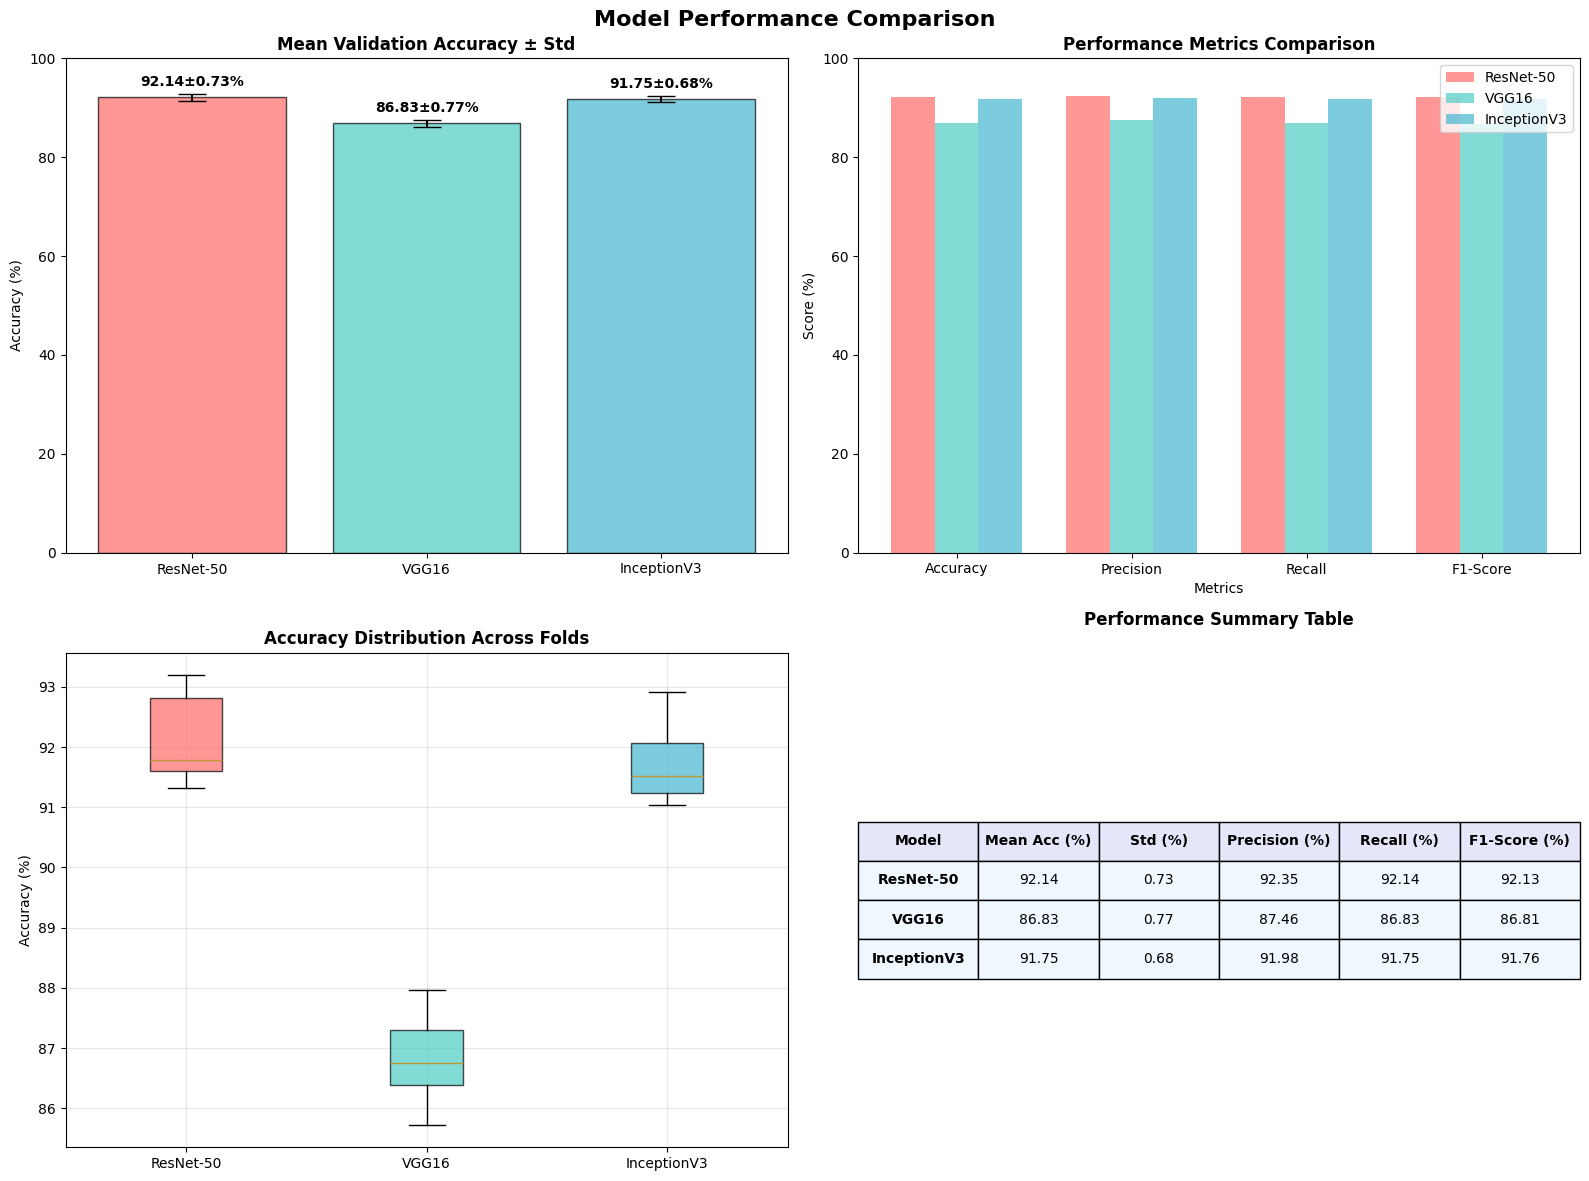


DETAILED MODEL COMPARISON
Best Average Accuracy: ResNet-50 (92.14%)
Best Precision: ResNet-50 (92.35%)
Best Recall: ResNet-50 (92.14%)
Best F1-Score: ResNet-50 (92.13%)

Model Ranking by Average Accuracy:
  1. ResNet-50: 92.14% ± 0.73%
  2. InceptionV3: 91.75% ± 0.68%
  3. VGG16: 86.83% ± 0.77%


In [15]:
def create_model_comparison():
    """Create comprehensive comparison between all models"""
    
    # Collect data for comparison
    comparison_data = {}
    
    for model_name, metric_file in model_files.items():
        try:
            with open(metric_file, 'rb') as f:
                fold_metrics = pickle.load(f)
            
            # Calculate overall statistics
            all_preds = []
            all_targets = []
            fold_accuracies = []
            
            for fold in fold_metrics:
                all_preds.extend(fold_metrics[fold]['val_preds'])
                all_targets.extend(fold_metrics[fold]['val_targets'])
                fold_accuracies.append(fold_metrics[fold]['best_val_accuracy'])
            
            # Calculate metrics
            from sklearn.metrics import precision_recall_fscore_support, accuracy_score
            
            overall_accuracy = accuracy_score(all_targets, all_preds)
            precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='weighted')
            
            comparison_data[model_name] = {
                'accuracy_mean': np.mean(fold_accuracies),
                'accuracy_std': np.std(fold_accuracies),
                'overall_accuracy': overall_accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'fold_accuracies': fold_accuracies
            }
            
        except FileNotFoundError:
            print(f"Warning: {metric_file} not found. Skipping {model_name}.")
            continue
    
    if not comparison_data:
        print("No data available for comparison!")
        return
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
    
    models = list(comparison_data.keys())
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    # Plot 1: Accuracy Comparison with Error Bars
    ax1 = axes[0, 0]
    means = [comparison_data[model]['accuracy_mean'] for model in models]
    stds = [comparison_data[model]['accuracy_std'] for model in models]
    
    bars = ax1.bar(models, means, yerr=stds, capsize=10, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_title('Mean Validation Accuracy ± Std', fontweight='bold')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_ylim(0, 100)
    
    # Add value labels on bars
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + std + 1,
                f'{mean:.2f}±{std:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Multiple Metrics Comparison
    ax2 = axes[0, 1]
    metrics = ['overall_accuracy', 'precision', 'recall', 'f1_score']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    x = np.arange(len(metric_labels))
    width = 0.25
    
    for i, (model, color) in enumerate(zip(models, colors)):
        values = [comparison_data[model][metric] * 100 for metric in metrics]
        ax2.bar(x + i * width, values, width, label=model, color=color, alpha=0.7)
    
    ax2.set_title('Performance Metrics Comparison', fontweight='bold')
    ax2.set_ylabel('Score (%)')
    ax2.set_xlabel('Metrics')
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(metric_labels)
    ax2.legend()
    ax2.set_ylim(0, 100)
    
    # Plot 3: Fold-wise Accuracy Distribution
    ax3 = axes[1, 0]
    
    fold_data = []
    model_labels = []
    
    for model in models:
        fold_data.extend(comparison_data[model]['fold_accuracies'])
        model_labels.extend([model] * len(comparison_data[model]['fold_accuracies']))
    
    # Create box plot
    box_data = [comparison_data[model]['fold_accuracies'] for model in models]
    box_plot = ax3.boxplot(box_data, labels=models, patch_artist=True)
    
    # Color the boxes
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax3.set_title('Accuracy Distribution Across Folds', fontweight='bold')
    ax3.set_ylabel('Accuracy (%)')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Performance Summary Table
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Create table data
    table_data = []
    headers = ['Model', 'Mean Acc (%)', 'Std (%)', 'Precision (%)', 'Recall (%)', 'F1-Score (%)']
    
    for model in models:
        data = comparison_data[model]
        row = [
            model,
            f"{data['accuracy_mean']:.2f}",
            f"{data['accuracy_std']:.2f}",
            f"{data['precision']*100:.2f}",
            f"{data['recall']*100:.2f}",
            f"{data['f1_score']*100:.2f}"
        ]
        table_data.append(row)
    
    # Create table
    table = ax4.table(cellText=table_data, colLabels=headers, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style the table
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Header row
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#E6E6FA')
        else:
            if j == 0:  # Model names
                cell.set_text_props(weight='bold')
            cell.set_facecolor('#F0F8FF')
    
    ax4.set_title('Performance Summary Table', fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig('model_comparison_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed comparison
    print("\n" + "="*80)
    print("DETAILED MODEL COMPARISON")
    print("="*80)
    
    # Find best model for each metric
    best_accuracy = max(models, key=lambda m: comparison_data[m]['accuracy_mean'])
    best_precision = max(models, key=lambda m: comparison_data[m]['precision'])
    best_recall = max(models, key=lambda m: comparison_data[m]['recall'])
    best_f1 = max(models, key=lambda m: comparison_data[m]['f1_score'])
    
    print(f"Best Average Accuracy: {best_accuracy} ({comparison_data[best_accuracy]['accuracy_mean']:.2f}%)")
    print(f"Best Precision: {best_precision} ({comparison_data[best_precision]['precision']*100:.2f}%)")
    print(f"Best Recall: {best_recall} ({comparison_data[best_recall]['recall']*100:.2f}%)")
    print(f"Best F1-Score: {best_f1} ({comparison_data[best_f1]['f1_score']*100:.2f}%)")
    
    # Statistical significance test (if possible)
    print(f"\nModel Ranking by Average Accuracy:")
    sorted_models = sorted(models, key=lambda m: comparison_data[m]['accuracy_mean'], reverse=True)
    for i, model in enumerate(sorted_models, 1):
        acc = comparison_data[model]['accuracy_mean']
        std = comparison_data[model]['accuracy_std']
        print(f"  {i}. {model}: {acc:.2f}% ± {std:.2f}%")
    
    return comparison_data

# Create the comparison
model_comparison_results = create_model_comparison()


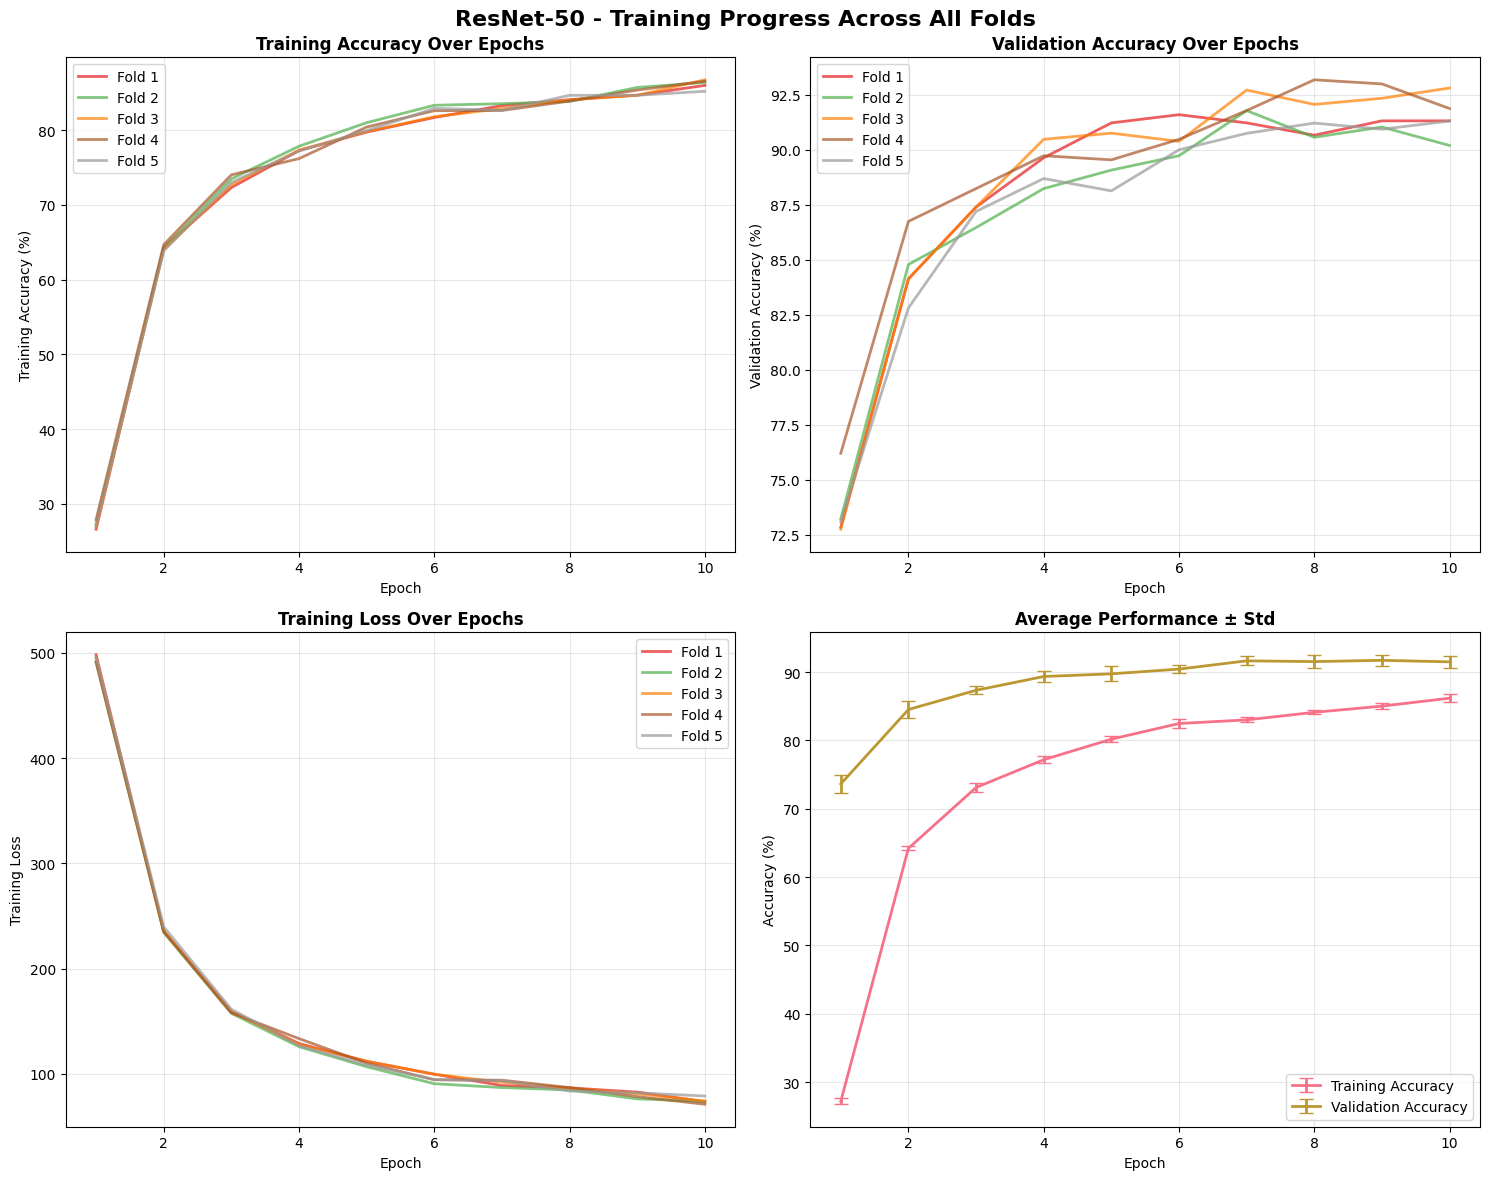


ResNet-50 Training Progress Summary:
Final Training Accuracy: 86.19% ± 0.54%
Final Validation Accuracy: 91.51% ± 0.85%
Best Validation Accuracy: 92.14% ± 0.73%


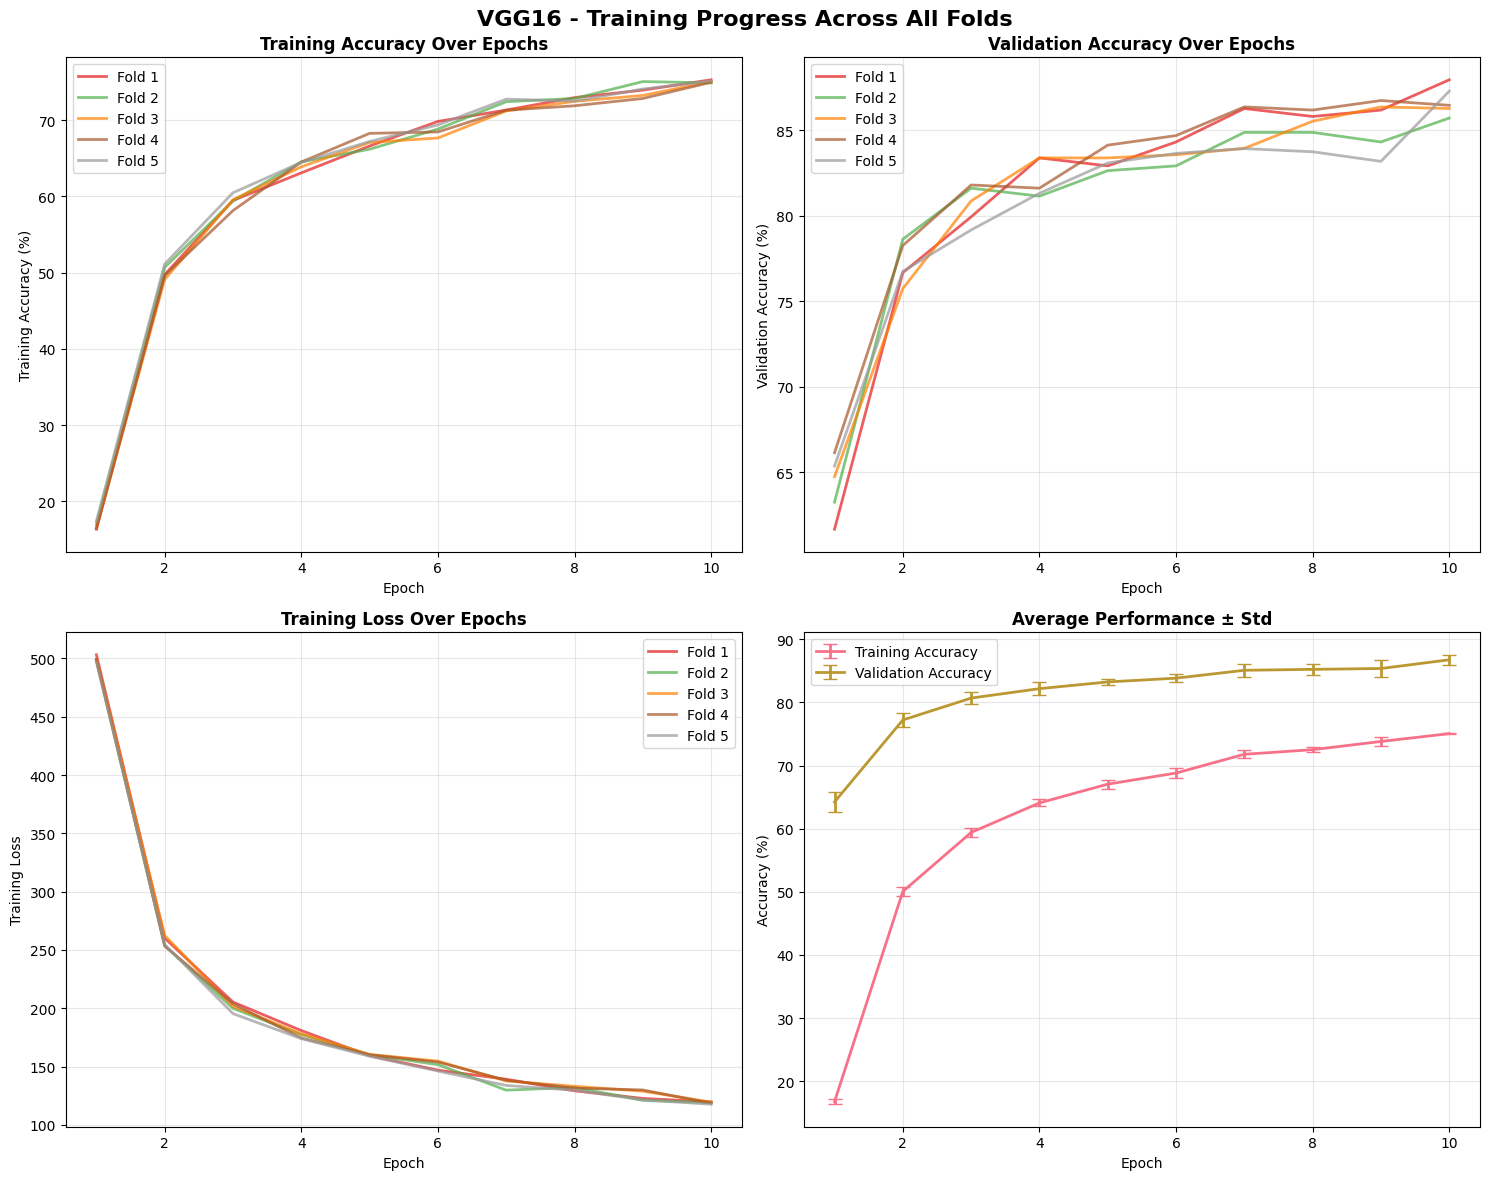


VGG16 Training Progress Summary:
Final Training Accuracy: 75.06% ± 0.14%
Final Validation Accuracy: 86.75% ± 0.79%
Best Validation Accuracy: 86.83% ± 0.77%


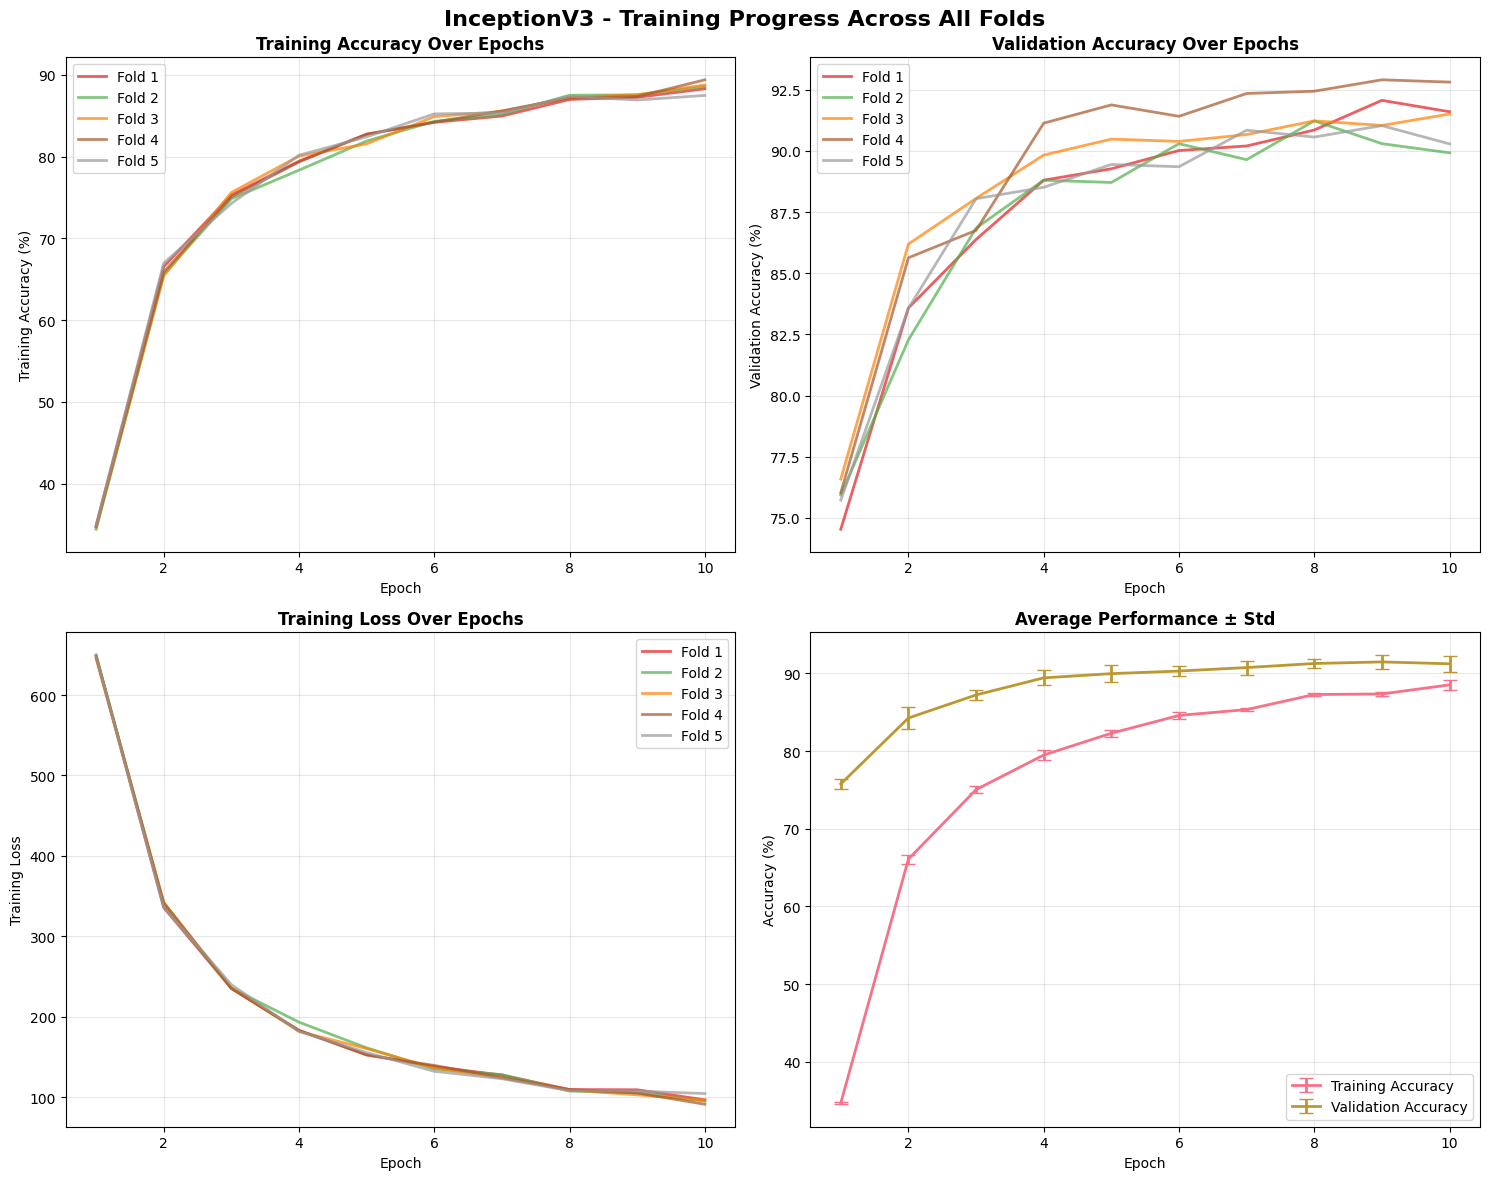


InceptionV3 Training Progress Summary:
Final Training Accuracy: 88.52% ± 0.62%
Final Validation Accuracy: 91.23% ± 1.03%
Best Validation Accuracy: 91.75% ± 0.68%


In [9]:
def plot_training_progress(model_name, metric_file, save_plot=True):
    """Plot training progress (accuracy and loss) over epochs for all folds"""
    try:
        # Load the metrics
        with open(metric_file, 'rb') as f:
            fold_metrics = pickle.load(f)
        
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'{model_name} - Training Progress Across All Folds', fontsize=16, fontweight='bold')
        
        # Colors for different folds
        colors = plt.cm.Set1(np.linspace(0, 1, len(fold_metrics)))
        
        # Plot 1: Training Accuracy over Epochs
        ax1 = axes[0, 0]
        for fold, color in zip(sorted(fold_metrics.keys()), colors):
            epochs = range(1, len(fold_metrics[fold]['train_accuracies']) + 1)
            ax1.plot(epochs, fold_metrics[fold]['train_accuracies'], 
                    color=color, linewidth=2, alpha=0.7, label=f'Fold {fold}')
        
        ax1.set_title('Training Accuracy Over Epochs', fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Training Accuracy (%)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Validation Accuracy over Epochs
        ax2 = axes[0, 1]
        for fold, color in zip(sorted(fold_metrics.keys()), colors):
            epochs = range(1, len(fold_metrics[fold]['val_accuracies']) + 1)
            ax2.plot(epochs, fold_metrics[fold]['val_accuracies'], 
                    color=color, linewidth=2, alpha=0.7, label=f'Fold {fold}')
        
        ax2.set_title('Validation Accuracy Over Epochs', fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Validation Accuracy (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Training Loss over Epochs
        ax3 = axes[1, 0]
        for fold, color in zip(sorted(fold_metrics.keys()), colors):
            epochs = range(1, len(fold_metrics[fold]['train_losses']) + 1)
            ax3.plot(epochs, fold_metrics[fold]['train_losses'], 
                    color=color, linewidth=2, alpha=0.7, label=f'Fold {fold}')
        
        ax3.set_title('Training Loss Over Epochs', fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Training Loss')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Average Performance Comparison
        ax4 = axes[1, 1]
        
        # Calculate averages across folds
        max_epochs = max(len(fold_metrics[fold]['train_accuracies']) for fold in fold_metrics)
        
        avg_train_acc = []
        avg_val_acc = []
        std_train_acc = []
        std_val_acc = []
        
        for epoch in range(max_epochs):
            train_accs = []
            val_accs = []
            
            for fold in fold_metrics:
                if epoch < len(fold_metrics[fold]['train_accuracies']):
                    train_accs.append(fold_metrics[fold]['train_accuracies'][epoch])
                if epoch < len(fold_metrics[fold]['val_accuracies']):
                    val_accs.append(fold_metrics[fold]['val_accuracies'][epoch])
            
            if train_accs:
                avg_train_acc.append(np.mean(train_accs))
                std_train_acc.append(np.std(train_accs))
            if val_accs:
                avg_val_acc.append(np.mean(val_accs))
                std_val_acc.append(np.std(val_accs))
        
        epochs_range = range(1, len(avg_train_acc) + 1)
        
        # Plot mean with error bars
        ax4.errorbar(epochs_range, avg_train_acc, yerr=std_train_acc, 
                    label='Training Accuracy', linewidth=2, capsize=5)
        ax4.errorbar(epochs_range[:len(avg_val_acc)], avg_val_acc, yerr=std_val_acc, 
                    label='Validation Accuracy', linewidth=2, capsize=5)
        
        ax4.set_title('Average Performance ± Std', fontweight='bold')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Accuracy (%)')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_plot:
            plt.savefig(f'{model_name.lower().replace("-", "_")}_training_progress.png', 
                       dpi=300, bbox_inches='tight')
        
        plt.show()
        
        # Print summary statistics
        print(f"\n{model_name} Training Progress Summary:")
        final_train_accs = [fold_metrics[fold]['train_accuracies'][-1] for fold in fold_metrics]
        final_val_accs = [fold_metrics[fold]['val_accuracies'][-1] for fold in fold_metrics]
        best_val_accs = [fold_metrics[fold]['best_val_accuracy'] for fold in fold_metrics]
        
        print(f"Final Training Accuracy: {np.mean(final_train_accs):.2f}% ± {np.std(final_train_accs):.2f}%")
        print(f"Final Validation Accuracy: {np.mean(final_val_accs):.2f}% ± {np.std(final_val_accs):.2f}%")
        print(f"Best Validation Accuracy: {np.mean(best_val_accs):.2f}% ± {np.std(best_val_accs):.2f}%")
        
        return {
            'final_train_acc': np.mean(final_train_accs),
            'final_val_acc': np.mean(final_val_accs),
            'best_val_acc': np.mean(best_val_accs),
            'train_acc_std': np.std(final_train_accs),
            'val_acc_std': np.std(final_val_accs),
            'best_acc_std': np.std(best_val_accs)
        }
        
    except FileNotFoundError:
        print(f"Warning: {metric_file} not found. Skipping {model_name}.")
        return None
    except Exception as e:
        print(f"Error processing {model_name}: {str(e)}")
        return None

# Plot training progress for all models
training_results = {}
for model_name, metric_file in model_files.items():
    result = plot_training_progress(model_name, metric_file)
    if result is not None:
        training_results[model_name] = result


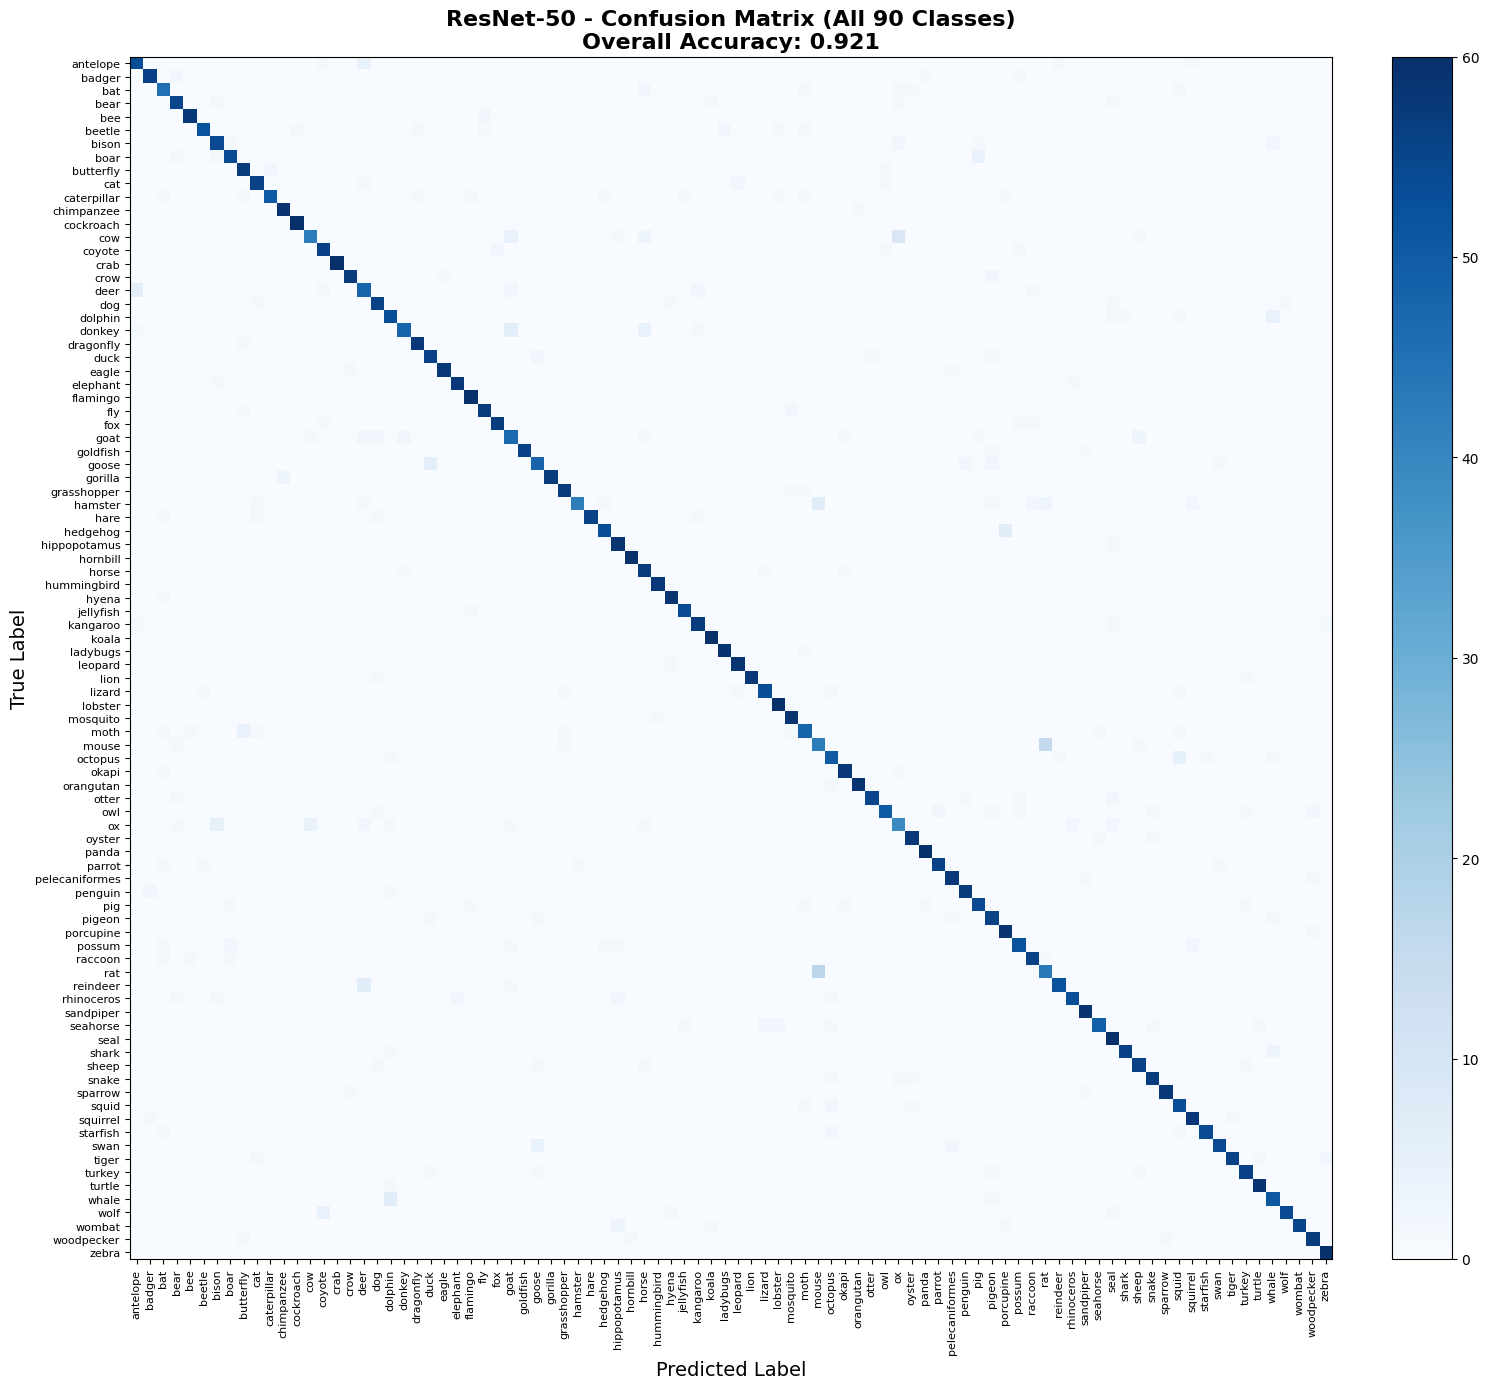


ResNet-50 Confusion Matrix Summary:
Total samples: 5359
Overall accuracy: 0.9214
Number of classes: 90
Most confused pair: rat → mouse (17 times)


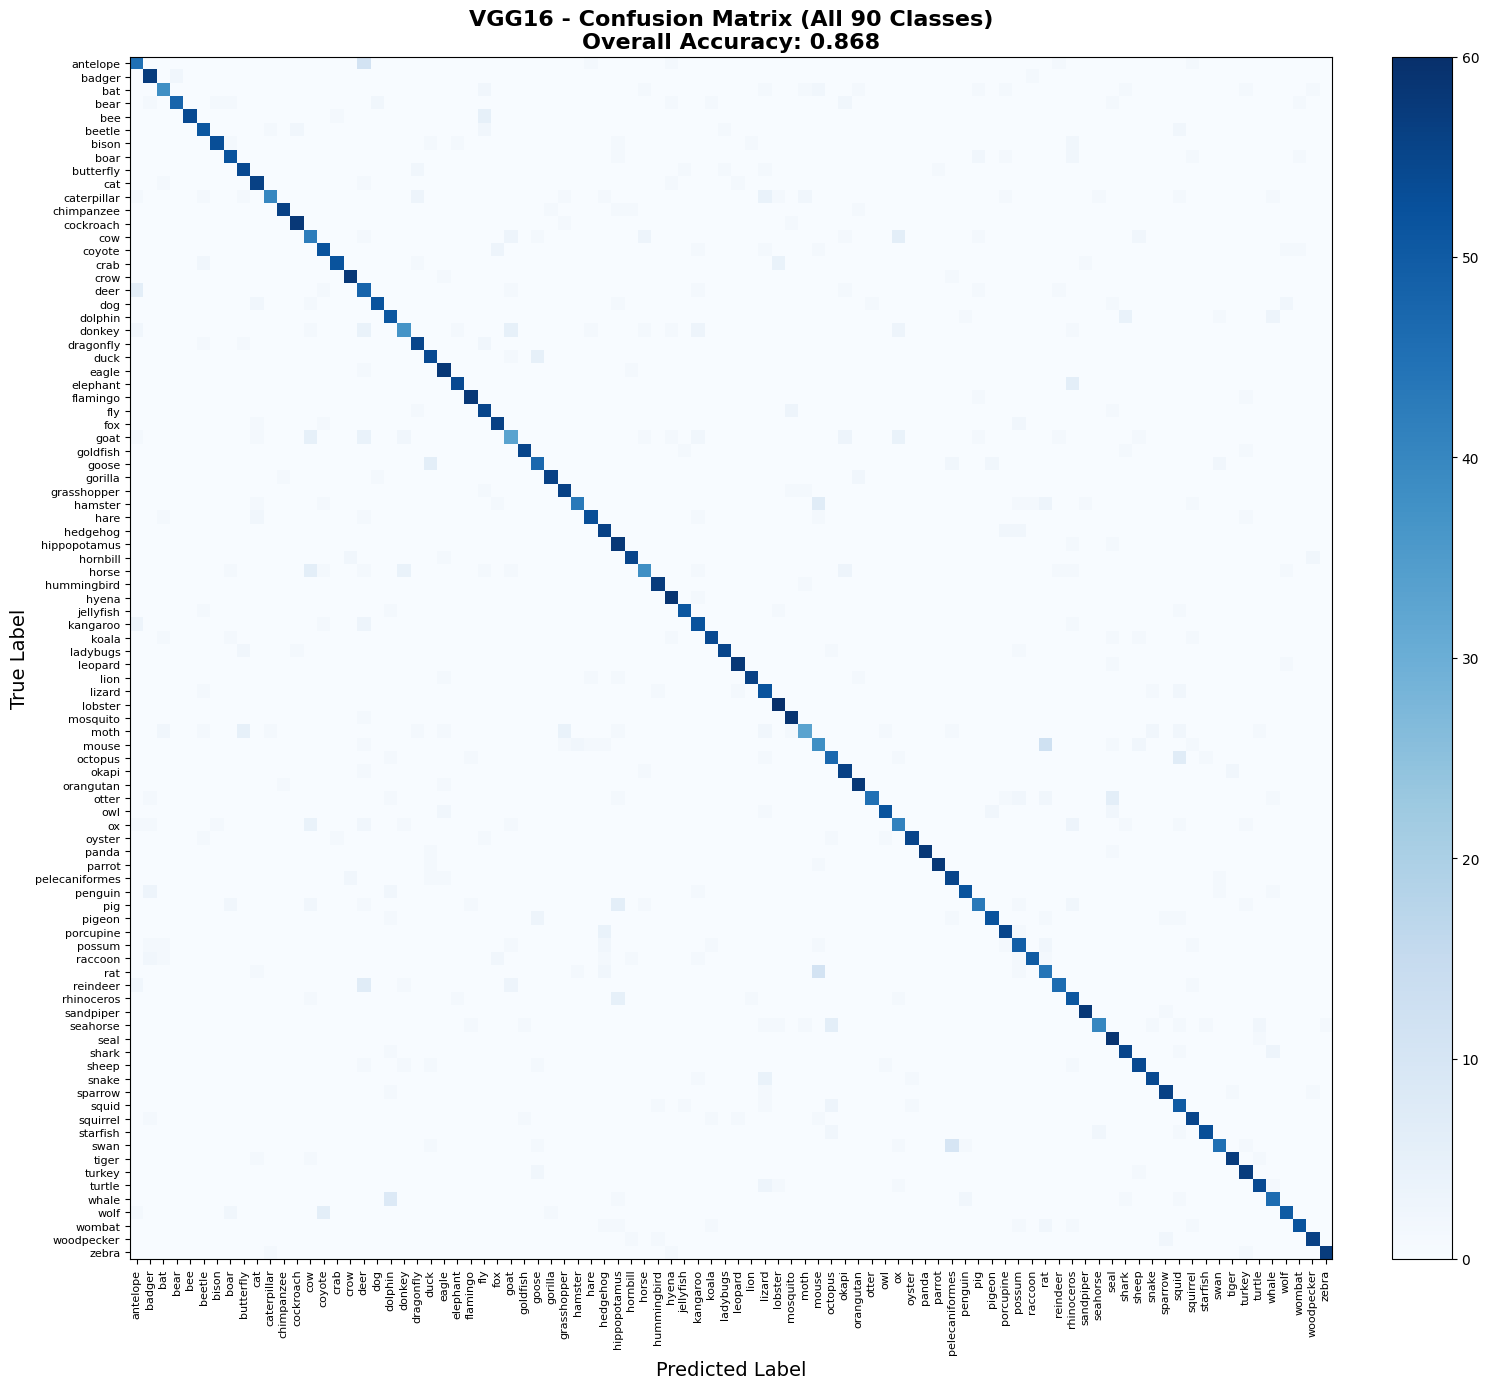


VGG16 Confusion Matrix Summary:
Total samples: 5359
Overall accuracy: 0.8683
Number of classes: 90
Most confused pair: mouse → rat (12 times)


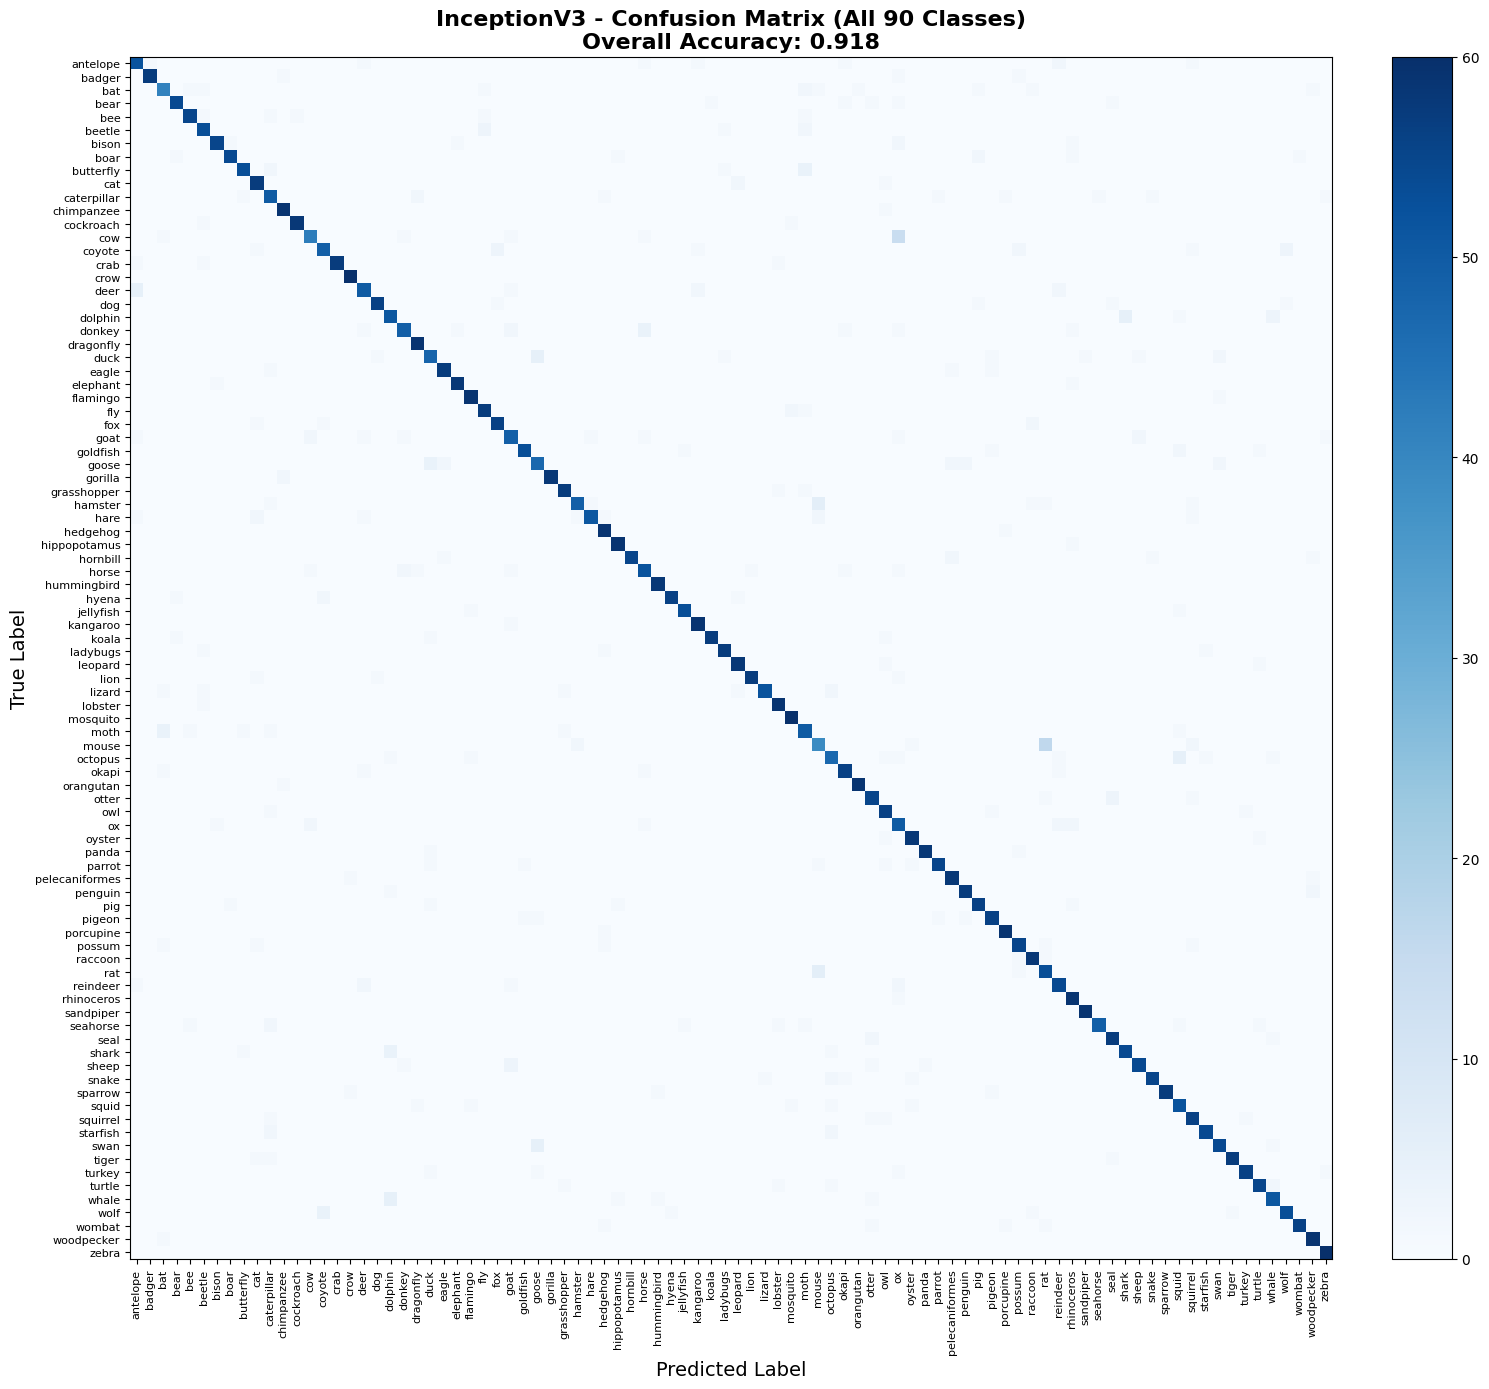


InceptionV3 Confusion Matrix Summary:
Total samples: 5359
Overall accuracy: 0.9175
Number of classes: 90
Most confused pair: mouse → rat (16 times)


In [7]:
def plot_confusion_matrix(model_name, metric_file, save_plot=True):
    """Plot confusion matrix for a specific model"""
    try:
        # Load the metrics
        with open(metric_file, 'rb') as f:
            fold_metrics = pickle.load(f)
        
        # Aggregate predictions and targets across all folds
        all_preds = []
        all_targets = []
        
        for fold in fold_metrics:
            all_preds.extend(fold_metrics[fold]['val_preds'])
            all_targets.extend(fold_metrics[fold]['val_targets'])
        
        # Convert to numpy arrays
        all_preds = np.array(all_preds)
        all_targets = np.array(all_targets)
        
        # Compute confusion matrix
        cm = confusion_matrix(all_targets, all_preds)
        
        # Calculate accuracy
        accuracy = np.sum(all_preds == all_targets) / len(all_targets)
        
        # Create figure with larger size to accommodate all labels
        fig, ax = plt.subplots(1, 1, figsize=(16, 14))
        
        # Full confusion matrix
        class_names = [idx_to_label[i] for i in range(len(idx_to_label))]
        im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
        ax.set_title(f'{model_name} - Confusion Matrix (All 90 Classes)\nOverall Accuracy: {accuracy:.3f}', 
                     fontsize=16, fontweight='bold')
        
        # Add colorbar
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Set labels
        ax.set_xlabel('Predicted Label', fontsize=14)
        ax.set_ylabel('True Label', fontsize=14)
        
        # Show ALL class labels with smaller font size
        tick_marks = np.arange(len(class_names))
        ax.set_xticks(tick_marks)
        ax.set_yticks(tick_marks)
        ax.set_xticklabels(class_names, rotation=90, ha='center', fontsize=8)
        ax.set_yticklabels(class_names, fontsize=8)
        
        plt.tight_layout()
        
        if save_plot:
            plt.savefig(f'{model_name.lower().replace("-", "_")}_confusion_matrix_full.png', 
                       dpi=300, bbox_inches='tight')
        
        plt.show()
        
        # Print summary statistics
        print(f"\n{model_name} Confusion Matrix Summary:")
        print(f"Total samples: {len(all_targets)}")
        print(f"Overall accuracy: {accuracy:.4f}")
        print(f"Number of classes: {len(class_names)}")
        
        # Find most confused classes
        np.fill_diagonal(cm, 0)  # Remove diagonal for finding confusions
        max_confusion_idx = np.unravel_index(np.argmax(cm), cm.shape)
        print(f"Most confused pair: {class_names[max_confusion_idx[0]]} → {class_names[max_confusion_idx[1]]} ({cm[max_confusion_idx]} times)")
        
        return accuracy, cm
        
    except FileNotFoundError:
        print(f"Warning: {metric_file} not found. Skipping {model_name}.")
        return None, None
    except Exception as e:
        print(f"Error processing {model_name}: {str(e)}")
        return None, None

# Plot confusion matrices for all models
model_files = {
    'ResNet-50': 'resnet_all_fold_metrics.pkl',
    'VGG16': 'vgg16_all_fold_metrics.pkl', 
    'InceptionV3': 'inceptionv3_all_fold_metrics.pkl'
}

confusion_results = {}
for model_name, metric_file in model_files.items():
    accuracy, cm = plot_confusion_matrix(model_name, metric_file)
    if accuracy is not None:
        confusion_results[model_name] = {'accuracy': accuracy, 'confusion_matrix': cm}

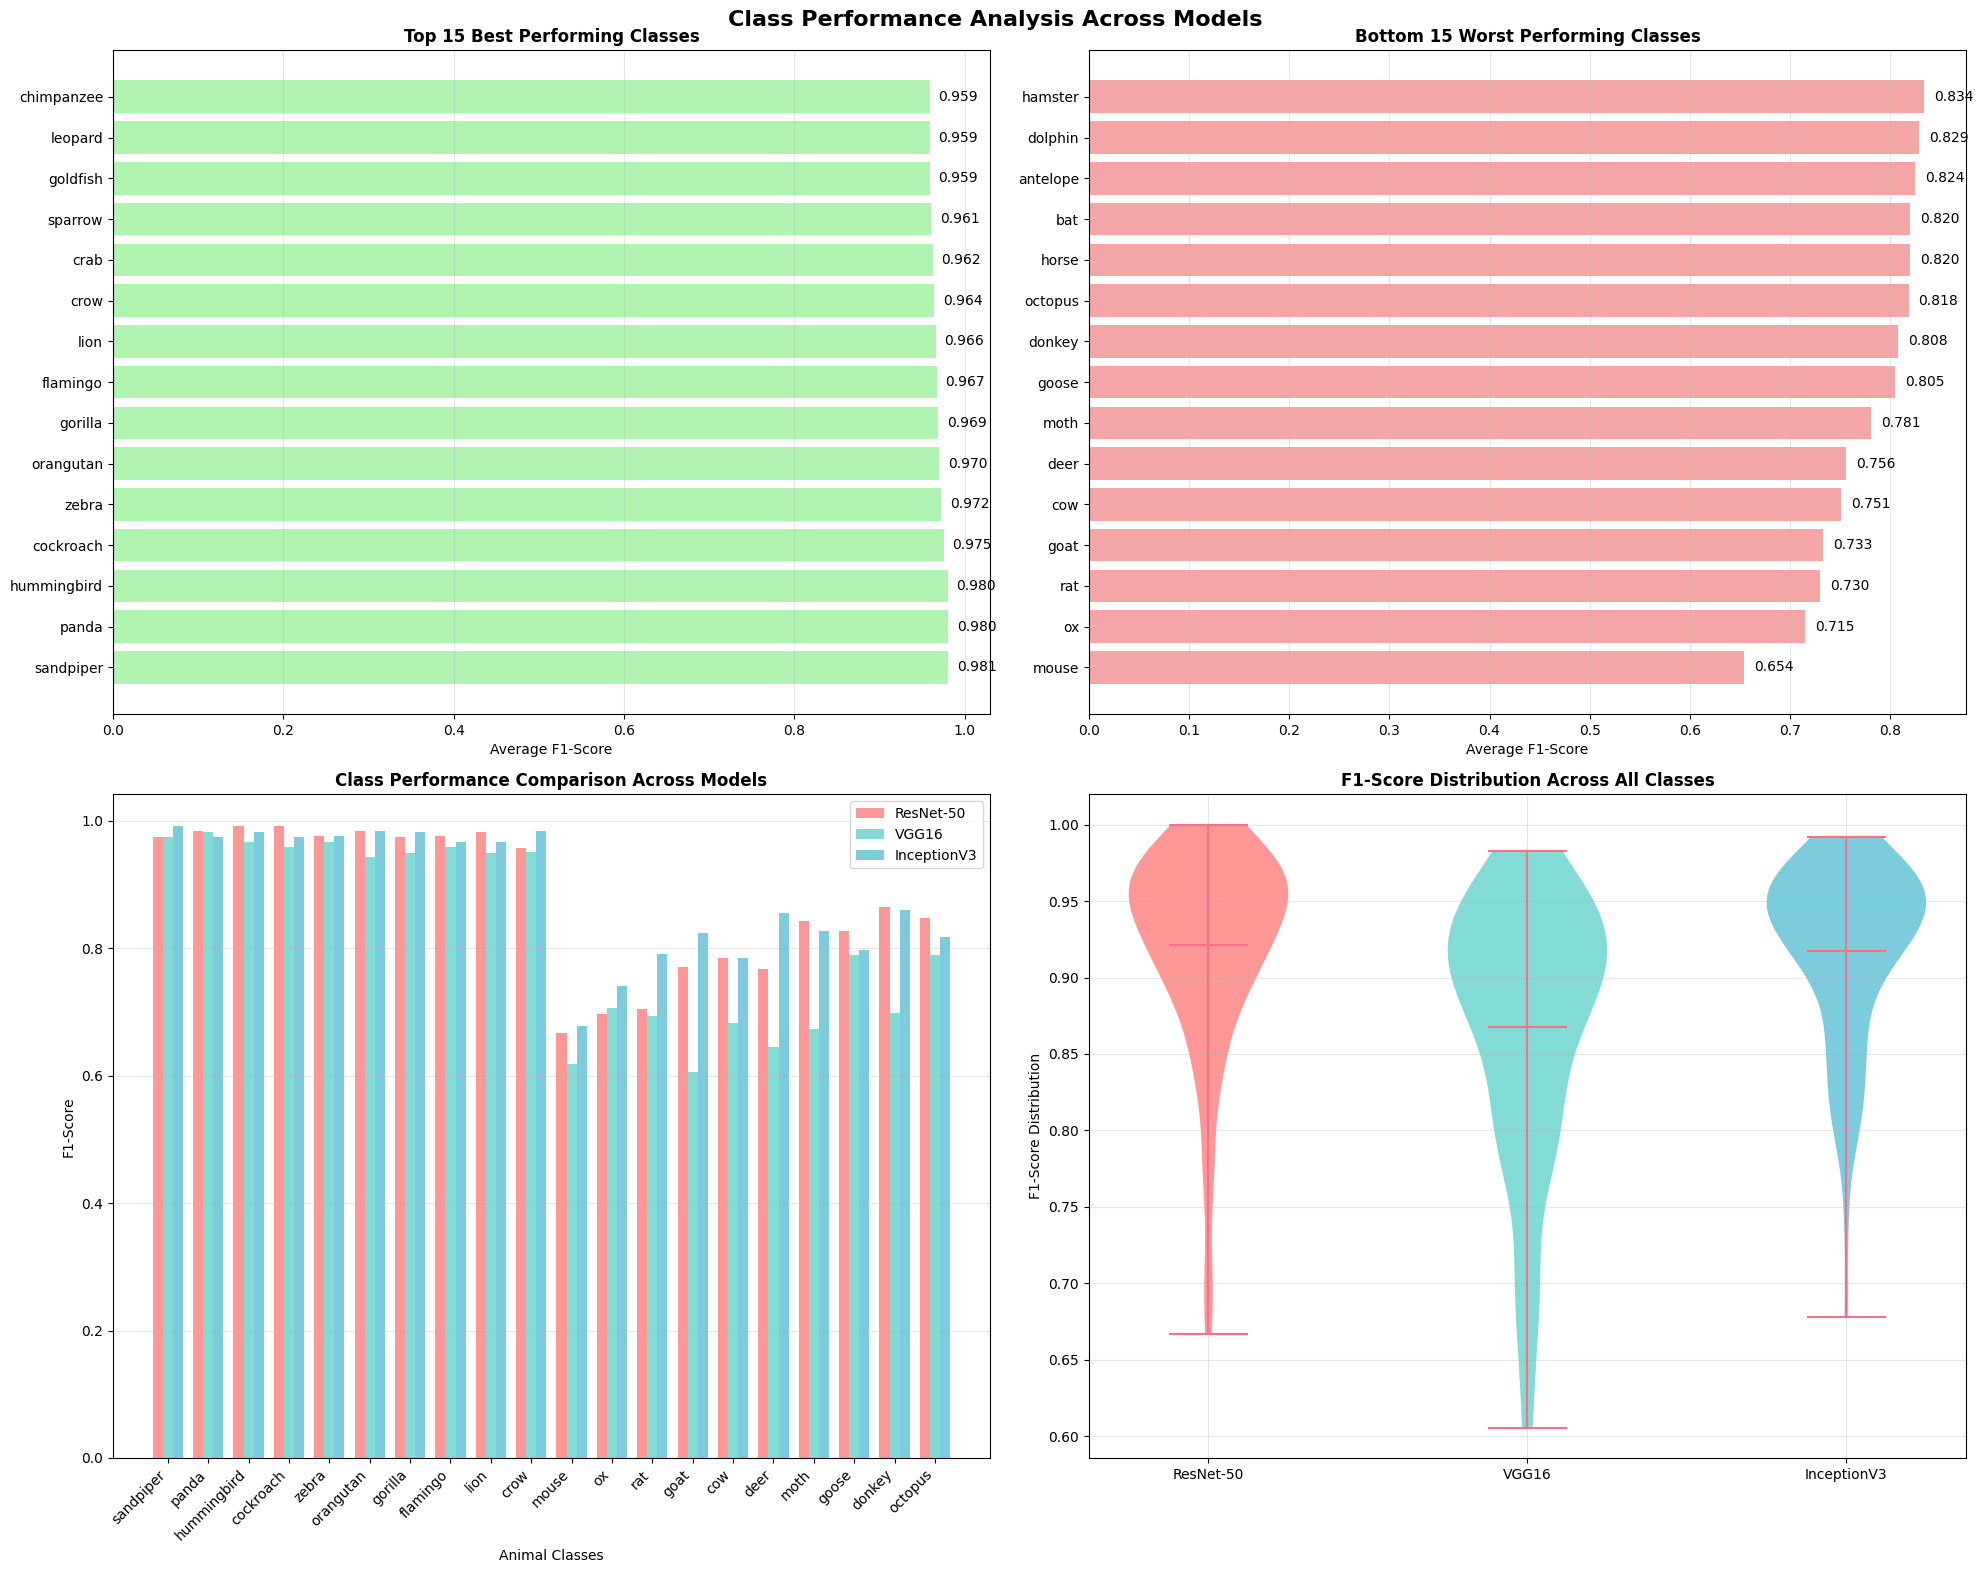


CLASS PERFORMANCE ANALYSIS

TOP 10 EASIEST CLASSES TO CLASSIFY (Average F1-Score):
   1. sandpiper           : 0.981
   2. panda               : 0.980
   3. hummingbird         : 0.980
   4. cockroach           : 0.975
   5. zebra               : 0.972
   6. orangutan           : 0.970
   7. gorilla             : 0.969
   8. flamingo            : 0.967
   9. lion                : 0.966
  10. crow                : 0.964

TOP 10 HARDEST CLASSES TO CLASSIFY (Average F1-Score):
   1. mouse               : 0.654
   2. ox                  : 0.715
   3. rat                 : 0.730
   4. goat                : 0.733
   5. cow                 : 0.751
   6. deer                : 0.756
   7. moth                : 0.781
   8. goose               : 0.805
   9. donkey              : 0.808
  10. octopus             : 0.818


In [12]:
def analyze_class_performance():
    """Analyze per-class performance across all models"""
    
    # Collect per-class performance data for all models
    class_performance = {}
    
    for model_name, metric_file in model_files.items():
        try:
            with open(metric_file, 'rb') as f:
                fold_metrics = pickle.load(f)
            
            # Aggregate predictions and targets across all folds
            all_preds = []
            all_targets = []
            
            for fold in fold_metrics:
                all_preds.extend(fold_metrics[fold]['val_preds'])
                all_targets.extend(fold_metrics[fold]['val_targets'])
            
            # Calculate per-class metrics
            from sklearn.metrics import classification_report
            target_names = [idx_to_label[i] for i in range(len(idx_to_label))]
            
            report = classification_report(
                all_targets, all_preds, 
                target_names=target_names,
                output_dict=True,
                zero_division=0
            )
            
            # Store per-class F1 scores
            class_f1_scores = []
            class_names = []
            
            for class_name in target_names:
                if class_name in report and isinstance(report[class_name], dict):
                    class_f1_scores.append(report[class_name]['f1-score'])
                    class_names.append(class_name)
            
            class_performance[model_name] = {
                'class_names': class_names,
                'f1_scores': class_f1_scores,
                'full_report': report
            }
            
        except FileNotFoundError:
            print(f"Warning: {metric_file} not found. Skipping {model_name}.")
            continue
    
    if not class_performance:
        print("No data available for class performance analysis!")
        return
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Class Performance Analysis Across Models', fontsize=16, fontweight='bold')
    
    # Get common classes across all models
    common_classes = set(class_performance[list(class_performance.keys())[0]]['class_names'])
    for model_data in class_performance.values():
        common_classes = common_classes.intersection(set(model_data['class_names']))
    common_classes = sorted(list(common_classes))
    
    # Plot 1: Top 15 Best Performing Classes (Average F1-Score)
    ax1 = axes[0, 0]
    
    # Calculate average F1-score across models for each class
    avg_f1_by_class = {}
    for class_name in common_classes:
        f1_scores = []
        for model_name in class_performance:
            class_idx = class_performance[model_name]['class_names'].index(class_name)
            f1_scores.append(class_performance[model_name]['f1_scores'][class_idx])
        avg_f1_by_class[class_name] = np.mean(f1_scores)
    
    # Sort and get top 15
    top_classes = sorted(avg_f1_by_class.items(), key=lambda x: x[1], reverse=True)[:15]
    top_class_names, top_f1_scores = zip(*top_classes)
    
    bars1 = ax1.barh(range(len(top_class_names)), top_f1_scores, color='lightgreen', alpha=0.7)
    ax1.set_yticks(range(len(top_class_names)))
    ax1.set_yticklabels(top_class_names)
    ax1.set_xlabel('Average F1-Score')
    ax1.set_title('Top 15 Best Performing Classes', fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, score) in enumerate(zip(bars1, top_f1_scores)):
        ax1.text(score + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{score:.3f}', va='center', fontsize=10)
    
    # Plot 2: Bottom 15 Worst Performing Classes
    ax2 = axes[0, 1]
    
    # Get bottom 15
    bottom_classes = sorted(avg_f1_by_class.items(), key=lambda x: x[1])[:15]
    bottom_class_names, bottom_f1_scores = zip(*bottom_classes)
    
    bars2 = ax2.barh(range(len(bottom_class_names)), bottom_f1_scores, color='lightcoral', alpha=0.7)
    ax2.set_yticks(range(len(bottom_class_names)))
    ax2.set_yticklabels(bottom_class_names)
    ax2.set_xlabel('Average F1-Score')
    ax2.set_title('Bottom 15 Worst Performing Classes', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, score) in enumerate(zip(bars2, bottom_f1_scores)):
        ax2.text(score + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{score:.3f}', va='center', fontsize=10)
    
    # Plot 3: Class Performance Comparison Between Models
    ax3 = axes[1, 0]
    
    # Select 20 classes for comparison (mix of good and bad performers)
    selected_classes = list(top_class_names[:10]) + list(bottom_class_names[:10])
    
    model_names = list(class_performance.keys())
    x = np.arange(len(selected_classes))
    width = 0.25
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for i, (model_name, color) in enumerate(zip(model_names, colors)):
        f1_scores = []
        for class_name in selected_classes:
            class_idx = class_performance[model_name]['class_names'].index(class_name)
            f1_scores.append(class_performance[model_name]['f1_scores'][class_idx])
        
        ax3.bar(x + i * width, f1_scores, width, label=model_name, color=color, alpha=0.7)
    
    ax3.set_xlabel('Animal Classes')
    ax3.set_ylabel('F1-Score')
    ax3.set_title('Class Performance Comparison Across Models', fontweight='bold')
    ax3.set_xticks(x + width)
    ax3.set_xticklabels(selected_classes, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Performance Distribution
    ax4 = axes[1, 1]
    
    # Create violin plot showing F1-score distributions for each model
    all_f1_data = []
    model_labels = []
    
    for model_name in model_names:
        all_f1_data.append(class_performance[model_name]['f1_scores'])
        model_labels.append(model_name)
    
    violin_parts = ax4.violinplot(all_f1_data, positions=range(len(model_names)), showmeans=True)
    
    # Color the violins
    for i, pc in enumerate(violin_parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)
    
    ax4.set_xticks(range(len(model_names)))
    ax4.set_xticklabels(model_names)
    ax4.set_ylabel('F1-Score Distribution')
    ax4.set_title('F1-Score Distribution Across All Classes', fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('class_performance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed analysis
    print("\n" + "="*80)
    print("CLASS PERFORMANCE ANALYSIS")
    print("="*80)
    
    print(f"\nTOP 10 EASIEST CLASSES TO CLASSIFY (Average F1-Score):")
    for i, (class_name, f1_score) in enumerate(top_classes[:10], 1):
        print(f"  {i:2d}. {class_name:20s}: {f1_score:.3f}")
    
    print(f"\nTOP 10 HARDEST CLASSES TO CLASSIFY (Average F1-Score):")
    for i, (class_name, f1_score) in enumerate(bottom_classes[:10], 1):
        print(f"  {i:2d}. {class_name:20s}: {f1_score:.3f}")
    
    return class_performance, avg_f1_by_class

# Analyze class performance
class_perf_results, avg_class_f1 = analyze_class_performance()

Generating prediction examples...
Using best performing model: ResNet-50


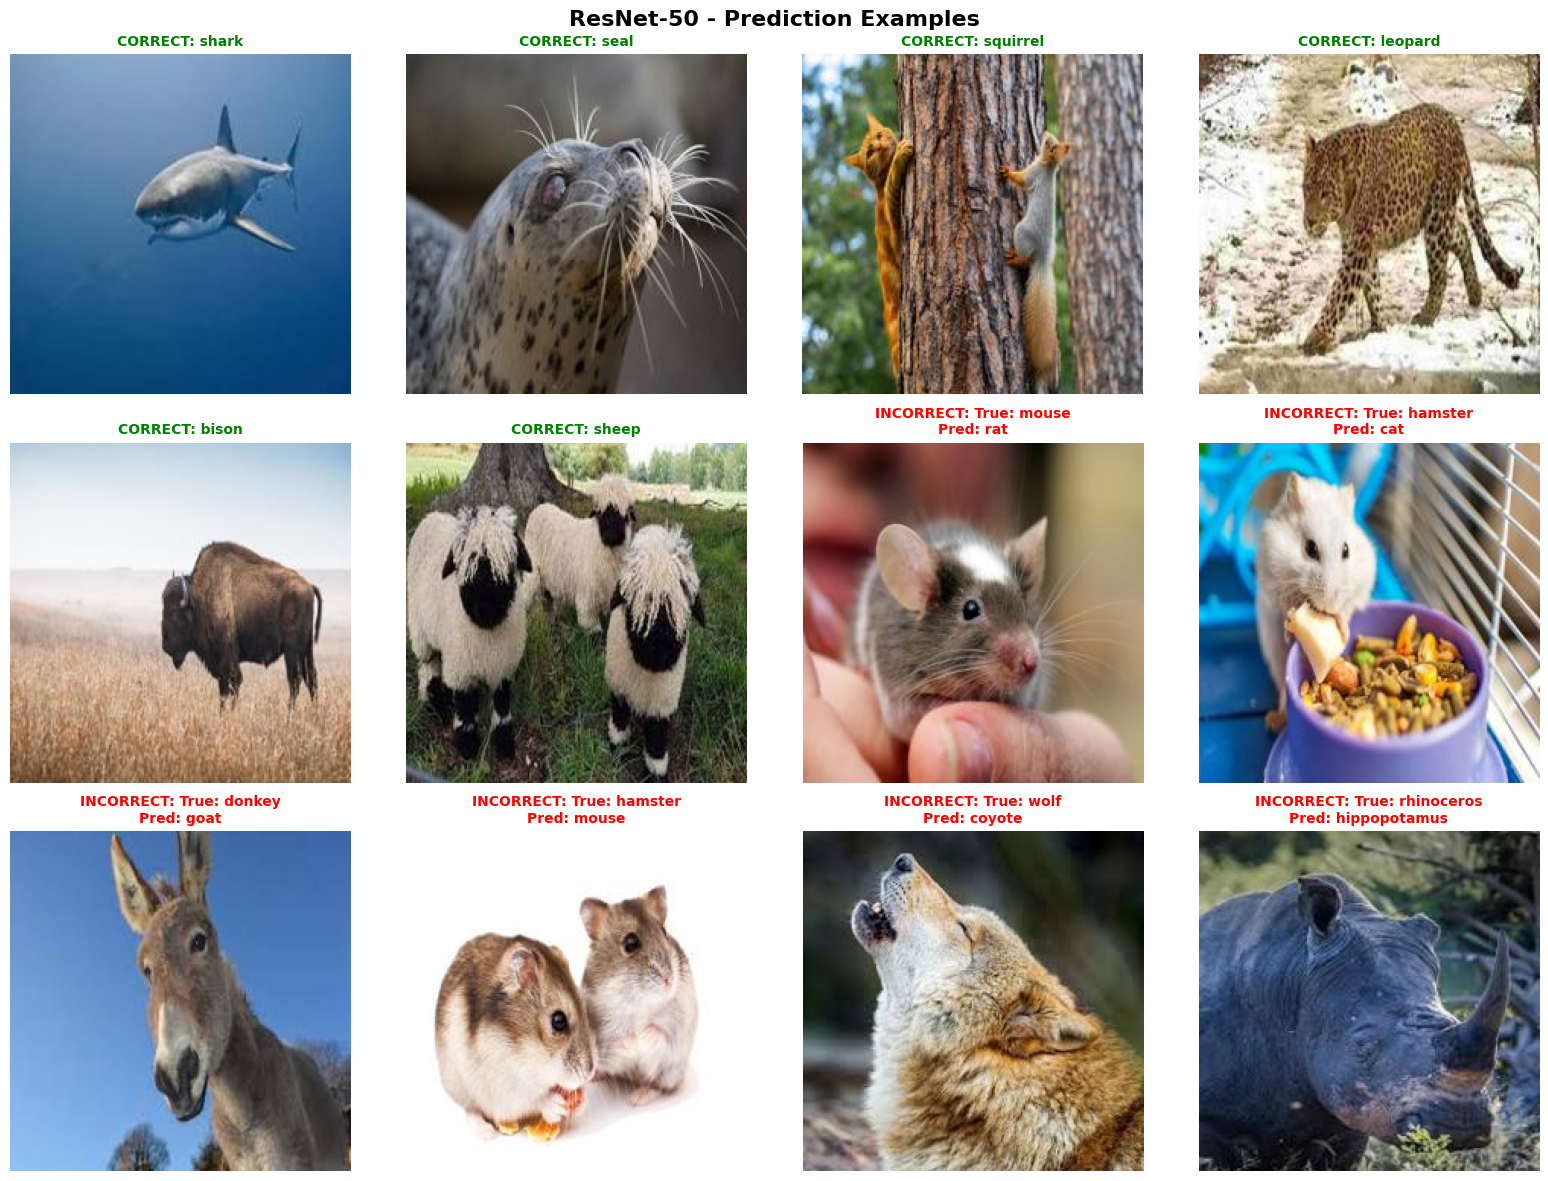


Analyzing false positive patterns...

FALSE POSITIVE ANALYSIS

ResNet-50 - Top 10 Most Common Misclassifications:
------------------------------------------------------------
   1. rat             → mouse           ( 17 times)
   2. mouse           → rat             ( 15 times)
   3. cow             → ox              (  9 times)
   4. hamster         → mouse           (  7 times)
   5. hedgehog        → porcupine       (  7 times)
   6. whale           → dolphin         (  7 times)
   7. reindeer        → deer            (  7 times)
   8. donkey          → goat            (  6 times)
   9. deer            → antelope        (  6 times)
  10. goose           → duck            (  6 times)

VGG16 - Top 10 Most Common Misclassifications:
------------------------------------------------------------
   1. mouse           → rat             ( 12 times)
   2. antelope        → deer            ( 11 times)
   3. rat             → mouse           ( 11 times)
   4. swan            → pelecaniformes 

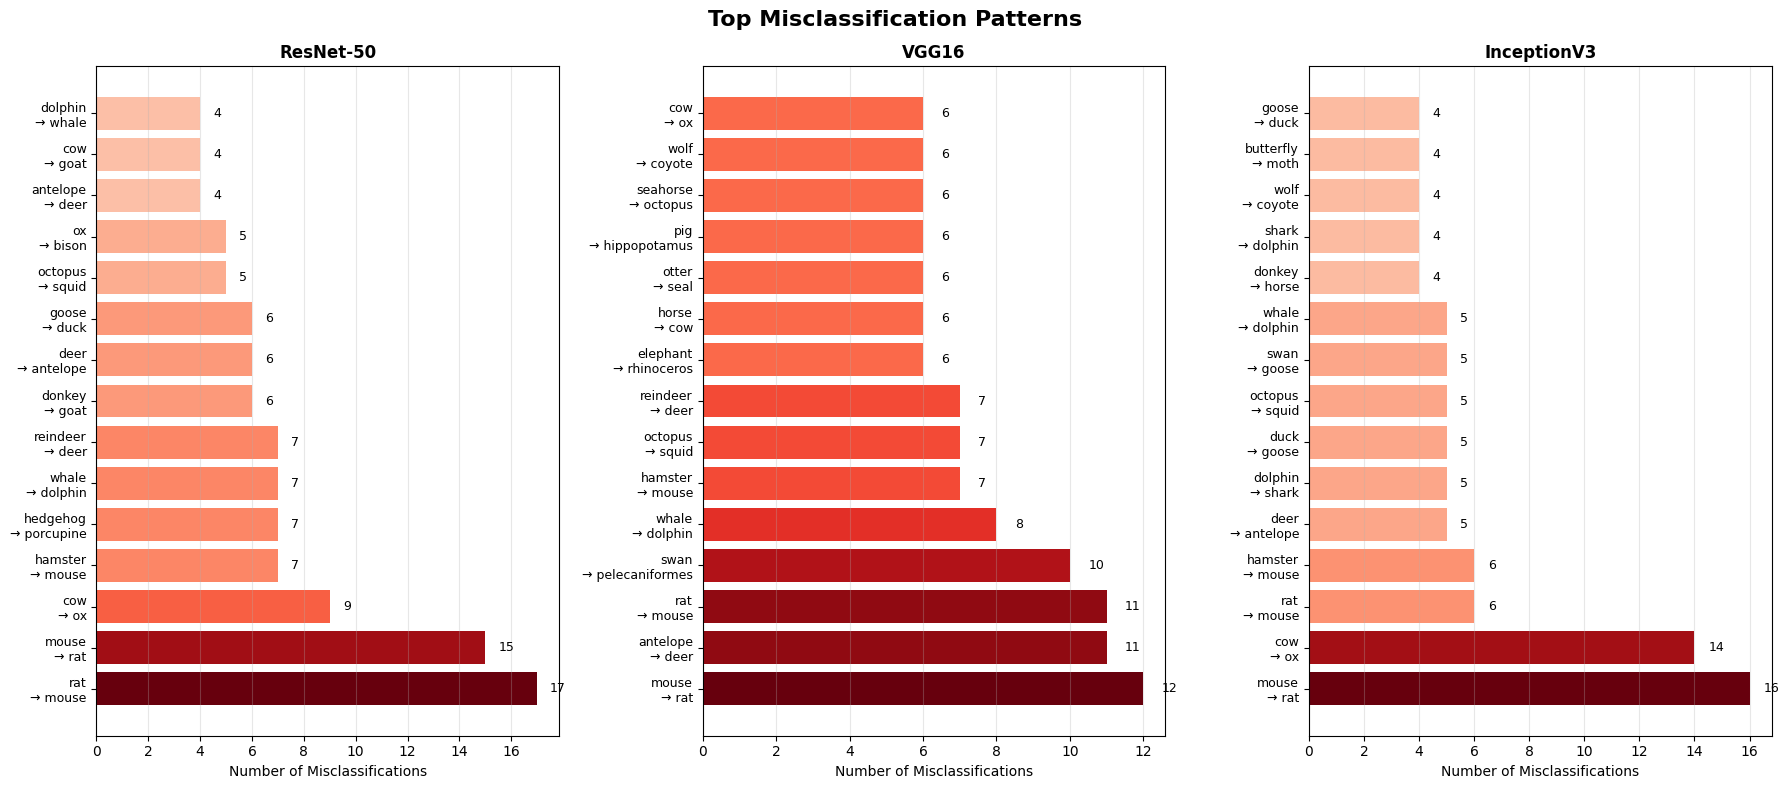


Prediction Examples Summary:
Total examples shown: 12
Correct predictions: 6
Incorrect predictions: 6

Total false positives found: 90

Classes most often misclassified (True labels):
  donkey: 5 times
  mouse: 5 times
  ox: 5 times
  hamster: 4 times
  moth: 4 times

Classes most often predicted incorrectly (Predicted labels):
  goat: 6 times
  rat: 5 times
  horse: 4 times
  seal: 4 times
  bear: 3 times


In [18]:
def show_prediction_examples():
    """Show actual images with predictions from the best performing model"""
    
    # Find the best performing model
    if 'model_comparison_results' in globals():
        best_model = max(model_comparison_results.items(), key=lambda x: x[1]['accuracy_mean'])
        best_model_name = best_model[0]
        print(f"Using best performing model: {best_model_name}")
    else:
        best_model_name = 'InceptionV3'  # Default to InceptionV3
        print(f"Using default model: {best_model_name}")
    
    # Load data for the best model
    metric_file = model_files[best_model_name]
    
    try:
        with open(metric_file, 'rb') as f:
            fold_metrics = pickle.load(f)
        
        # Use fold 1 for visualization (you can change this)
        fold_data = fold_metrics[1]
        
        # Get predictions and targets
        predictions = np.array(fold_data['val_preds'])
        targets = np.array(fold_data['val_targets'])
        
        # Get corresponding image paths and labels from the validation set
        # We need to reconstruct the validation set from fold 1
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        fold_splits = list(enumerate(skf.split(image_paths, labels), 1))
        _, (train_idx, val_idx) = fold_splits[0]  # Get fold 1 data
        
        val_images = image_paths[val_idx]
        val_labels = labels[val_idx]
        
        # Create examples
        correct_predictions = []
        false_positives = []
        false_negatives = []
        
        for i, (pred, target) in enumerate(zip(predictions, targets)):
            image_path = val_images[i]
            true_label = idx_to_label[target]
            pred_label = idx_to_label[pred]
            
            if pred == target:
                correct_predictions.append({
                    'image_path': image_path,
                    'true_label': true_label,
                    'pred_label': pred_label,
                    'correct': True
                })
            else:
                false_positives.append({
                    'image_path': image_path,
                    'true_label': true_label,
                    'pred_label': pred_label,
                    'correct': False
                })
        
        # Sample examples for visualization
        np.random.seed(42)
        n_examples = 12
        
        # Get some correct predictions
        correct_sample = np.random.choice(len(correct_predictions), 
                                        min(n_examples//2, len(correct_predictions)), 
                                        replace=False)
        
        # Get some false positives
        false_sample = np.random.choice(len(false_positives), 
                                      min(n_examples//2, len(false_positives)), 
                                      replace=False)
        
        # Combine examples
        example_data = []
        for idx in correct_sample:
            example_data.append(correct_predictions[idx])
        for idx in false_sample:
            example_data.append(false_positives[idx])
        
        # Create visualization
        n_cols = 4
        n_rows = (len(example_data) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        fig.suptitle(f'{best_model_name} - Prediction Examples', fontsize=16, fontweight='bold')
        
        for idx, example in enumerate(example_data):
            row = idx // n_cols
            col = idx % n_cols
            ax = axes[row, col]
            
            try:
                # Load and display image
                img = Image.open(example['image_path'])
                img = img.convert('RGB')
                ax.imshow(img)
                ax.axis('off')
                
                # Create title based on correctness
                if example['correct']:
                    title = f"CORRECT: {example['true_label']}"
                    title_color = 'green'
                else:
                    title = f"INCORRECT: True: {example['true_label']}\nPred: {example['pred_label']}"
                    title_color = 'red'
                
                ax.set_title(title, fontsize=10, fontweight='bold', color=title_color)
                
            except Exception as e:
                ax.text(0.5, 0.5, f'Error loading\n{example["image_path"]}', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.axis('off')
        
        # Hide empty subplots
        for idx in range(len(example_data), n_rows * n_cols):
            row = idx // n_cols
            col = idx % n_cols
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'{best_model_name.lower()}_prediction_examples.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return example_data, correct_predictions, false_positives
        
    except Exception as e:
        print(f"Error loading visualization data: {e}")
        return None, None, None

def analyze_false_positives():
    """Analyze common false positive patterns"""
    
    print("\n" + "="*80)
    print("FALSE POSITIVE ANALYSIS")
    print("="*80)
    
    false_positive_patterns = {}
    
    for model_name, metric_file in model_files.items():
        try:
            with open(metric_file, 'rb') as f:
                fold_metrics = pickle.load(f)
            
            # Aggregate all predictions and targets
            all_preds = []
            all_targets = []
            
            for fold in fold_metrics:
                all_preds.extend(fold_metrics[fold]['val_preds'])
                all_targets.extend(fold_metrics[fold]['val_targets'])
            
            # Find false positives
            confusion_pairs = {}
            
            for pred, target in zip(all_preds, all_targets):
                if pred != target:
                    true_label = idx_to_label[target]
                    pred_label = idx_to_label[pred]
                    
                    pair = (true_label, pred_label)
                    confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1
            
            # Sort by frequency
            sorted_confusions = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)
            
            false_positive_patterns[model_name] = sorted_confusions[:20]  # Top 20
            
            print(f"\n{model_name} - Top 10 Most Common Misclassifications:")
            print("-" * 60)
            for i, ((true_label, pred_label), count) in enumerate(sorted_confusions[:10], 1):
                print(f"  {i:2d}. {true_label:15s} → {pred_label:15s} ({count:3d} times)")
                
        except FileNotFoundError:
            print(f"Warning: {metric_file} not found. Skipping {model_name}.")
            continue
    
    # Create visualization of top confusion patterns
    if false_positive_patterns:
        fig, axes = plt.subplots(1, len(false_positive_patterns), figsize=(6*len(false_positive_patterns), 8))
        if len(false_positive_patterns) == 1:
            axes = [axes]
        
        fig.suptitle('Top Misclassification Patterns', fontsize=16, fontweight='bold')
        
        for idx, (model_name, confusions) in enumerate(false_positive_patterns.items()):
            ax = axes[idx]
            
            # Get top 15 confusions for visualization
            top_confusions = confusions[:15]
            
            # Prepare data
            labels = []
            counts = []
            colors = []
            
            for (true_label, pred_label), count in top_confusions:
                labels.append(f"{true_label}\n→ {pred_label}")
                counts.append(count)
                colors.append(plt.cm.Reds(count / max(c for _, c in top_confusions)))
            
            # Create horizontal bar chart
            bars = ax.barh(range(len(labels)), counts, color=colors)
            ax.set_yticks(range(len(labels)))
            ax.set_yticklabels(labels, fontsize=9)
            ax.set_xlabel('Number of Misclassifications')
            ax.set_title(f'{model_name}', fontweight='bold')
            ax.grid(True, alpha=0.3, axis='x')
            
            # Add value labels
            for bar, count in zip(bars, counts):
                ax.text(count + 0.5, bar.get_y() + bar.get_height()/2, 
                       str(count), va='center', fontsize=9)
        
        plt.tight_layout()
        plt.savefig('false_positive_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    return false_positive_patterns

# Run the analyses
print("Generating prediction examples...")
examples, correct_preds, false_preds = show_prediction_examples()

print("\nAnalyzing false positive patterns...")
fp_patterns = analyze_false_positives()

if examples:
    print(f"\nPrediction Examples Summary:")
    print(f"Total examples shown: {len(examples)}")
    n_correct = sum(1 for ex in examples if ex['correct'])
    n_incorrect = len(examples) - n_correct
    print(f"Correct predictions: {n_correct}")
    print(f"Incorrect predictions: {n_incorrect}")
    
if false_preds:
    print(f"\nTotal false positives found: {len(false_preds)}")
    
    # Show some statistics about false positives
    fp_by_true_class = {}
    fp_by_pred_class = {}
    
    for fp in false_preds:
        true_label = fp['true_label']
        pred_label = fp['pred_label']
        
        fp_by_true_class[true_label] = fp_by_true_class.get(true_label, 0) + 1
        fp_by_pred_class[pred_label] = fp_by_pred_class.get(pred_label, 0) + 1
    
    # Classes most often misclassified
    worst_true = sorted(fp_by_true_class.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\nClasses most often misclassified (True labels):")
    for class_name, count in worst_true:
        print(f"  {class_name}: {count} times")
    
    # Classes most often predicted incorrectly
    worst_pred = sorted(fp_by_pred_class.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\nClasses most often predicted incorrectly (Predicted labels):")
    for class_name, count in worst_pred:
        print(f"  {class_name}: {count} times")
